In this notebook, there are graphics for comparing the multinomial model and the Dirichlet-multinomial models and different parameters phi for the Dirichlet-multinomial model. This includes plots of ROC curves and adjusting the required power of the test.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tk
import scipy.stats as st
import matplotlib.colors as cl
from tqdm.notebook import tqdm

In [2]:
#Program to retrieve the data from the csv file for same compounds.

sub_directory = "../data/ll_files/"

#Impport the contingency tables.
df = pd.read_csv(sub_directory + "DMN_same_tables.csv")

flat_tables = df.groupby("tb_index")["intensity"].agg(list).apply(np.array) #A table is stored as 2d intensity values of same tb index.
tables = [tb.reshape(2, len(tb) // 2) for tb in flat_tables] #The first d intensities are for row 1, and the others for row 2.
nb_col = [len(tb[0]) for tb in tables] #The number of columns is the length of the first row in the table.

#Import the associated mq values (one for each contingency table)
df_mq = pd.read_csv(sub_directory + "DMN_same_mq.csv")

#Import the associated bayesian similarity index (one for each couple of spectra, that has been computed independently)
df_bsi = pd.read_csv(sub_directory + "DMN_same_bsi.csv")

#Store everything into the same dataframe.
DMN_same = pd.DataFrame({"tables": tables, "nb_col": nb_col, "mq": df_mq["mq"], "bsi" : df_bsi["bsi"]})

In [3]:
#Program to retrieve the data from the csv file for distinct compounds.

#Import the tables
df = pd.read_csv(sub_directory + "DMN_diff_tables.csv")
flat_tables = df.groupby("tb_index")["intensity"].agg(list).apply(np.array)
tables = [tb.reshape(2, len(tb) // 2) for tb in flat_tables]
nb_col = [len(tb[0]) for tb in tables]

#Import the associated mq values. These are couples (one table is for two compounds).
df_mq = pd.read_csv(sub_directory + "DMN_diff_mq.csv")
mq = [(df_mq["mq1"][i], df_mq["mq2"][i]) for i in range(len(df_mq))]

#Import the bayesian similarity index.
df_bsi = pd.read_csv(sub_directory + "DMN_diff_bsi.csv")

#Store everything into the same dataframe.
DMN_diff = pd.DataFrame({"tables": tables, "nb_col": nb_col, "mq": mq, "bsi" : df_bsi["bsi"]})

In [4]:
#Function for computing the log-likelihood statistic in the multinomial model.

def ml_stat(table):
    """Given a contingency table, compute the statistic of the maximum likelihood
    for a test of independance between rows and columns, given by the formula
    T_ML = 2 * sum_{i, j} table_{i, j} log(table_[i, j] / m_{i, j})
    where m_{i, j} = (sum of row i) * (sum of column j) / (total sum of the table).
    
    The table should not contain non-positive values."""
    
    #Number of rows and columns of the table.
    r, c = table.shape
    
    #Compute the sums of the columns.
    col_sums = np.sum(table, axis = 0)

    #Compute the sums of the rows and stores them as a column vector.
    row_sums = np.expand_dims(np.sum(table, axis = 1), 1)
    
    #Total sum.
    total = np.sum(row_sums)
    
    #Compute the m_{i, j}.
    m = np.multiply(row_sums, col_sums) / total
    
    #Returns the result using the formula.
    return 2 * np.sum(table * np.log(table / m))

In [5]:
#Functions for computing maximum likelihood statistic in the Dirichlet-multinomial model.

from scipy.special import betaln

def log_likelihood(row, theta, phi):
    """Computes the log likelihood of a Dirichlet multinomial distribution for data row and parameters theta and phi."""
    res = 0
    for j in range(len(row)):
        res -= betaln(row[j], theta[j] / phi)
    return res

def L1_moments(row, phi):
    """Estimate the maximum likelihood under the alternative hypothesis with moments estimators as parameter for theta."""
    return log_likelihood(row, row /np.sum(row), phi)

def L0_moments(table, phi):
    """Estimate the maximum likelihood under the null hypothesis with moments estimators as parameter for theta."""
    #n_{1, +} and n_{2, +}
    n1, n2 = np.sum(table[0]), np.sum(table[1])
    theta = np.array([(table[0][j] + table[1][j]) / (n1 + n2) for j in range(len(table[0]))])
    return log_likelihood(table[0], theta, phi) + log_likelihood(table[1], theta, phi) 

def L0_other_moments(table, phi):
    """Estimate the maximum likelihood under the null hypothesis with moments estimators as parameter for theta."""
    #n_{1, +} and n_{2, +}
    n1, n2 = np.sum(table[0]), np.sum(table[1])
    theta = np.array([(n1 * table[0][i] + n2 * table[1][i]) / (n1 ** 2 + n2 ** 2) for i in range(len(table[0]))])
    return log_likelihood(table[0], theta, phi) + log_likelihood(table[1], theta, phi) 

def stat_DMN_moments(table, phi):
    """Compute an estimated likelihood statistic using the previous functions for a given contingency table."""
    return 2 * (L1_moments(table[0], phi) + L1_moments(table[1], phi) - L0_moments(table, phi))


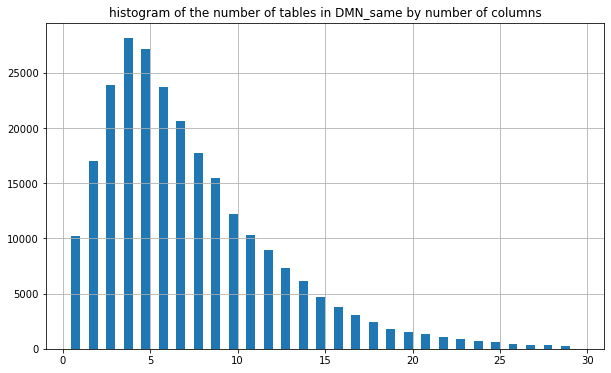

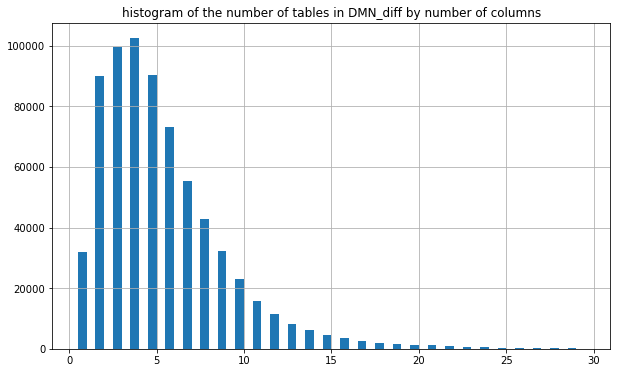

In [6]:
plt.figure(figsize = (10, 6))
DMN_same["nb_col"].hist(bins = np.arange(0.5, 30.5), width = .5)
plt.title("histogram of the number of tables in DMN_same by number of columns")
plt.show()

plt.figure(figsize = (10, 6))
DMN_diff["nb_col"].hist(bins = np.arange(0.5, 30.5), width = .5)
plt.title("histogram of the number of tables in DMN_diff by number of columns")
plt.show()

In [7]:
def compute_ml(tables):
    return pd.Series(ml_stat(tb) for tb in tqdm(tables))

def compute_DMN(tables, phi):
    stat_list = []
    for tb in tqdm(tables):
        stat_list.append(stat_DMN_moments(tb, phi))
    return pd.Series(stat_list)

In [8]:
def ROC_curve(stat_same, stat_diff, step = .05):
    
    x = np.arange(0, 1, step)
    y = []
    for alpha in x:
        threshold = stat_same.quantile(1 - alpha)
        y.append(sum(stat_diff > threshold) / len(stat_diff))
    
    return (x, np.array(y))

In [9]:
sr_same = compute_ml(DMN_same["tables"])

  0%|          | 0/253659 [00:00<?, ?it/s]

In [10]:
sr_diff = compute_ml(DMN_diff["tables"])

  0%|          | 0/703206 [00:00<?, ?it/s]

In [11]:
x, y = ROC_curve(sr_same[DMN_same["nb_col"] == 5], sr_diff[DMN_diff["nb_col"] == 5], step = 0.01)

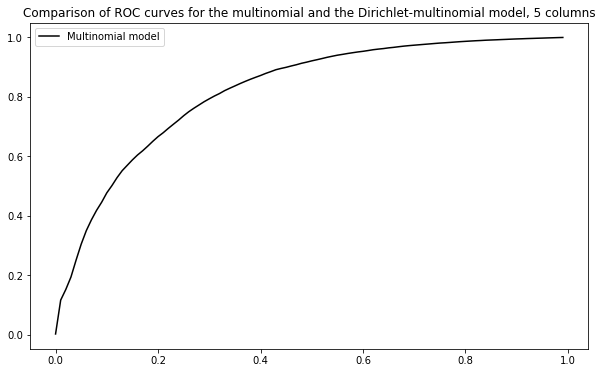

In [12]:
plt.figure(figsize = (10, 6))
plt.plot(x, y, c = "k",  label = "Multinomial model")
plt.legend()

plt.title("Comparison of ROC curves for the multinomial and the Dirichlet-multinomial model, 5 columns")
plt.show()

In [13]:
lst_phi = [1e-7, 1e-6, 1e-5, 2e-5, 5e-5, 1e-4, 2e-4, 5e-4, 1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 1e-1]
lst_strphi = [str(phi) for phi in lst_phi]

In [14]:
df_same_DMN = pd.read_csv(sub_directory + "df_same_DMN.csv")
df_diff_DMN = pd.read_csv(sub_directory + "df_diff_DMN.csv")

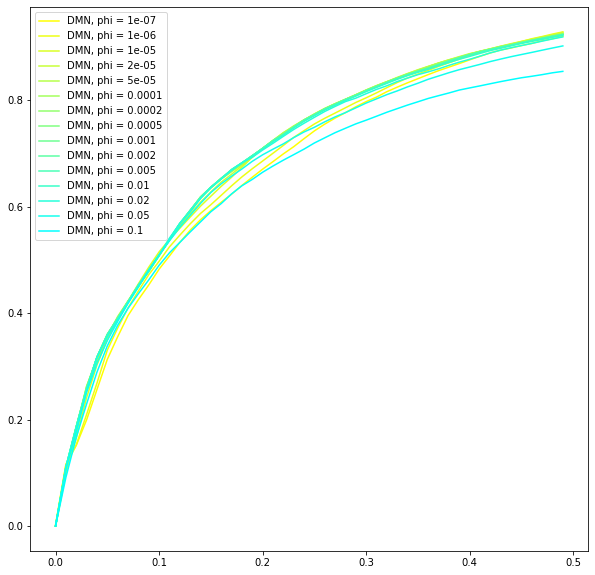

In [15]:
plt.figure(figsize = (10, 10))

power5, power10, power15 = [], [], []

for i in range(15):
    x, y = ROC_curve(df_same_DMN[lst_strphi[i]][DMN_same["nb_col"] == 5], df_diff_DMN[lst_strphi[i]][DMN_diff["nb_col"] == 5], step = 0.01)
    plt.plot(x[:50], y[:50], c = (1 - i / 14, 1, i / 14), label = "DMN, phi = " + lst_strphi[i])
    
    power5.append(y[5])
    power10.append(y[10])
    power15.append(y[15])
    
plt.legend()
plt.show()

In [16]:
power5.index(max(power5))

8

In [17]:
lst_phi[7]

0.0005

In [18]:
power10.index(max(power10))

2

In [19]:
lst_phi[2]

1e-05

In [20]:
power15.index(max(power15))

11

In [21]:
lst_phi[9]

0.002

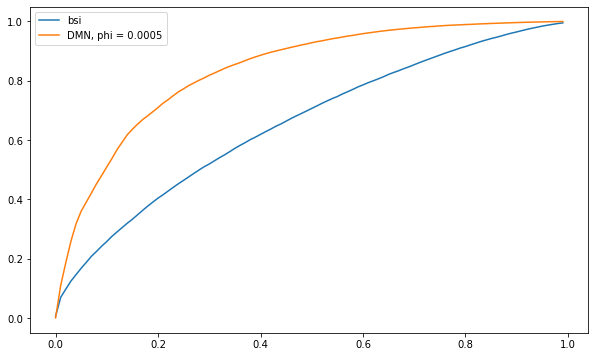

In [22]:
plt.figure(figsize = (10, 6))
x1, y1 = ROC_curve(- DMN_same["bsi"][DMN_same["nb_col"] == 5], - DMN_diff["bsi"][DMN_diff["nb_col"] == 5], step = 0.01)
plt.plot(x1, y1, label = "bsi")

x2, y2 = ROC_curve(df_same_DMN[lst_strphi[7]][DMN_same["nb_col"] == 5], df_diff_DMN[lst_strphi[7]][DMN_diff["nb_col"] == 5], step = 0.01)
plt.plot(x2, y2, label = "DMN, phi = " + lst_strphi[7])

plt.legend()
plt.show()

In [23]:
lst_strphi

['1e-07',
 '1e-06',
 '1e-05',
 '2e-05',
 '5e-05',
 '0.0001',
 '0.0002',
 '0.0005',
 '0.001',
 '0.002',
 '0.005',
 '0.01',
 '0.02',
 '0.05',
 '0.1']

In [24]:
len(lst_strphi)

15

In [25]:
lst_latexphi = ["" for i in range(15)]
lst_latexphi[0] = r"DMN, $\varphi = 10^{-7}$"
lst_latexphi[2] = r"DMN, $\varphi = 10^{-4}$"
lst_latexphi[8] = r"DMN, $\varphi = 10^{-2}$"
lst_latexphi[14] = r"DMN, $\varphi = 10^{-1}$"

In [26]:
lst_colors = [0 for i in range(15)]
lst_colors[0] = "red"
lst_colors[2] = "orange"
lst_colors[8] = "blue"
lst_colors[14] = "cyan"

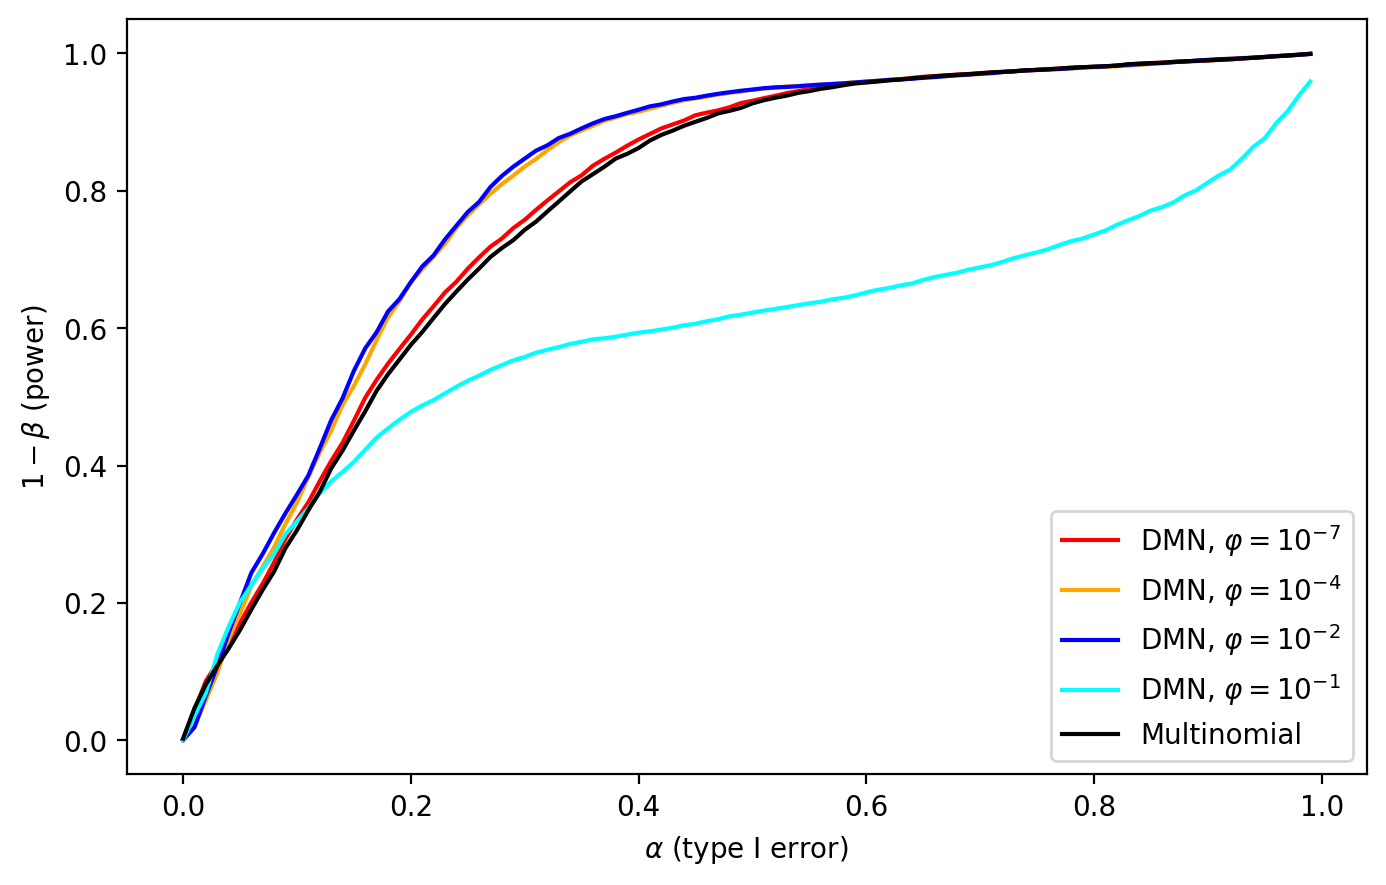

In [27]:
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["figure.dpi"] = 200

nb_col = 12

power5, power10, power15 = [], [], []

for i in [0, 2, 8, 14]:
    x, y = ROC_curve(df_same_DMN[lst_strphi[i]][DMN_same["nb_col"] == nb_col],
                     df_diff_DMN[lst_strphi[i]][DMN_diff["nb_col"] == nb_col],
                     step = 0.01
                    )
    plt.plot(x, y, c = lst_colors[i], label = lst_latexphi[i])
    
    power5.append(y[5])
    power10.append(y[10])
    power15.append(y[15])
    
x, y = ROC_curve(sr_same[DMN_same["nb_col"] == nb_col], sr_diff[DMN_diff["nb_col"] == nb_col], step = 0.01)
plt.plot(x, y, color = "k", label = "Multinomial")

plt.xlabel(r"$\alpha$ (type I error)")
plt.ylabel(r"$1 - \beta$ (power)")
plt.legend()
plt.show()

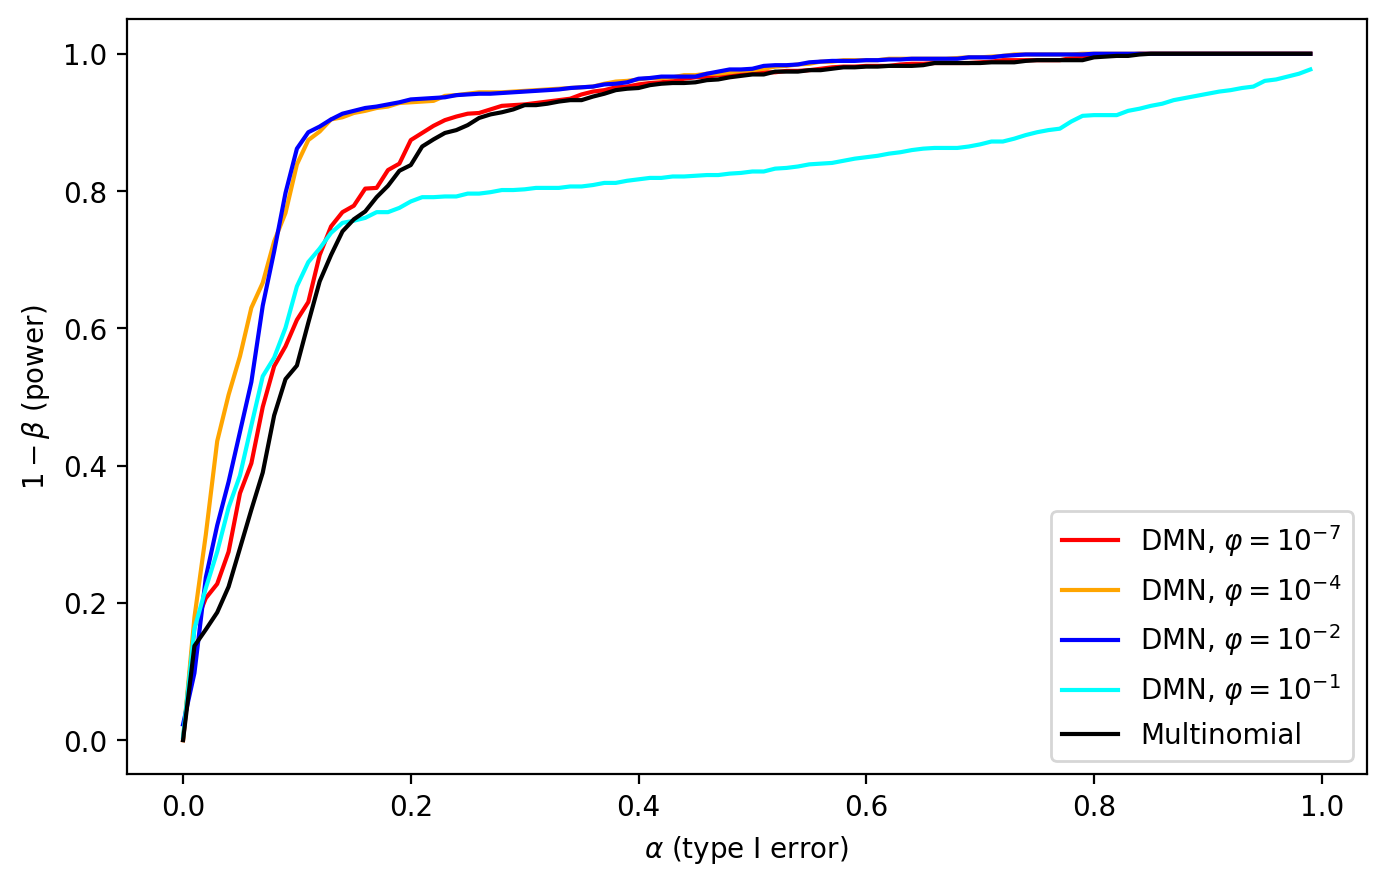

In [28]:
nb_col = 12

power5, power10, power15 = [], [], []

sel_same = np.logical_and(np.array(DMN_same["nb_col"]) == nb_col, np.array(DMN_same["mq"]) > 0.85)
sel_diff = np.logical_and(np.array(DMN_diff["nb_col"]) == nb_col, np.array([max(x) for x in DMN_diff["mq"]]) > 0.85)


for i in [0, 2, 8, 14]:
    x, y = ROC_curve(df_same_DMN[lst_strphi[i]][sel_same],
                     df_diff_DMN[lst_strphi[i]][sel_diff],
                     step = 0.01
                    )
    plt.plot(x, y, c = lst_colors[i], label = lst_latexphi[i])
    
    power5.append(y[5])
    power10.append(y[10])
    power15.append(y[15])
    
x, y = ROC_curve(sr_same[sel_same], sr_diff[sel_diff], step = 0.01)
plt.plot(x, y, color = "k", label = "Multinomial")

plt.xlabel(r"$\alpha$ (type I error)")
plt.ylabel(r"$1 - \beta$ (power)")
plt.legend()
plt.show()

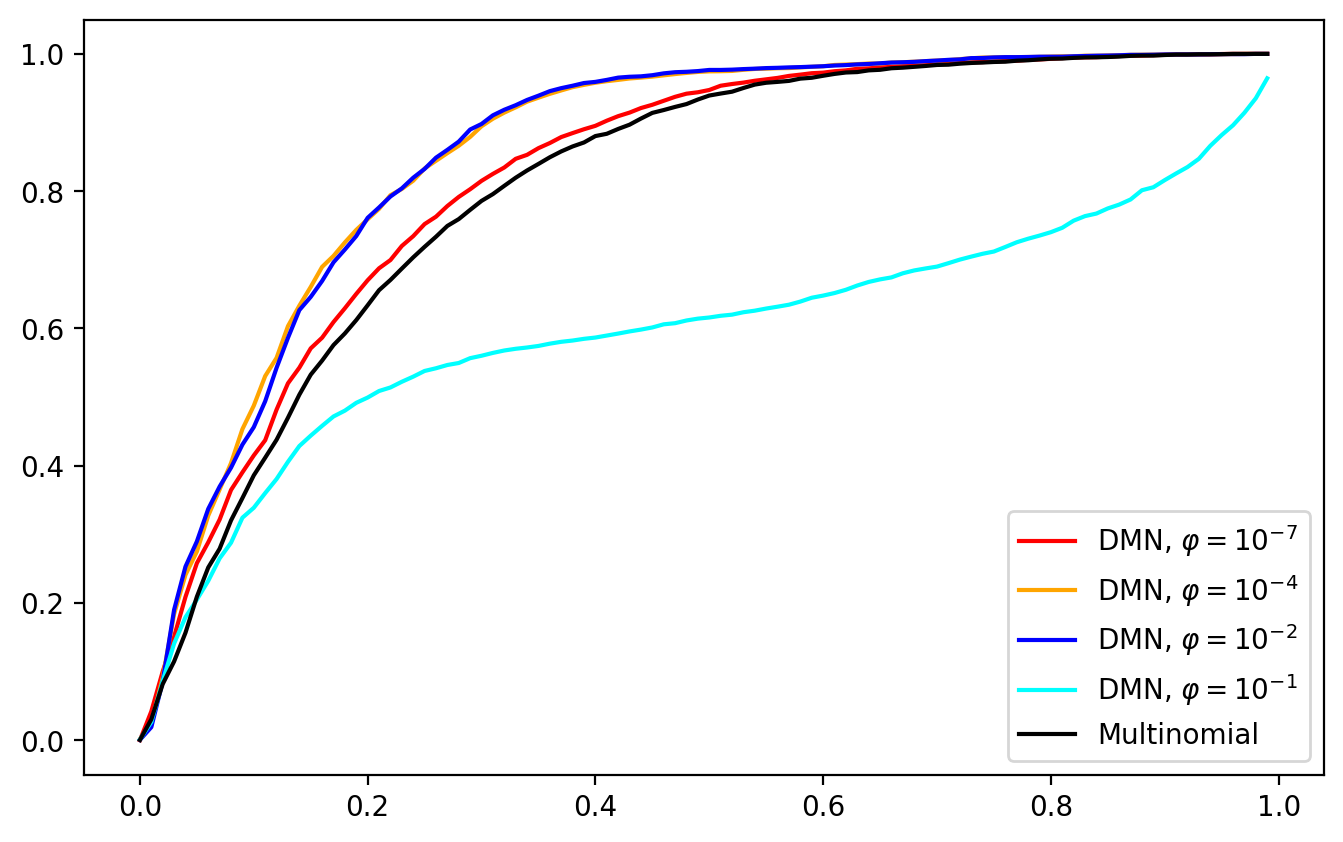

In [29]:

nb_col = 12


power5, power10, power15 = [], [], []

sel_same = np.logical_and(np.array(DMN_same["nb_col"]) == nb_col, np.array(DMN_same["mq"]) > 0.1)
sel_diff = np.logical_and(np.array(DMN_diff["nb_col"]) == nb_col, np.array([max(x) for x in DMN_diff["mq"]]) > 0.1)


for i in [0, 2, 8, 14]:
    x, y = ROC_curve(df_same_DMN[lst_strphi[i]][sel_same],
                     df_diff_DMN[lst_strphi[i]][sel_diff],
                     step = 0.01
                    )
    plt.plot(x, y, c = lst_colors[i], label = lst_latexphi[i])
    
    power5.append(y[5])
    power10.append(y[10])
    power15.append(y[15])
    
x, y = ROC_curve(sr_same[sel_same], sr_diff[sel_diff], step = 0.01)
plt.plot(x, y, color = "k", label = "Multinomial")
    
plt.legend()
plt.show()

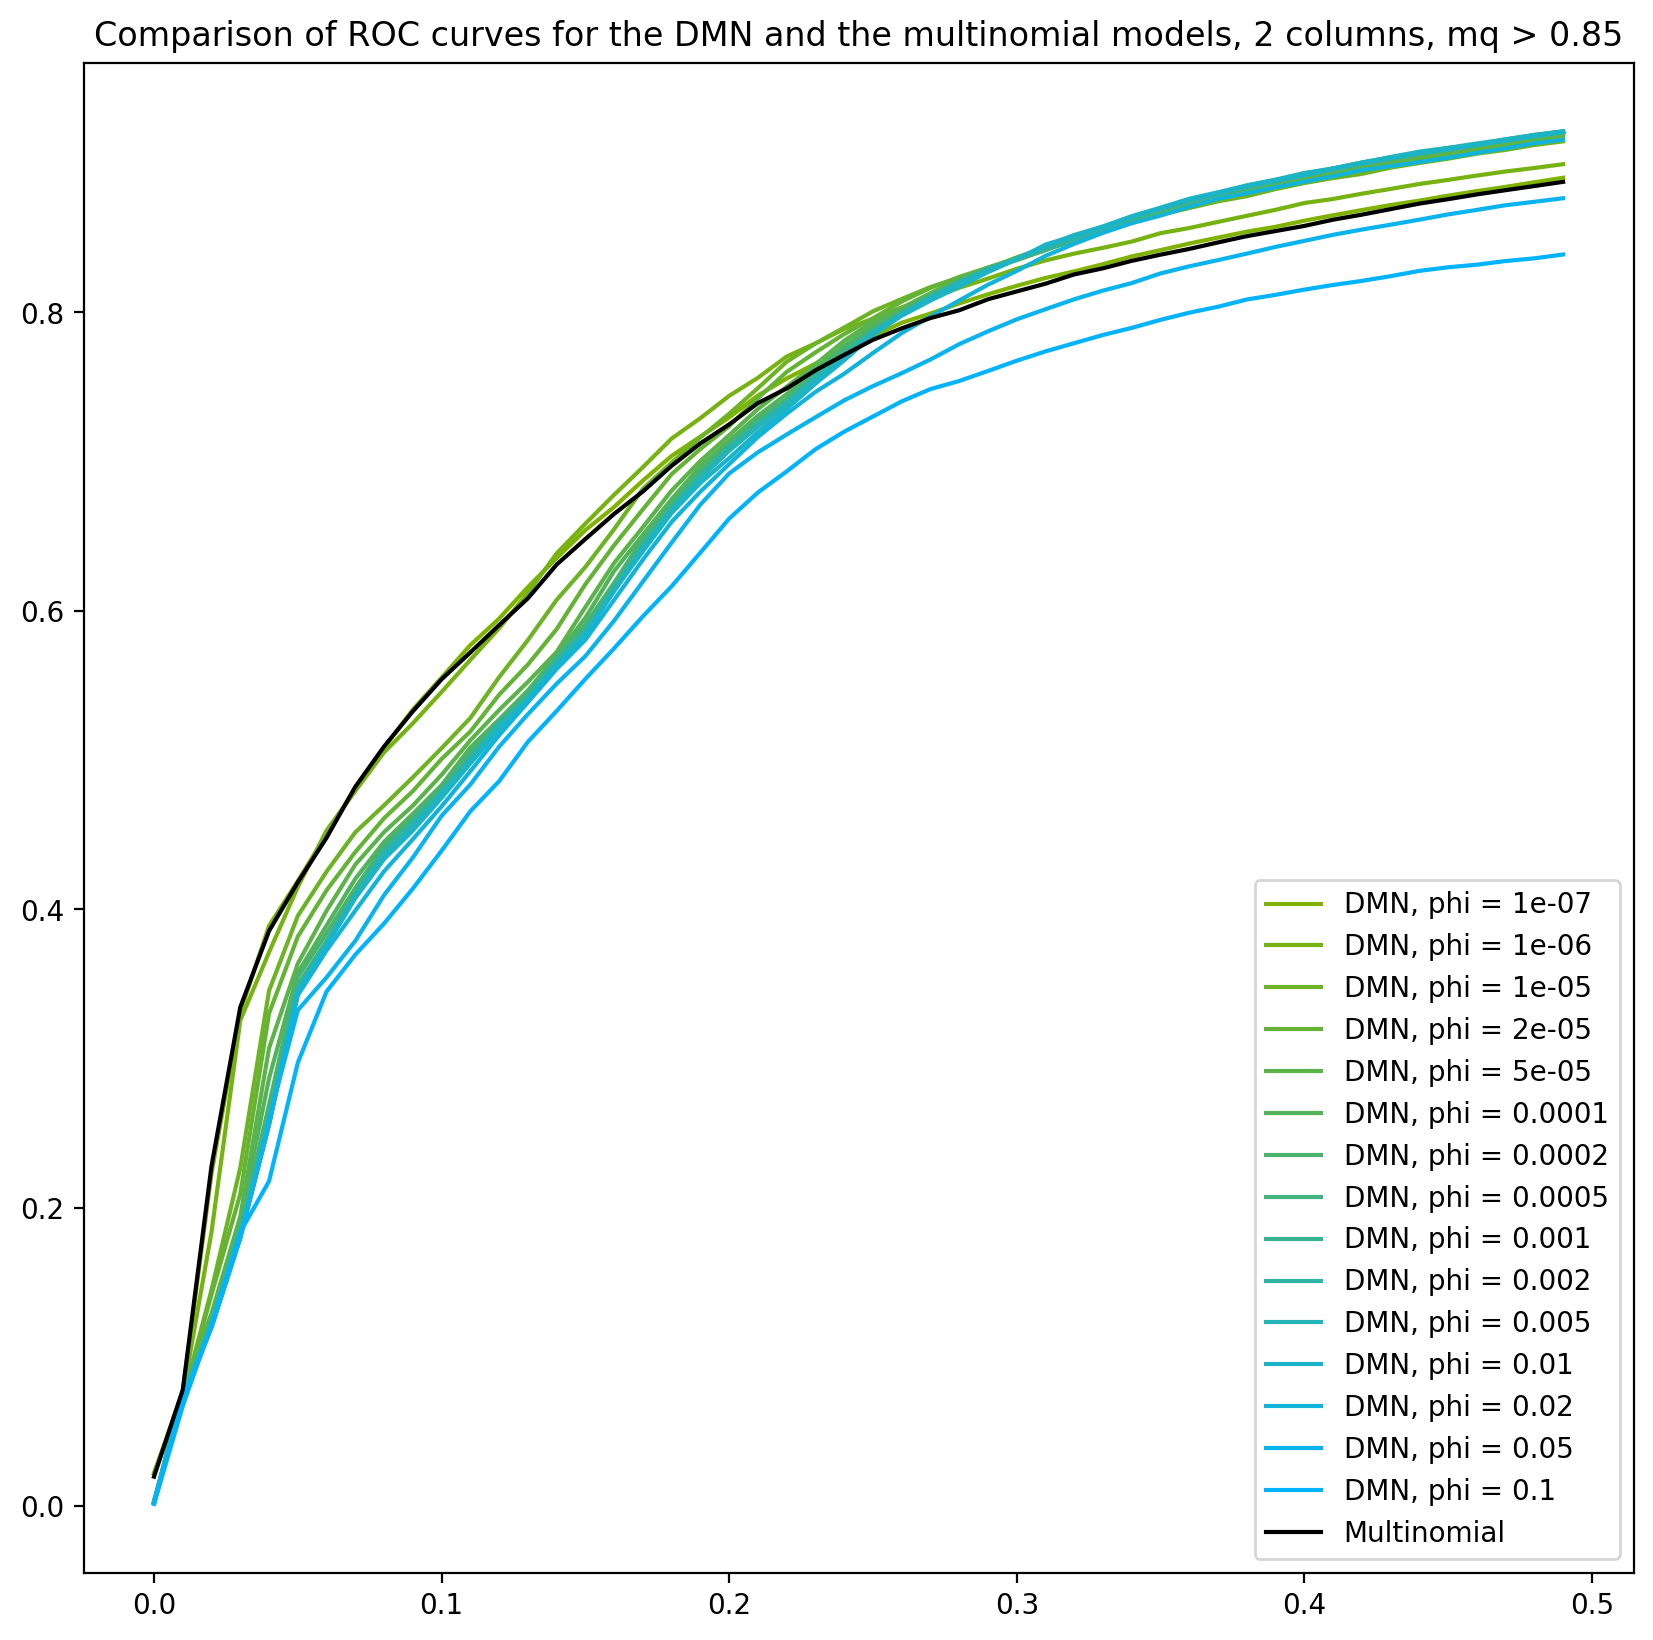

In [30]:
nb_col = 2

plt.figure(figsize = (10, 10))

power5, power10, power15 = [], [], []

sel_same = np.logical_and(np.array(DMN_same["nb_col"]) == nb_col, np.array(DMN_same["mq"]) > 0.85)
sel_diff = np.logical_and(np.array(DMN_diff["nb_col"]) == nb_col, np.array([max(x) for x in DMN_diff["mq"]]) > 0.85)

for i in range(15):
    x, y = ROC_curve(df_same_DMN[lst_strphi[i]][sel_same],
                     df_diff_DMN[lst_strphi[i]][sel_diff],
                     step = 0.01
                    )
    plt.plot(x[:50], y[:50], c = (0.5 - i / 28, .7, i / 14), label = "DMN, phi = " + lst_strphi[i])
    
    power5.append(y[5])
    power10.append(y[10])
    power15.append(y[15])
    
x, y = ROC_curve(sr_same[sel_same], sr_diff[sel_diff], step = 0.01)
plt.plot(x[:50], y[:50], color = "k", label = "Multinomial")
    
plt.legend()
plt.title("Comparison of ROC curves for the DMN and the multinomial models, " + str(nb_col) + " columns, mq > 0.85")
plt.show()

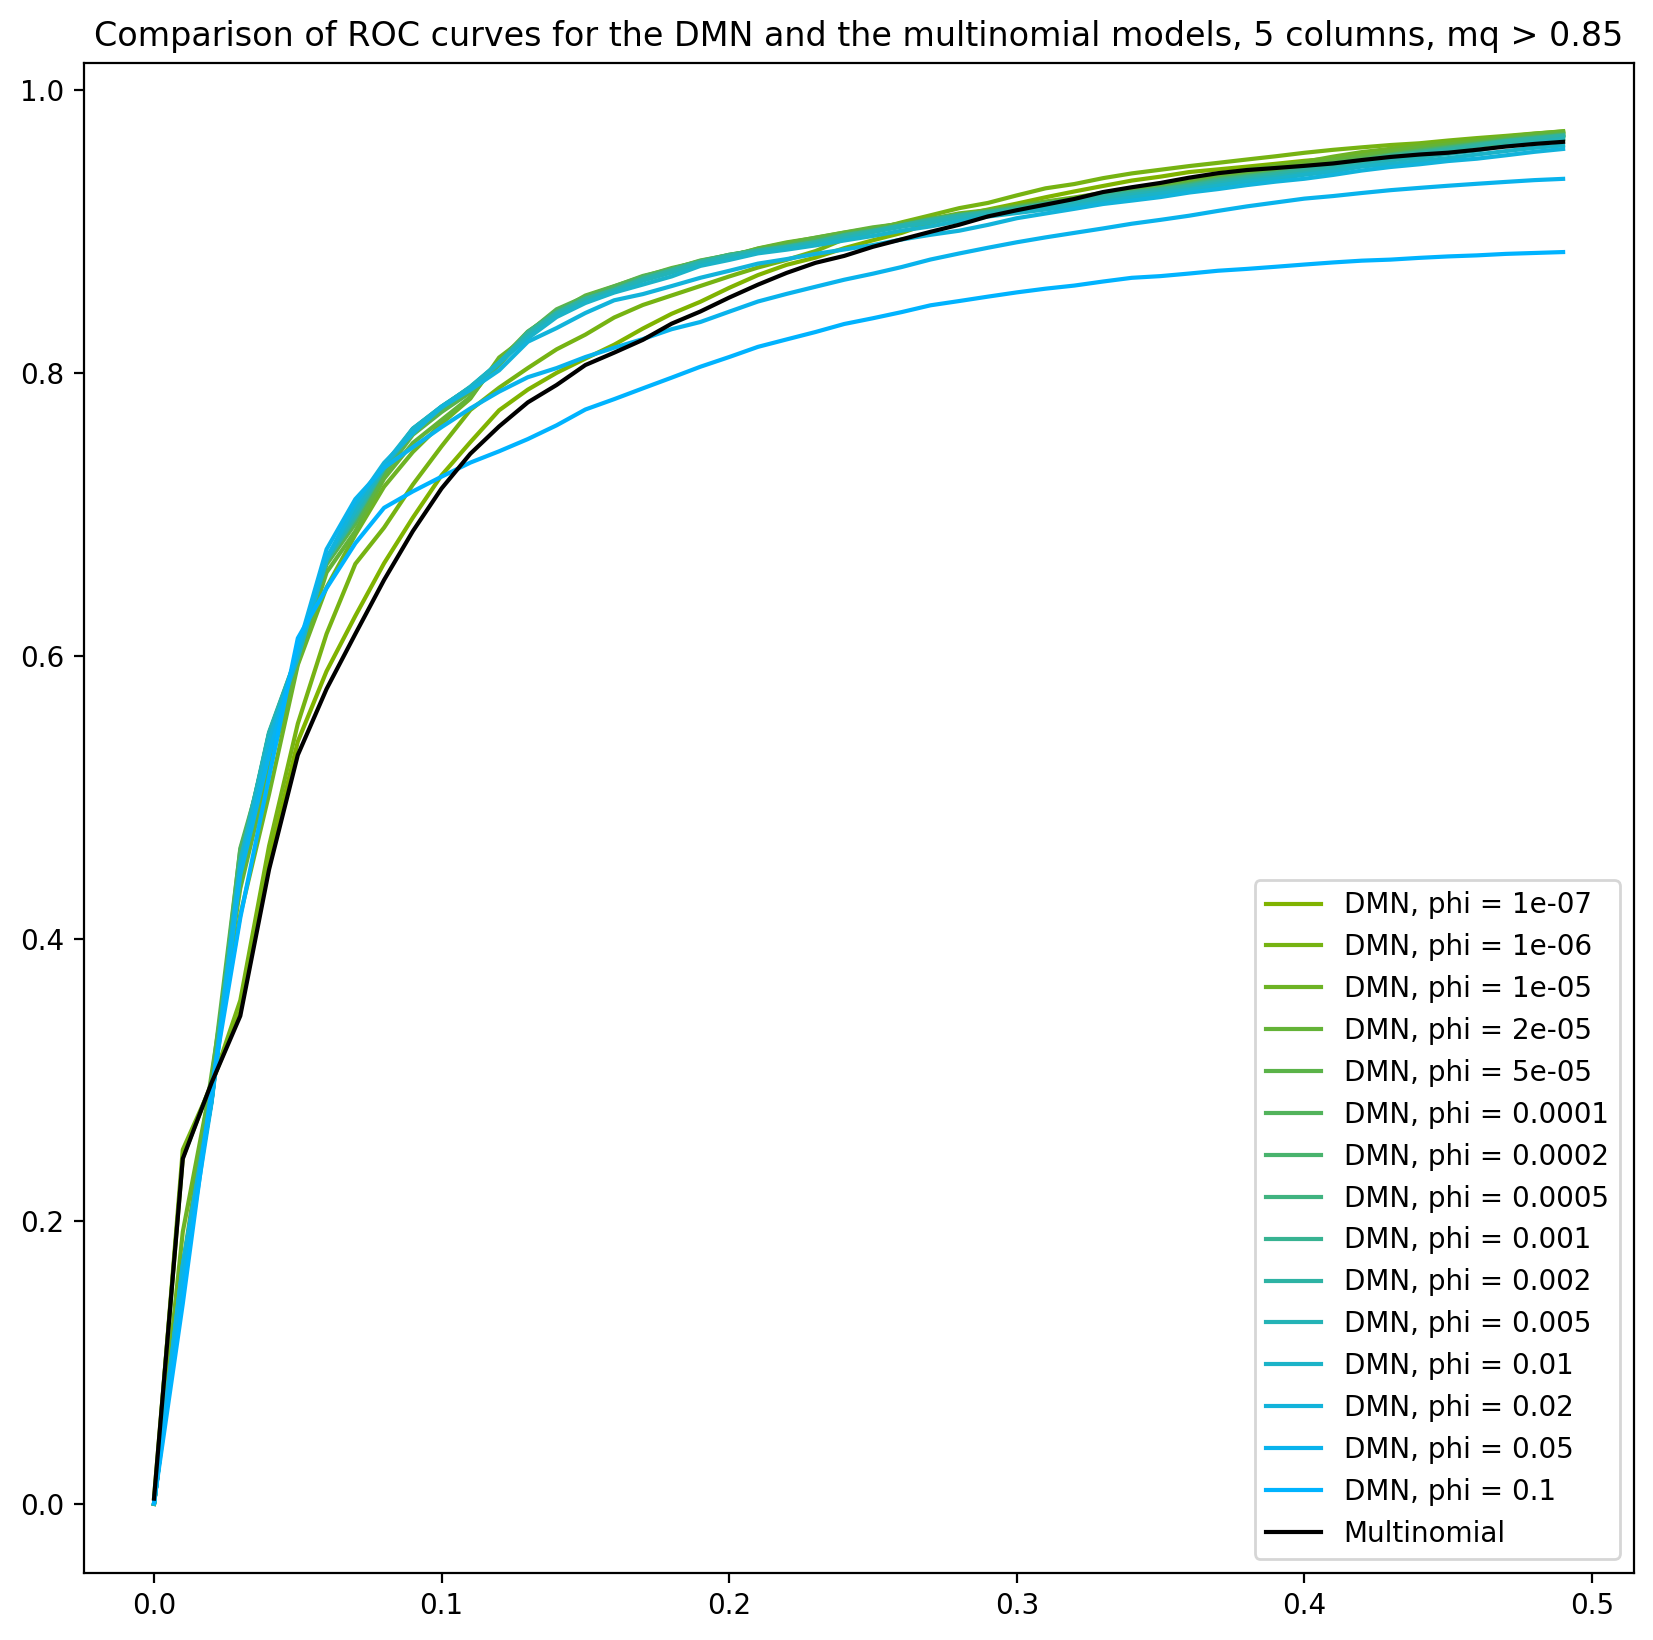

In [31]:
nb_col = 5

plt.figure(figsize = (10, 10))

power5, power10, power15 = [], [], []

sel_same = np.logical_and(np.array(DMN_same["nb_col"]) == nb_col, np.array(DMN_same["mq"]) > 0.85)
sel_diff = np.logical_and(np.array(DMN_diff["nb_col"]) == nb_col, np.array([max(x) for x in DMN_diff["mq"]]) > 0.85)

for i in range(15):
    x, y = ROC_curve(df_same_DMN[lst_strphi[i]][sel_same],
                     df_diff_DMN[lst_strphi[i]][sel_diff],
                     step = 0.01
                    )
    plt.plot(x[:50], y[:50], c = (0.5 - i / 28, .7, i / 14), label = "DMN, phi = " + lst_strphi[i])
    
    power5.append(y[5])
    power10.append(y[10])
    power15.append(y[15])
    
x, y = ROC_curve(sr_same[sel_same], sr_diff[sel_diff], step = 0.01)
plt.plot(x[:50], y[:50], color = "k", label = "Multinomial")
    
plt.legend()
plt.title("Comparison of ROC curves for the DMN and the multinomial models, " + str(nb_col) + " columns, mq > 0.85")
plt.show()

In [32]:
power5

[0.539368863088989,
 0.5519977768171432,
 0.5936207003025998,
 0.5947014141913173,
 0.5993021676032854,
 0.600876922126845,
 0.6005063916507133,
 0.600784289507812,
 0.6017106156981412,
 0.6017106156981412,
 0.5996109430000618,
 0.5984375964923115,
 0.6028530846662138,
 0.604891002284938,
 0.6124251219662817]

In [33]:
power10

[0.7276909775829062,
 0.7482245414685358,
 0.7642808621009078,
 0.7668436978941517,
 0.772463410115482,
 0.7746557154325944,
 0.7753350213055024,
 0.7757673068609893,
 0.7761378373371209,
 0.7763539801148645,
 0.7756129191626011,
 0.7763231025751868,
 0.7760143271784105,
 0.7617797813870191,
 0.7267337738528994]

In [34]:
power15

[0.8102266411412339,
 0.8271784104242574,
 0.8528685234360526,
 0.8548446859754215,
 0.8541036250231582,
 0.8533008089915396,
 0.8526215031186315,
 0.852405360340888,
 0.8523127277218551,
 0.8524671154202433,
 0.8503056876428087,
 0.8495646266905453,
 0.842493670104366,
 0.8113382325696289,
 0.7742234298771073]

In [35]:
lst_phi[4:]

[5e-05, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1]

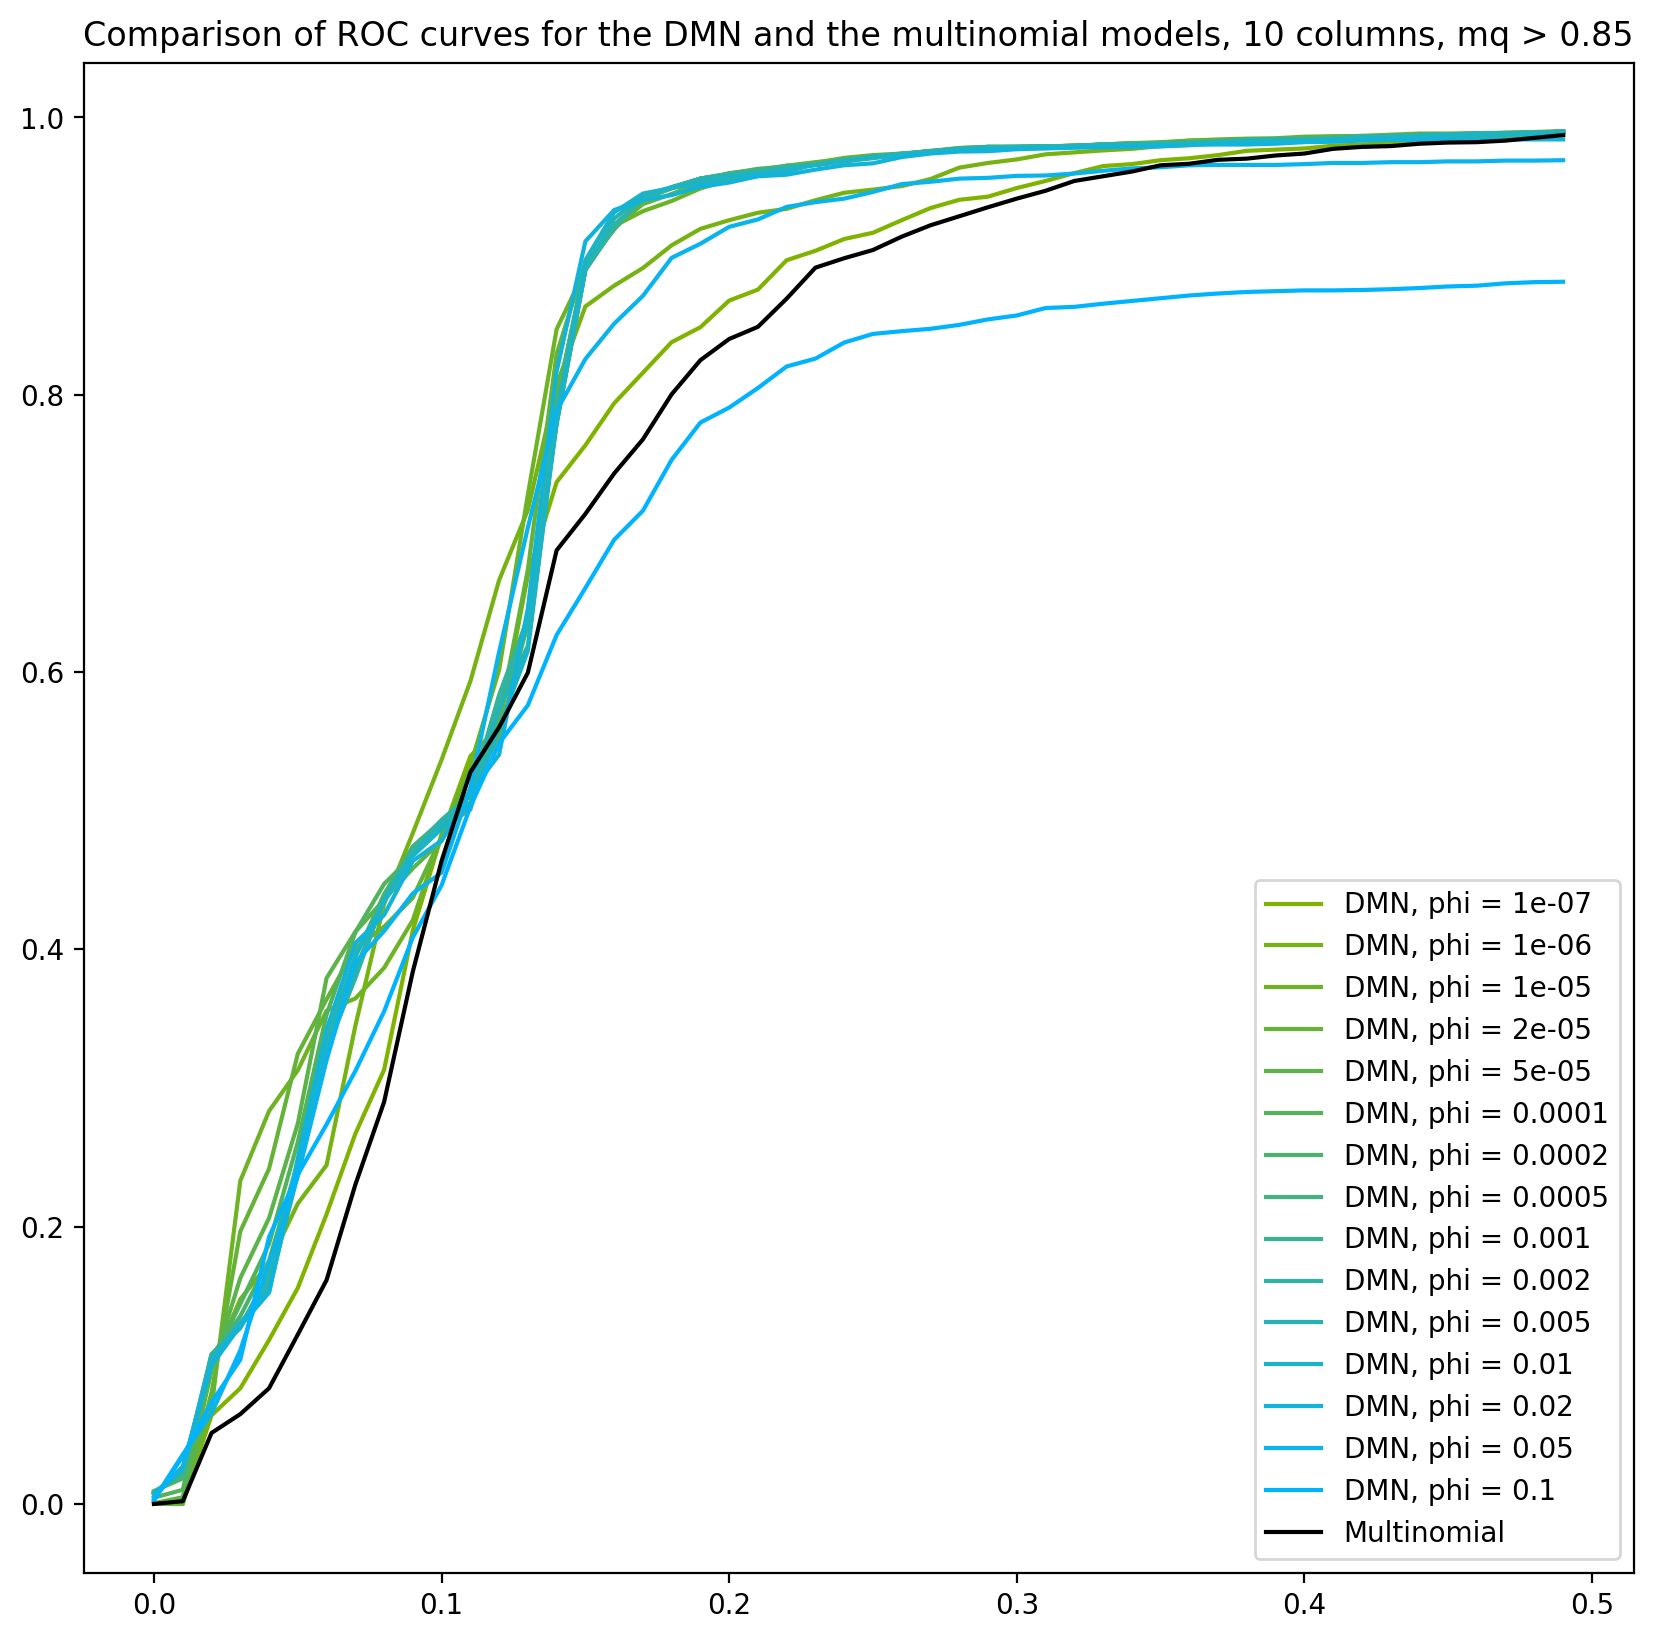

In [36]:
nb_col = 10

plt.figure(figsize = (10, 10))

power5, power10, power20 = [], [], []
level80, level90 = [], []

sel_same = np.logical_and(np.array(DMN_same["nb_col"]) == nb_col, np.array(DMN_same["mq"]) > 0.85)
sel_diff = np.logical_and(np.array(DMN_diff["nb_col"]) == nb_col, np.array([max(x) for x in DMN_diff["mq"]]) > 0.85)

for i in range(15):
    x, y = ROC_curve(df_same_DMN[lst_strphi[i]][sel_same],
                     df_diff_DMN[lst_strphi[i]][sel_diff],
                     step = 0.01
                    )
    plt.plot(x[:50], y[:50], c = (0.5 - i / 28, .7, i / 14), label = "DMN, phi = " + lst_strphi[i])
    
    power5.append(y[5])
    power10.append(y[10])
    power20.append(y[20])
    
    level80.append(sum(y < 0.8) / 100)
    level90.append(sum(y < 0.9) / 100)
    
x, y = ROC_curve(sr_same[sel_same], sr_diff[sel_diff], step = 0.01)
plt.plot(x[:50], y[:50], color = "k", label = "Multinomial")
    
plt.legend()
plt.title("Comparison of ROC curves for the DMN and the multinomial models, " + str(nb_col) + " columns, mq > 0.85")
plt.show()

In [37]:
level80

[0.17,
 0.14,
 0.14,
 0.14,
 0.15,
 0.15,
 0.15,
 0.15,
 0.15,
 0.15,
 0.15,
 0.15,
 0.14,
 0.15,
 0.21]

In [38]:
level90

[0.23,
 0.18,
 0.16,
 0.16,
 0.16,
 0.16,
 0.16,
 0.16,
 0.16,
 0.16,
 0.16,
 0.16,
 0.15,
 0.19,
 0.67]

In [39]:
power20

[0.8679298642533937,
 0.9259049773755657,
 0.9550339366515838,
 0.9595588235294118,
 0.959841628959276,
 0.9595588235294118,
 0.9592760180995475,
 0.9592760180995475,
 0.9589932126696833,
 0.958710407239819,
 0.9584276018099548,
 0.956447963800905,
 0.9530542986425339,
 0.9210972850678733,
 0.7907239819004525]

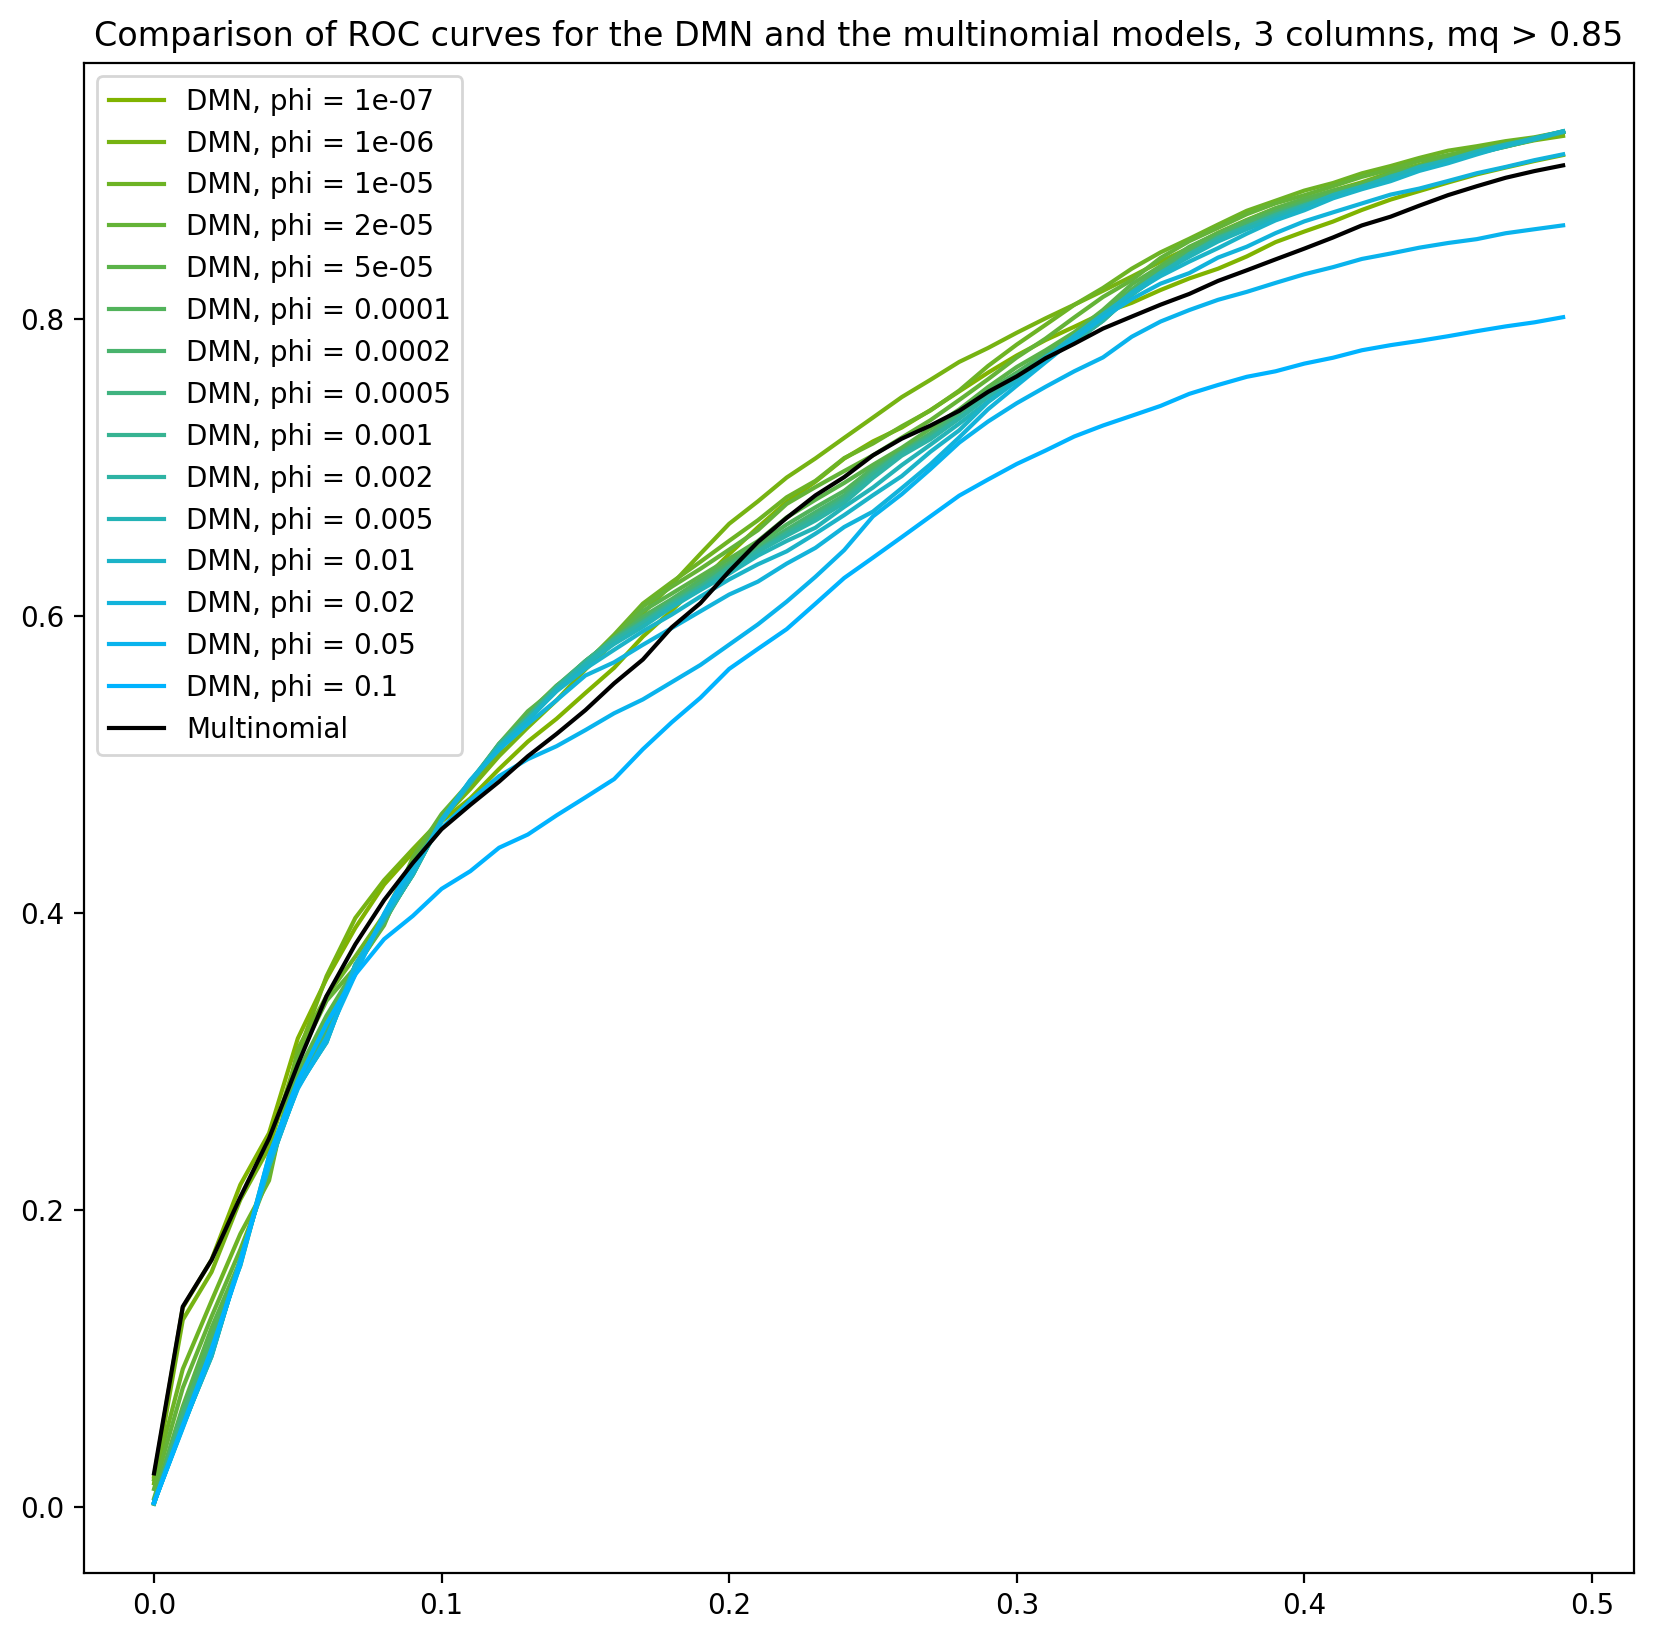

In [40]:
nb_col = 3

plt.figure(figsize = (10, 10))

power5, power10, power20 = [], [], []
level80, level90 = [], []

sel_same = np.logical_and(np.array(DMN_same["nb_col"]) == nb_col, np.array(DMN_same["mq"]) > 0.85)
sel_diff = np.logical_and(np.array(DMN_diff["nb_col"]) == nb_col, np.array([max(x) for x in DMN_diff["mq"]]) > 0.85)

for i in range(15):
    x, y = ROC_curve(df_same_DMN[lst_strphi[i]][sel_same],
                     df_diff_DMN[lst_strphi[i]][sel_diff],
                     step = 0.01
                    )
    plt.plot(x[:50], y[:50], c = (0.5 - i / 28, .7, i / 14), label = "DMN, phi = " + lst_strphi[i])
    
    power5.append(y[5])
    power10.append(y[10])
    power20.append(y[20])
    
    level80.append(sum(y < 0.8) / 100)
    level90.append(sum(y < 0.9) / 100)
    
x, y = ROC_curve(sr_same[sel_same], sr_diff[sel_diff], step = 0.01)
plt.plot(x[:50], y[:50], color = "k", label = "Multinomial")
    
plt.legend()
plt.title("Comparison of ROC curves for the DMN and the multinomial models, " + str(nb_col) + " columns, mq > 0.85")
plt.show()

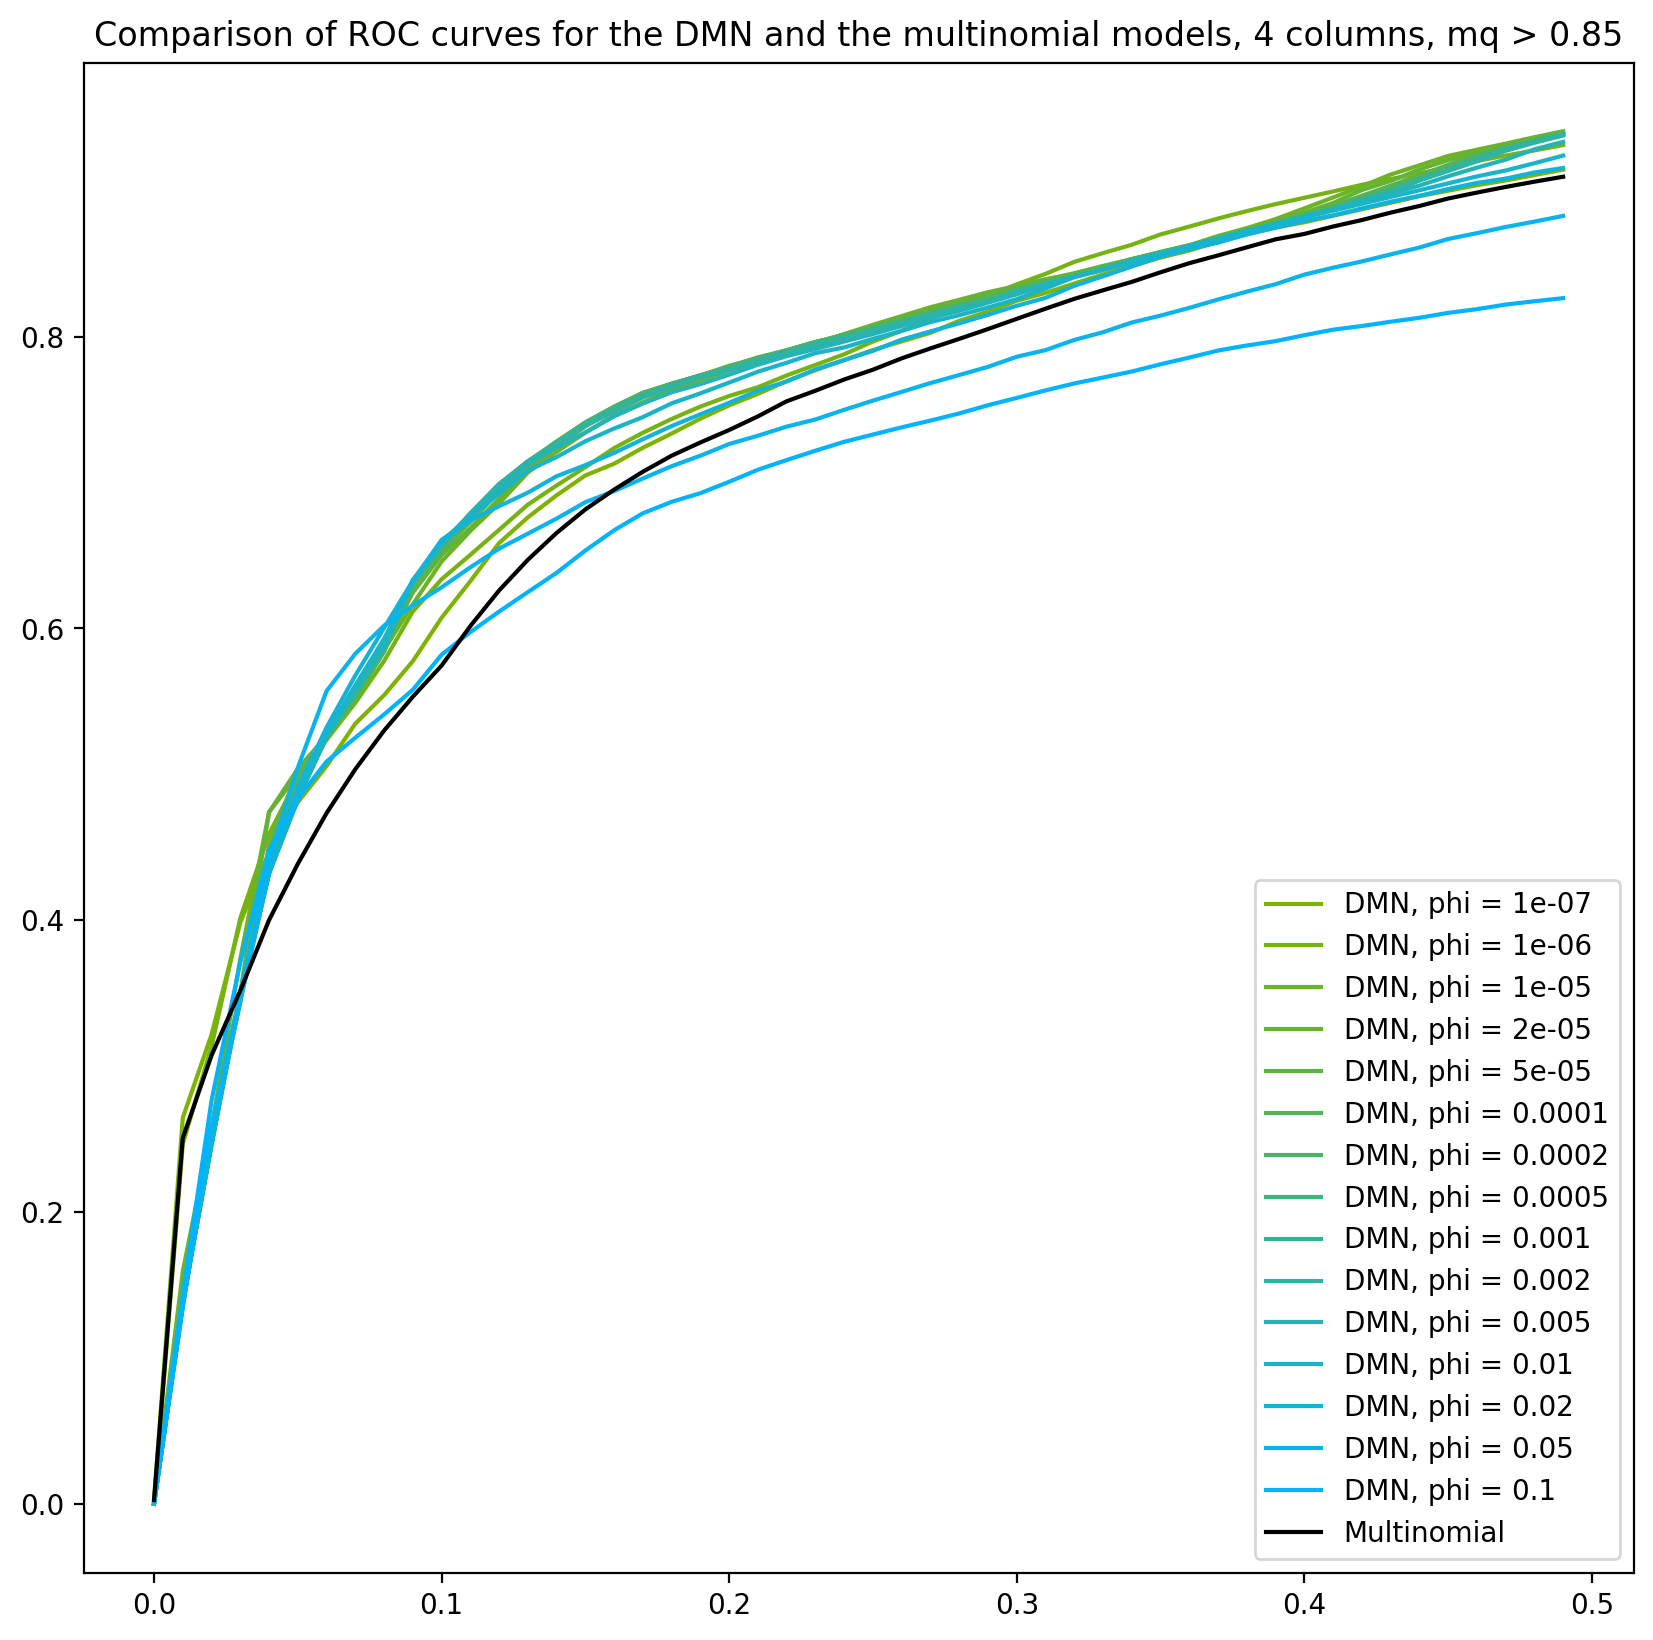

In [41]:
nb_col = 4

plt.figure(figsize = (10, 10))

power5, power10, power20 = [], [], []
level80, level90 = [], []

sel_same = np.logical_and(np.array(DMN_same["nb_col"]) == nb_col, np.array(DMN_same["mq"]) > 0.85)
sel_diff = np.logical_and(np.array(DMN_diff["nb_col"]) == nb_col, np.array([max(x) for x in DMN_diff["mq"]]) > 0.85)

for i in range(15):
    x, y = ROC_curve(df_same_DMN[lst_strphi[i]][sel_same],
                     df_diff_DMN[lst_strphi[i]][sel_diff],
                     step = 0.01
                    )
    plt.plot(x[:50], y[:50], c = (0.5 - i / 28, .7, i / 14), label = "DMN, phi = " + lst_strphi[i])
    
    power5.append(y[5])
    power10.append(y[10])
    power20.append(y[20])
    
    level80.append(sum(y < 0.8) / 100)
    level90.append(sum(y < 0.9) / 100)
    
x, y = ROC_curve(sr_same[sel_same], sr_diff[sel_diff], step = 0.01)
plt.plot(x[:50], y[:50], color = "k", label = "Multinomial")
    
plt.legend()
plt.title("Comparison of ROC curves for the DMN and the multinomial models, " + str(nb_col) + " columns, mq > 0.85")
plt.show()

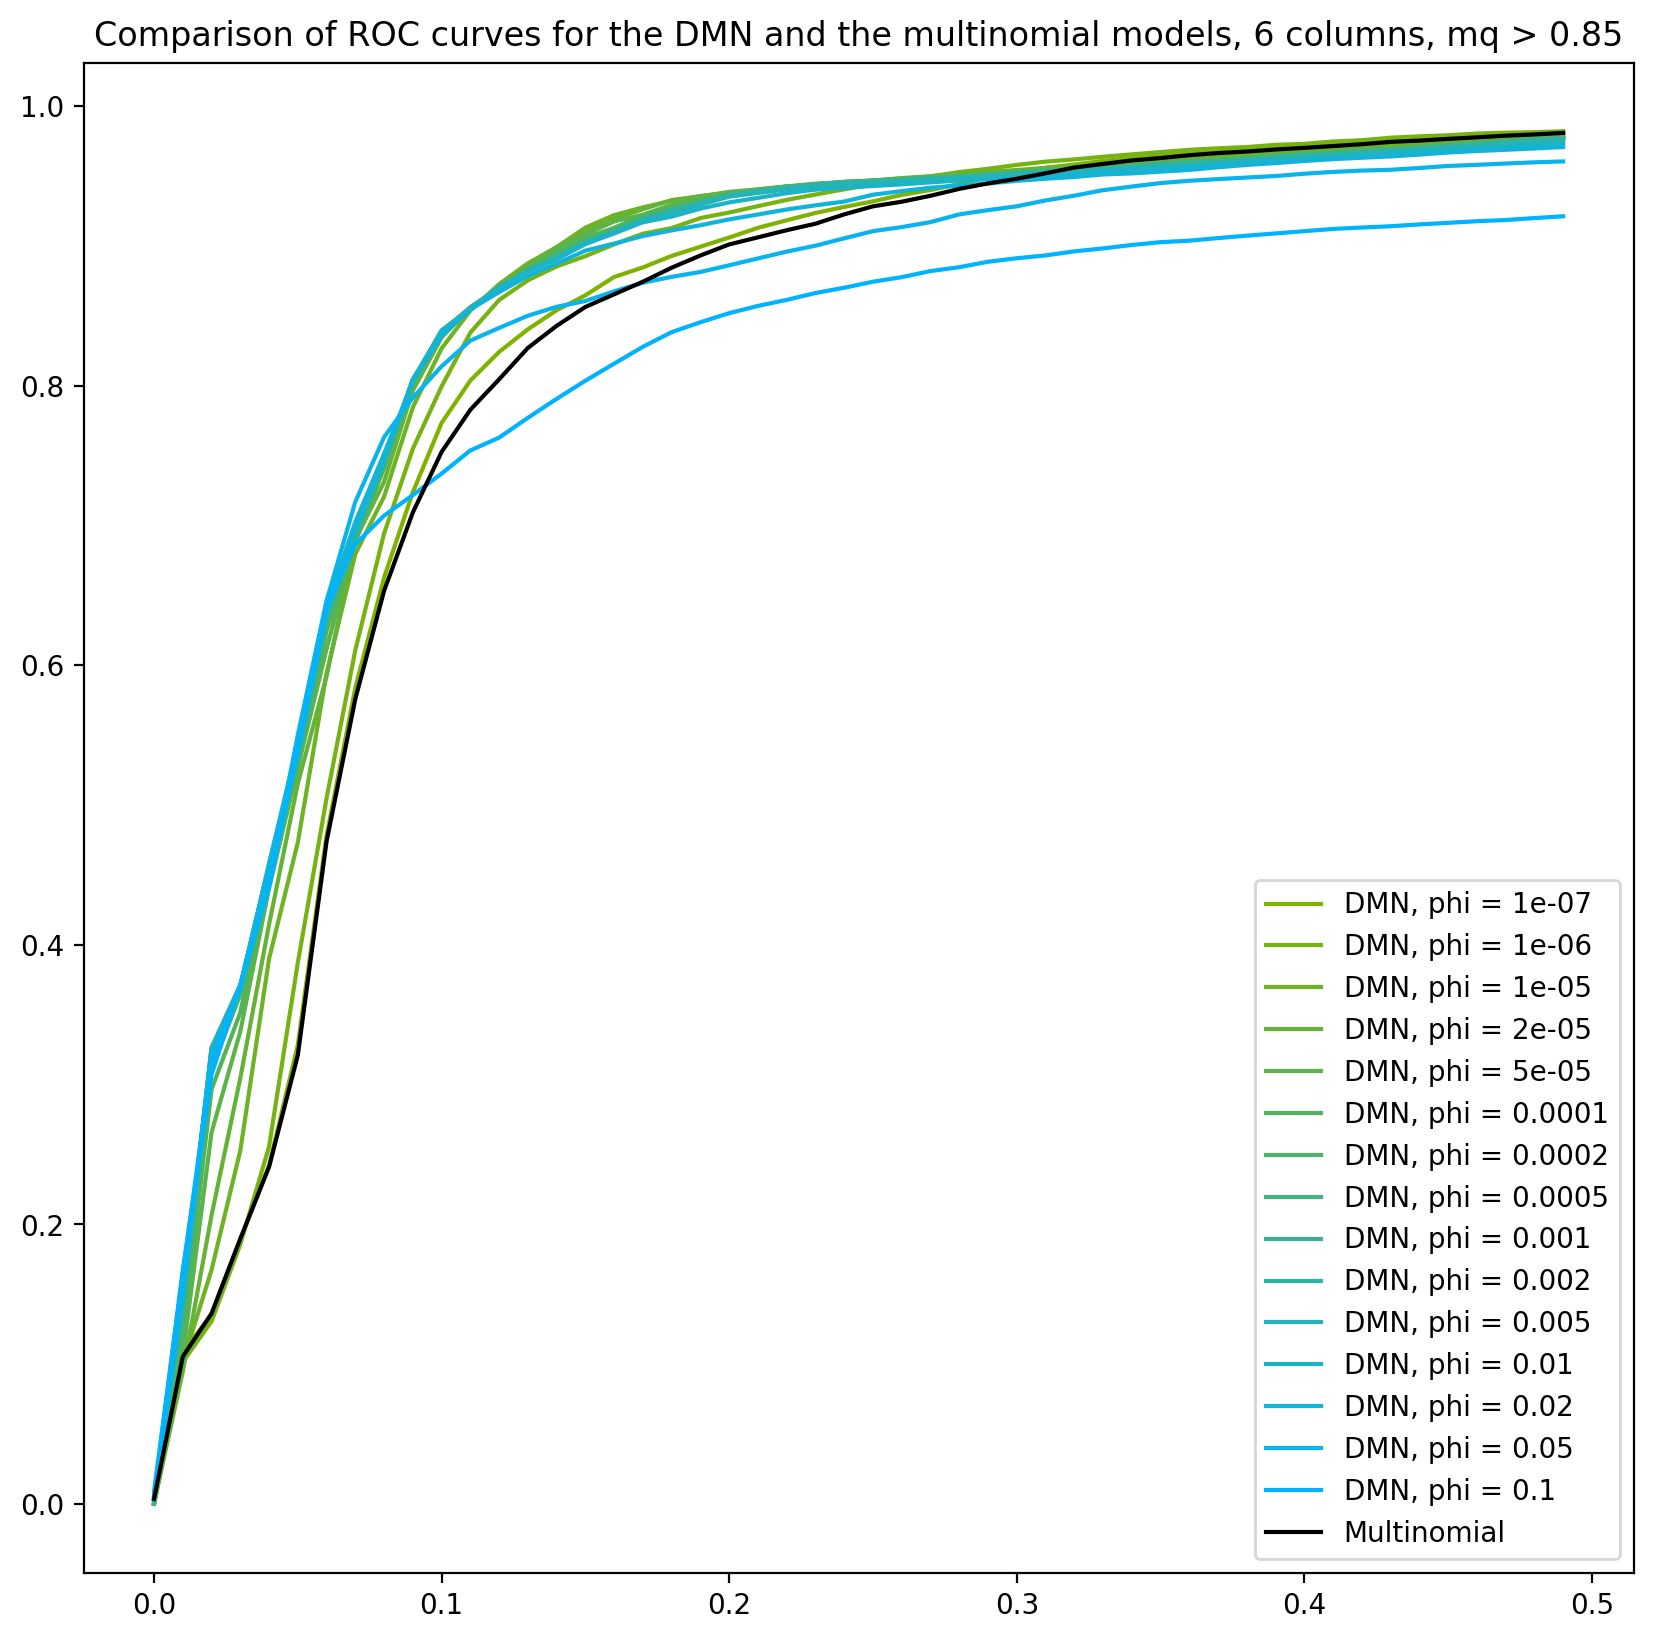

In [42]:
nb_col = 6

plt.figure(figsize = (10, 10))

power5, power10, power20 = [], [], []
level80, level90 = [], []

sel_same = np.logical_and(np.array(DMN_same["nb_col"]) == nb_col, np.array(DMN_same["mq"]) > 0.85)
sel_diff = np.logical_and(np.array(DMN_diff["nb_col"]) == nb_col, np.array([max(x) for x in DMN_diff["mq"]]) > 0.85)

for i in range(15):
    x, y = ROC_curve(df_same_DMN[lst_strphi[i]][sel_same],
                     df_diff_DMN[lst_strphi[i]][sel_diff],
                     step = 0.01
                    )
    plt.plot(x[:50], y[:50], c = (0.5 - i / 28, .7, i / 14), label = "DMN, phi = " + lst_strphi[i])
    
    power5.append(y[5])
    power10.append(y[10])
    power20.append(y[20])
    
    level80.append(sum(y < 0.8) / 100)
    level90.append(sum(y < 0.9) / 100)
    
x, y = ROC_curve(sr_same[sel_same], sr_diff[sel_diff], step = 0.01)
plt.plot(x[:50], y[:50], color = "k", label = "Multinomial")
    
plt.legend()
plt.title("Comparison of ROC curves for the DMN and the multinomial models, " + str(nb_col) + " columns, mq > 0.85")
plt.show()

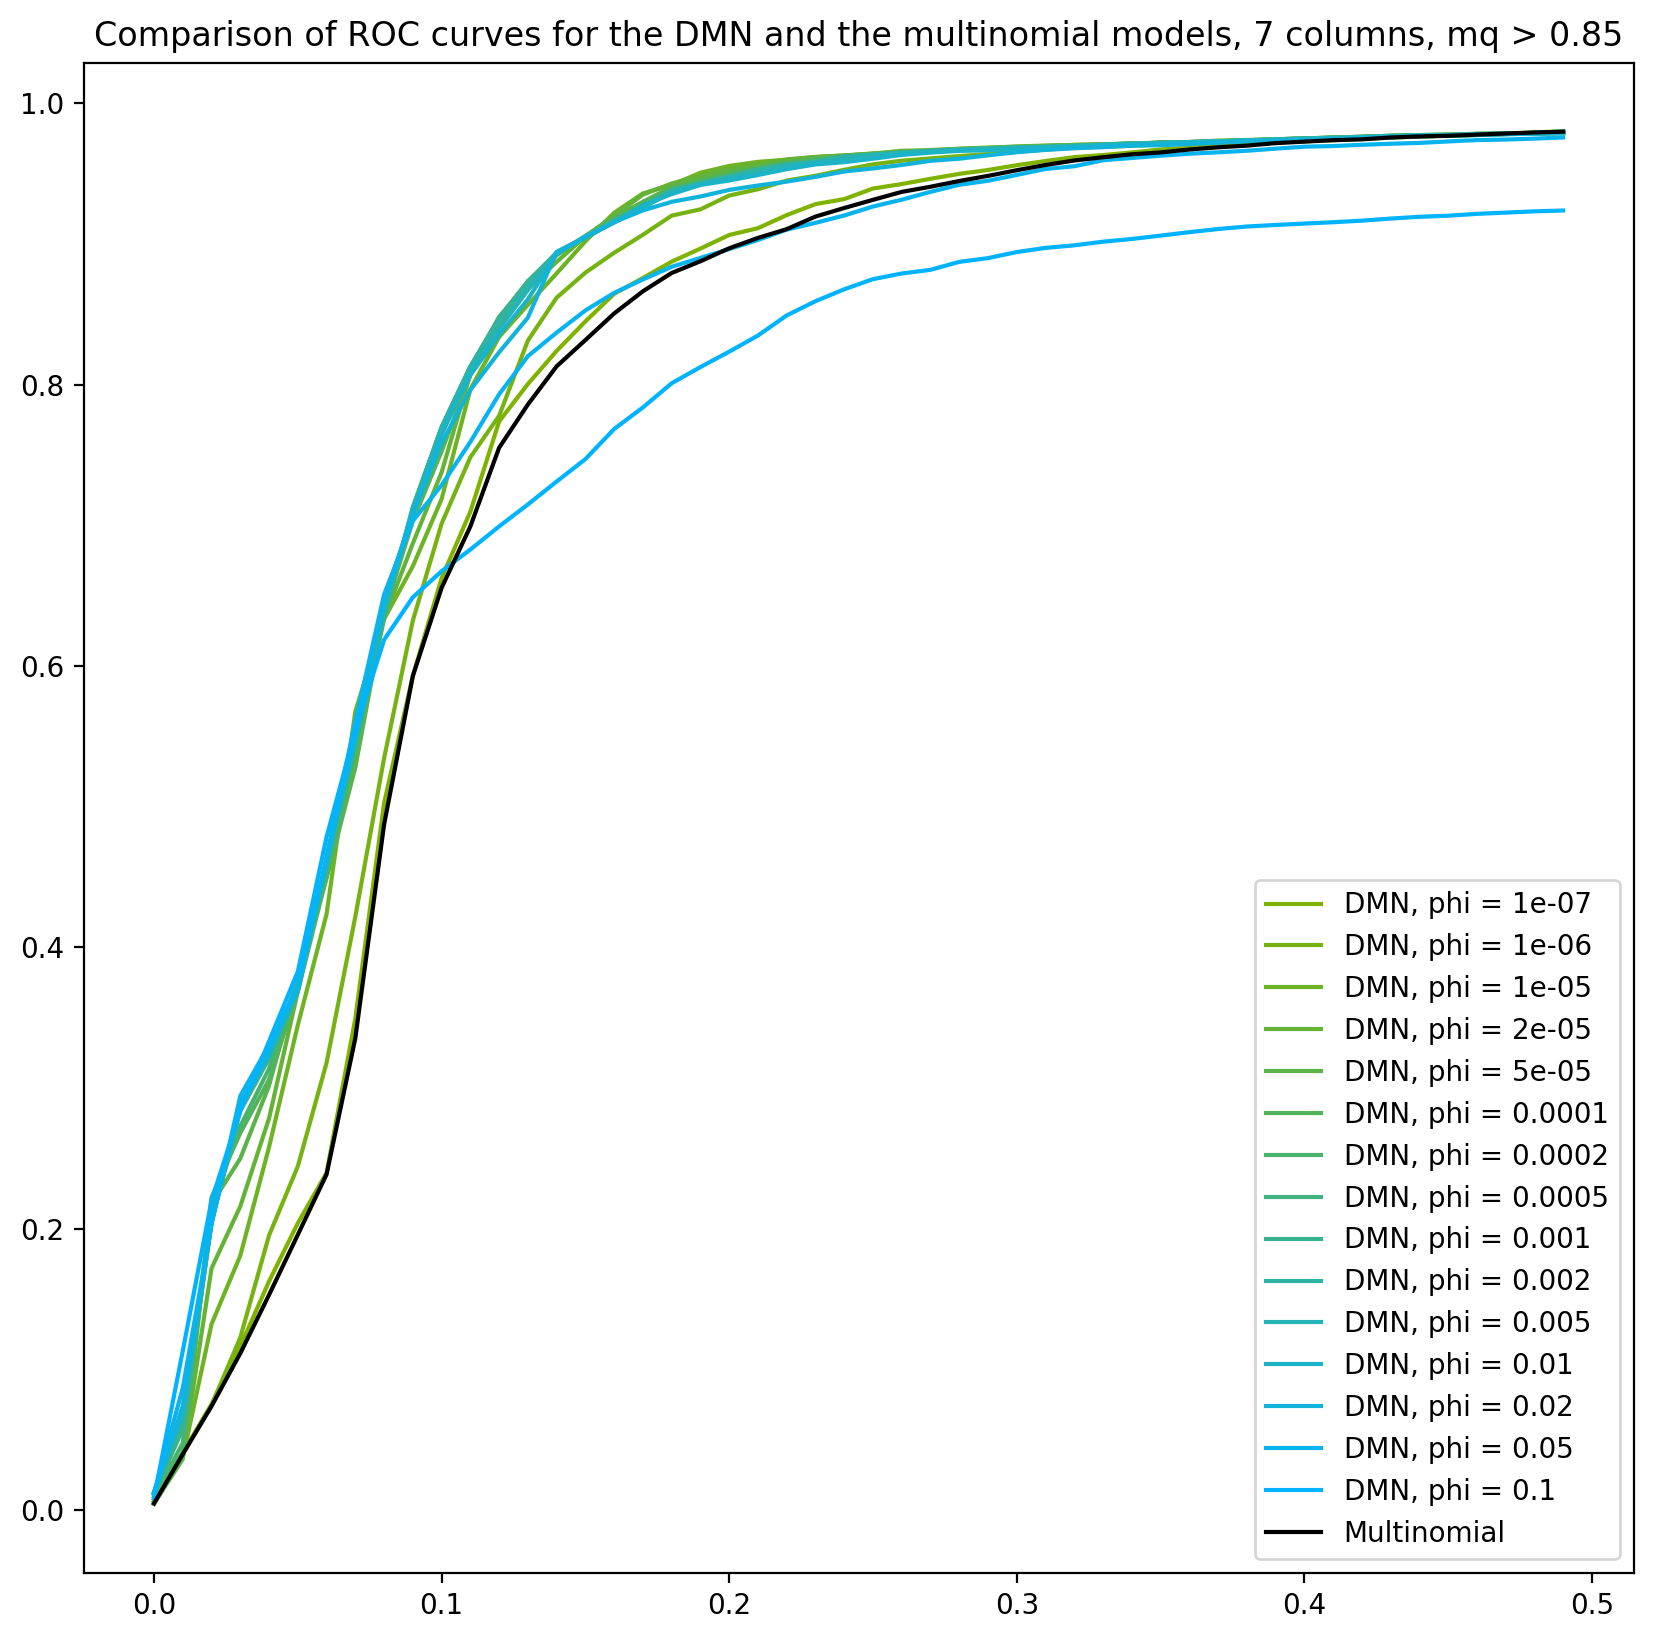

In [43]:
nb_col = 7

plt.figure(figsize = (10, 10))

power5, power10, power20 = [], [], []
level80, level90 = [], []

sel_same = np.logical_and(np.array(DMN_same["nb_col"]) == nb_col, np.array(DMN_same["mq"]) > 0.85)
sel_diff = np.logical_and(np.array(DMN_diff["nb_col"]) == nb_col, np.array([max(x) for x in DMN_diff["mq"]]) > 0.85)

for i in range(15):
    x, y = ROC_curve(df_same_DMN[lst_strphi[i]][sel_same],
                     df_diff_DMN[lst_strphi[i]][sel_diff],
                     step = 0.01
                    )
    plt.plot(x[:50], y[:50], c = (0.5 - i / 28, .7, i / 14), label = "DMN, phi = " + lst_strphi[i])
    
    power5.append(y[5])
    power10.append(y[10])
    power20.append(y[20])
    
    level80.append(sum(y < 0.8) / 100)
    level90.append(sum(y < 0.9) / 100)
    
x, y = ROC_curve(sr_same[sel_same], sr_diff[sel_diff], step = 0.01)
plt.plot(x[:50], y[:50], color = "k", label = "Multinomial")
    
plt.legend()
plt.title("Comparison of ROC curves for the DMN and the multinomial models, " + str(nb_col) + " columns, mq > 0.85")
plt.show()

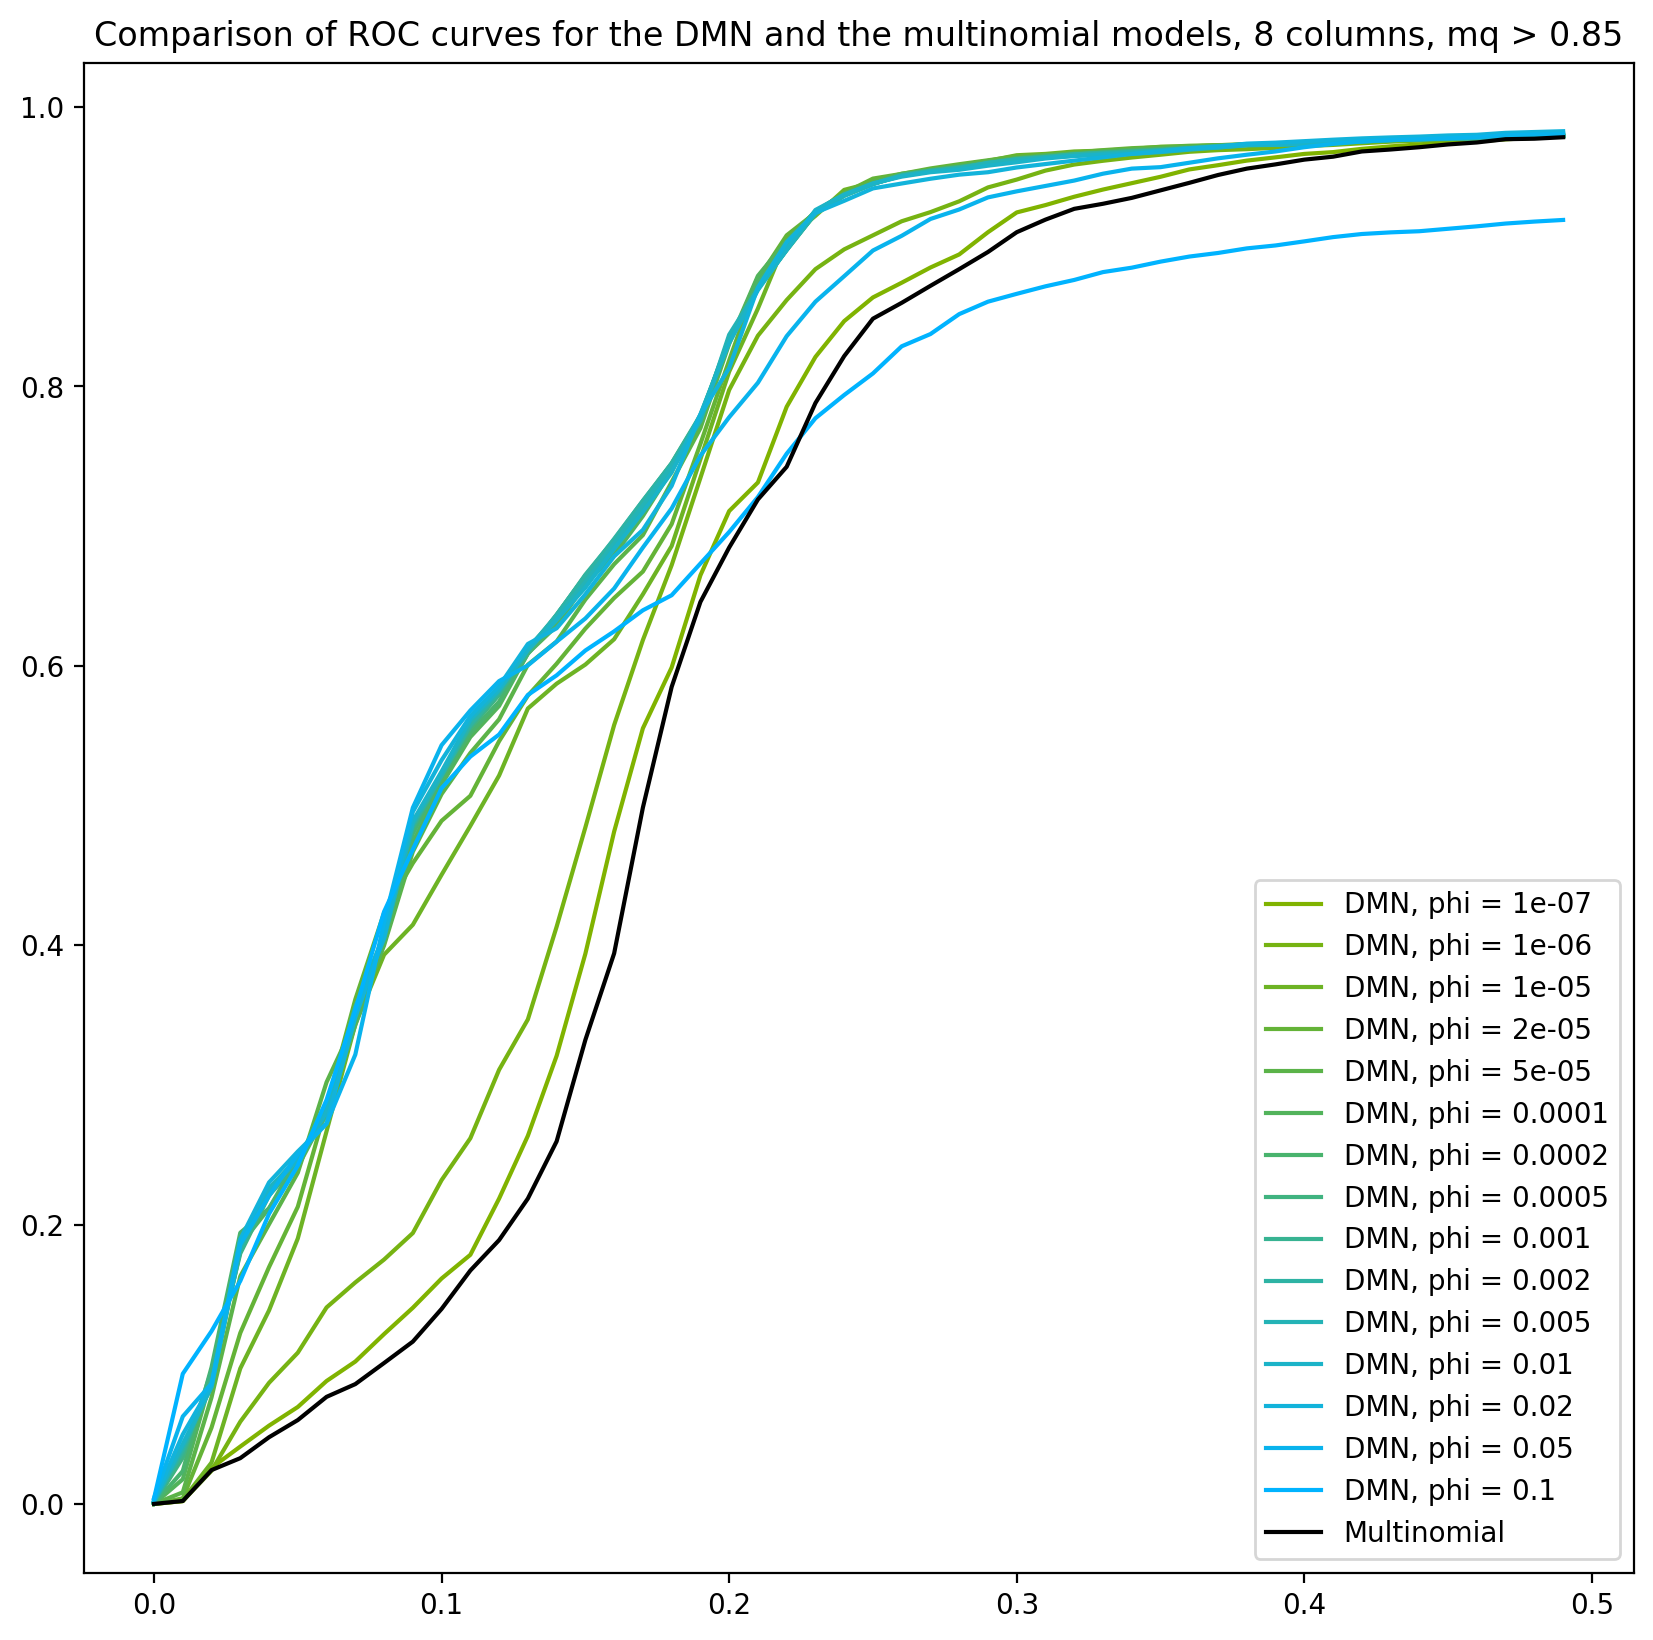

In [44]:
nb_col = 8

plt.figure(figsize = (10, 10))

power5, power10, power20 = [], [], []
level80, level90 = [], []

sel_same = np.logical_and(np.array(DMN_same["nb_col"]) == nb_col, np.array(DMN_same["mq"]) > 0.85)
sel_diff = np.logical_and(np.array(DMN_diff["nb_col"]) == nb_col, np.array([max(x) for x in DMN_diff["mq"]]) > 0.85)

for i in range(15):
    x, y = ROC_curve(df_same_DMN[lst_strphi[i]][sel_same],
                     df_diff_DMN[lst_strphi[i]][sel_diff],
                     step = 0.01
                    )
    plt.plot(x[:50], y[:50], c = (0.5 - i / 28, .7, i / 14), label = "DMN, phi = " + lst_strphi[i])
    
    power5.append(y[5])
    power10.append(y[10])
    power20.append(y[20])
    
    level80.append(sum(y < 0.8) / 100)
    level90.append(sum(y < 0.9) / 100)
    
x, y = ROC_curve(sr_same[sel_same], sr_diff[sel_diff], step = 0.01)
plt.plot(x[:50], y[:50], color = "k", label = "Multinomial")
    
plt.legend()
plt.title("Comparison of ROC curves for the DMN and the multinomial models, " + str(nb_col) + " columns, mq > 0.85")
plt.show()

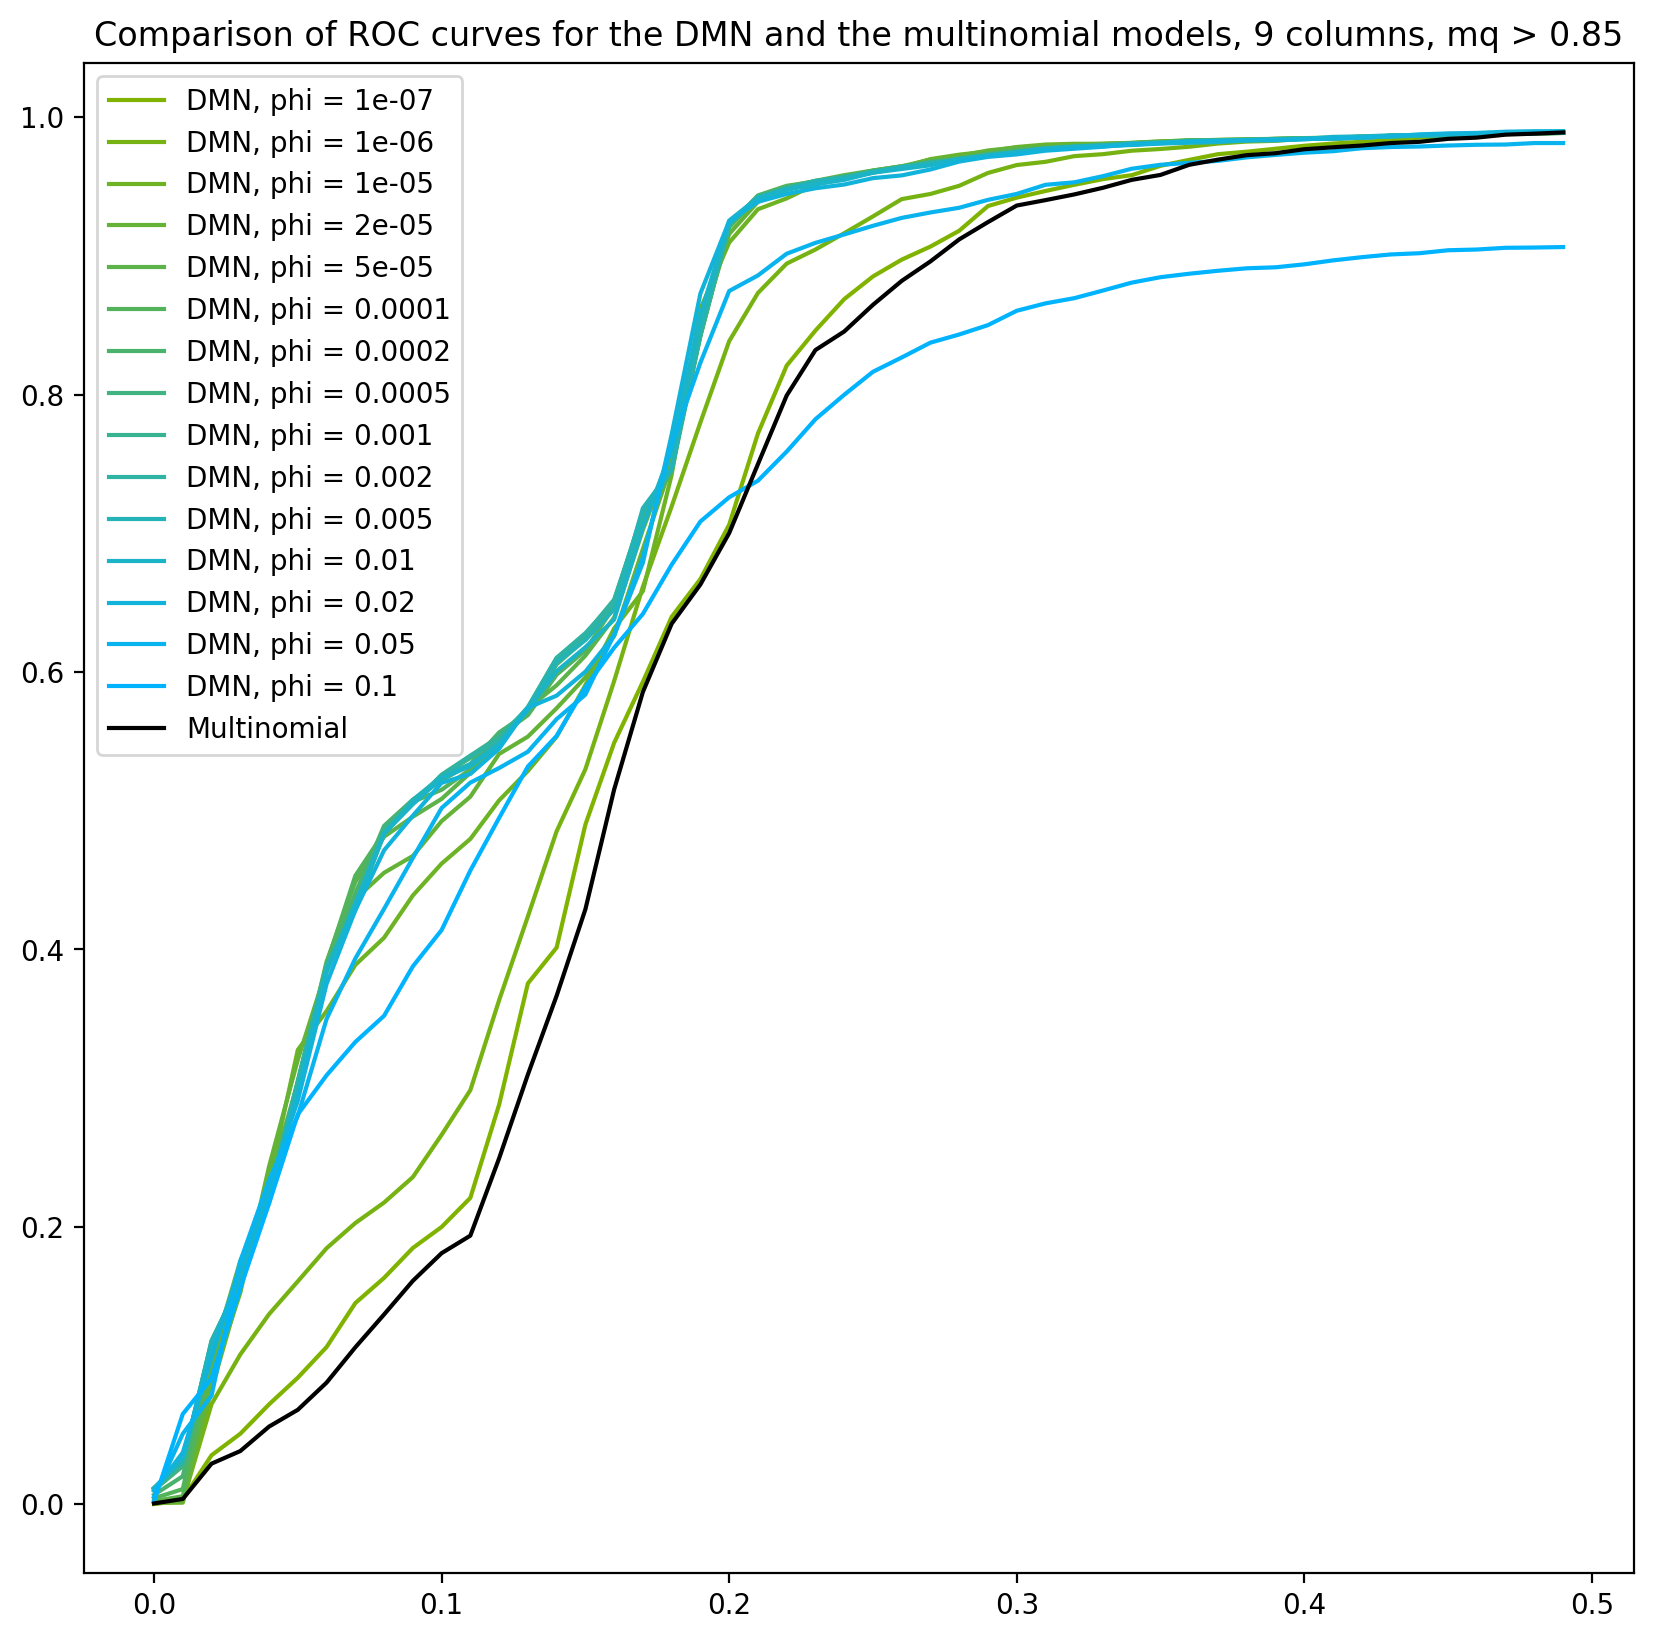

In [45]:
nb_col = 9

plt.figure(figsize = (10, 10))

power5, power10, power20 = [], [], []
level80, level90 = [], []

sel_same = np.logical_and(np.array(DMN_same["nb_col"]) == nb_col, np.array(DMN_same["mq"]) > 0.85)
sel_diff = np.logical_and(np.array(DMN_diff["nb_col"]) == nb_col, np.array([max(x) for x in DMN_diff["mq"]]) > 0.85)

for i in range(15):
    x, y = ROC_curve(df_same_DMN[lst_strphi[i]][sel_same],
                     df_diff_DMN[lst_strphi[i]][sel_diff],
                     step = 0.01
                    )
    plt.plot(x[:50], y[:50], c = (0.5 - i / 28, .7, i / 14), label = "DMN, phi = " + lst_strphi[i])
    
    power5.append(y[5])
    power10.append(y[10])
    power20.append(y[20])
    
    level80.append(sum(y < 0.8) / 100)
    level90.append(sum(y < 0.9) / 100)
    
x, y = ROC_curve(sr_same[sel_same], sr_diff[sel_diff], step = 0.01)
plt.plot(x[:50], y[:50], color = "k", label = "Multinomial")
    
plt.legend()
plt.title("Comparison of ROC curves for the DMN and the multinomial models, " + str(nb_col) + " columns, mq > 0.85")
plt.show()

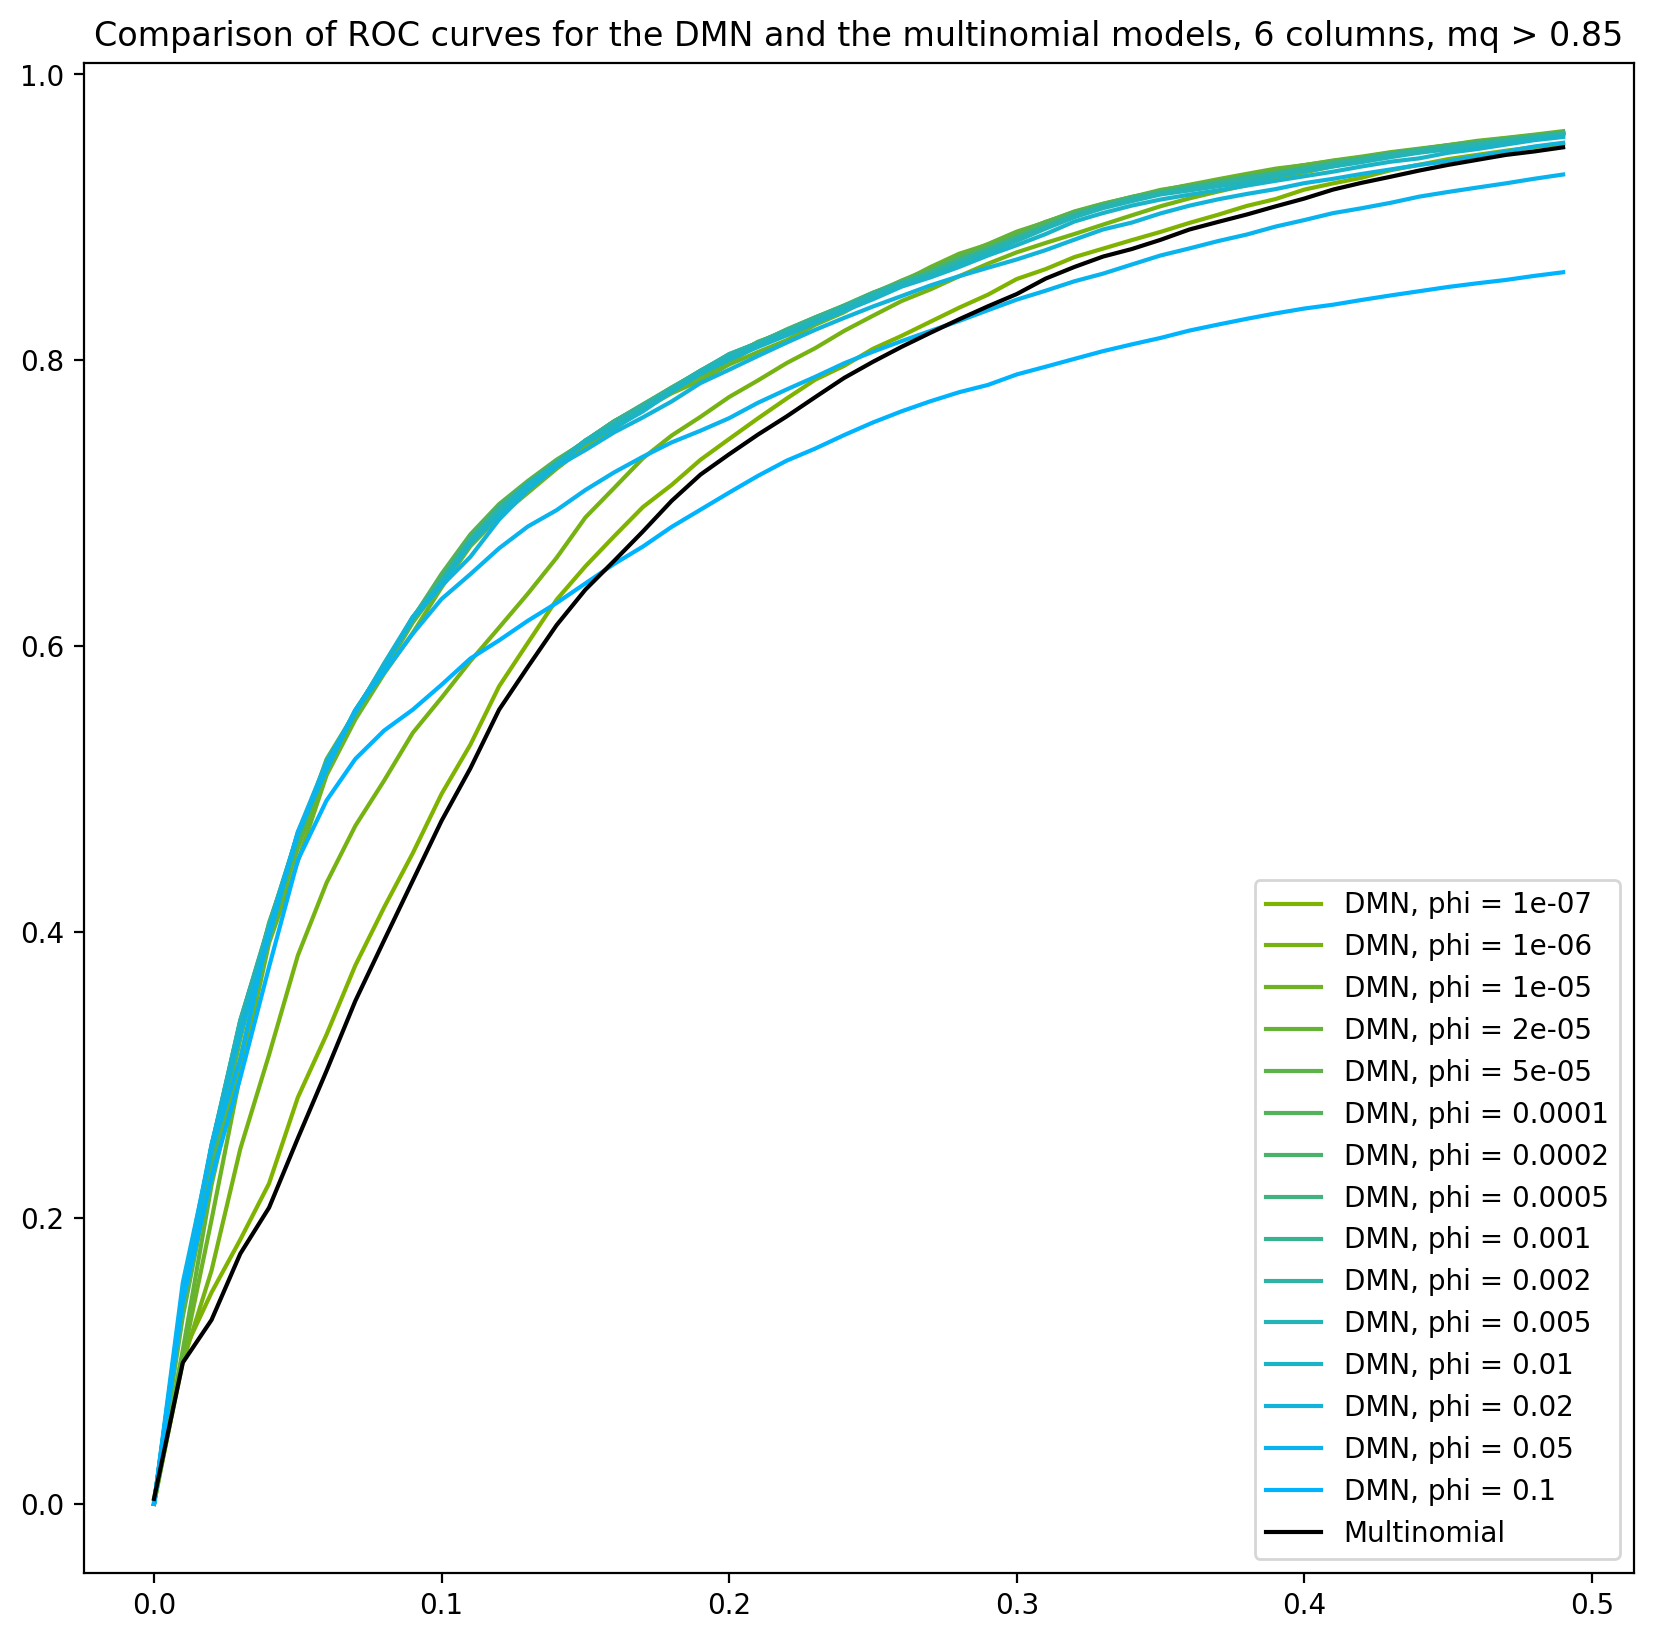

In [46]:
nb_col = 6

plt.figure(figsize = (10, 10))

power5, power10, power20 = [], [], []
level80, level90 = [], []

sel_same = np.logical_and(np.array(DMN_same["nb_col"]) == nb_col, np.array(DMN_same["mq"]) > 1e-3)
sel_diff = np.logical_and(np.array(DMN_diff["nb_col"]) == nb_col, np.array([max(x) for x in DMN_diff["mq"]]) > 1e-3)

for i in range(15):
    x, y = ROC_curve(df_same_DMN[lst_strphi[i]][sel_same],
                     df_diff_DMN[lst_strphi[i]][sel_diff],
                     step = 0.01
                    )
    plt.plot(x[:50], y[:50], c = (0.5 - i / 28, .7, i / 14), label = "DMN, phi = " + lst_strphi[i])
    
    power5.append(y[5])
    power10.append(y[10])
    power20.append(y[20])
    
    level80.append(sum(y < 0.8) / 100)
    level90.append(sum(y < 0.9) / 100)
    
x, y = ROC_curve(sr_same[sel_same], sr_diff[sel_diff], step = 0.01)
plt.plot(x[:50], y[:50], color = "k", label = "Multinomial")
    
plt.legend()
plt.title("Comparison of ROC curves for the DMN and the multinomial models, " + str(nb_col) + " columns, mq > 0.85")
plt.show()

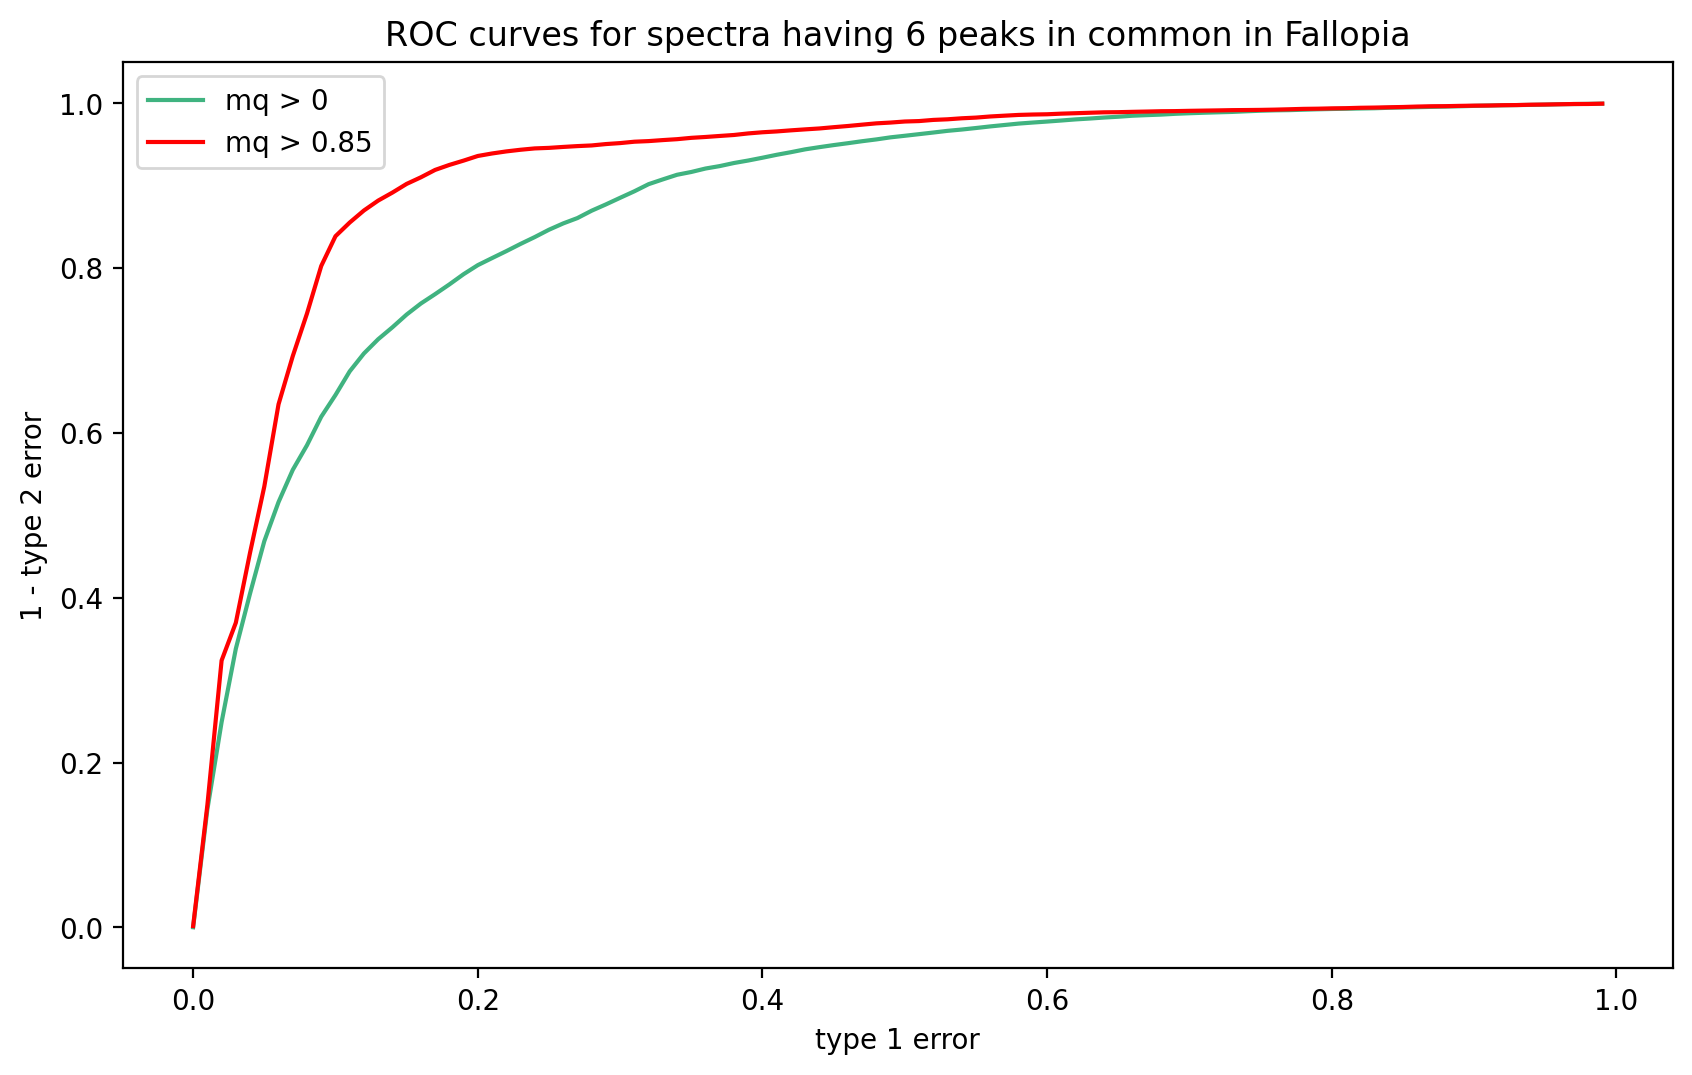

In [47]:
nb_col = 6


plt.figure(figsize = (10, 6))

sel_same = np.logical_and(np.array(DMN_same["nb_col"]) == nb_col, np.array(DMN_same["mq"]) > 1e-3)
sel_diff = np.logical_and(np.array(DMN_diff["nb_col"]) == nb_col, np.array([max(x) for x in DMN_diff["mq"]]) > 1e-3)

x, y = ROC_curve(df_same_DMN["0.001"][sel_same],
                     df_diff_DMN["0.001"][sel_diff],
                     step = 0.01)
plt.plot(x[:500], y[:500], c = (0.25, .7, .5), label = "mq > 0")

sel_same = np.logical_and(np.array(DMN_same["nb_col"]) == nb_col, np.array(DMN_same["mq"]) > .85)
sel_diff = np.logical_and(np.array(DMN_diff["nb_col"]) == nb_col, np.array([max(x) for x in DMN_diff["mq"]]) > .85)

x, y = ROC_curve(df_same_DMN["0.001"][sel_same],
                     df_diff_DMN["0.001"][sel_diff],
                     step = 0.01)
plt.plot(x[:500], y[:500], c = "r", label = "mq > 0.85")

plt.xlabel("type 1 error")
plt.ylabel("1 - type 2 error")
plt.legend()
plt.title("ROC curves for spectra having 6 peaks in common in Fallopia")
plt.show()

In [48]:
def power(stat_same, stat_diff, alpha = 0.2):
    th = stat_same.quantile(1 - alpha)
    return sum(stat_diff > th) / len(stat_diff)

In [49]:
key = "0.001"

nb_col = 5

sr1 = df_same_DMN[key]
sr2 = df_diff_DMN[key]

sel_same = DMN_same["nb_col"] == nb_col
sel_diff = DMN_diff["nb_col"] == nb_col

stat_same = sr1[sel_same]
stat_diff = sr2[sel_diff]

In [50]:
power(stat_same, stat_diff)

0.7093578630815496

In [51]:
df_same_DMN.keys()

Index(['Unnamed: 0', '1e-07', '1e-06', '1e-05', '2e-05', '5e-05', '0.0001',
       '0.0002', '0.0005', '0.001', '0.002', '0.005', '0.01', '0.02', '0.05',
       '0.1'],
      dtype='object')

In [52]:
df_same_smiles = pd.read_csv(sub_directory + "DMN_same_smiles.csv")
df_diff_smiles = pd.read_csv(sub_directory + "DMN_diff_smiles.csv")

In [53]:
same_smiles_info = pd.read_csv(sub_directory + "same_smiles_info.csv")
diff_smiles_info = pd.read_csv(sub_directory + "diff_smiles_info.csv")

In [54]:
def plot_power(stat_same, stat_diff, columns_same, columns_diff, style = "-", label = "", color = "blue", alpha = 0.2, max_col = 10):
    x = range(2, max_col + 1)
    y = []
    for i in x:
        y.append(power(stat_same[columns_same == i], stat_diff[columns_diff == i], alpha = alpha))
    plt.plot(x, y, style, label = label, color = color)

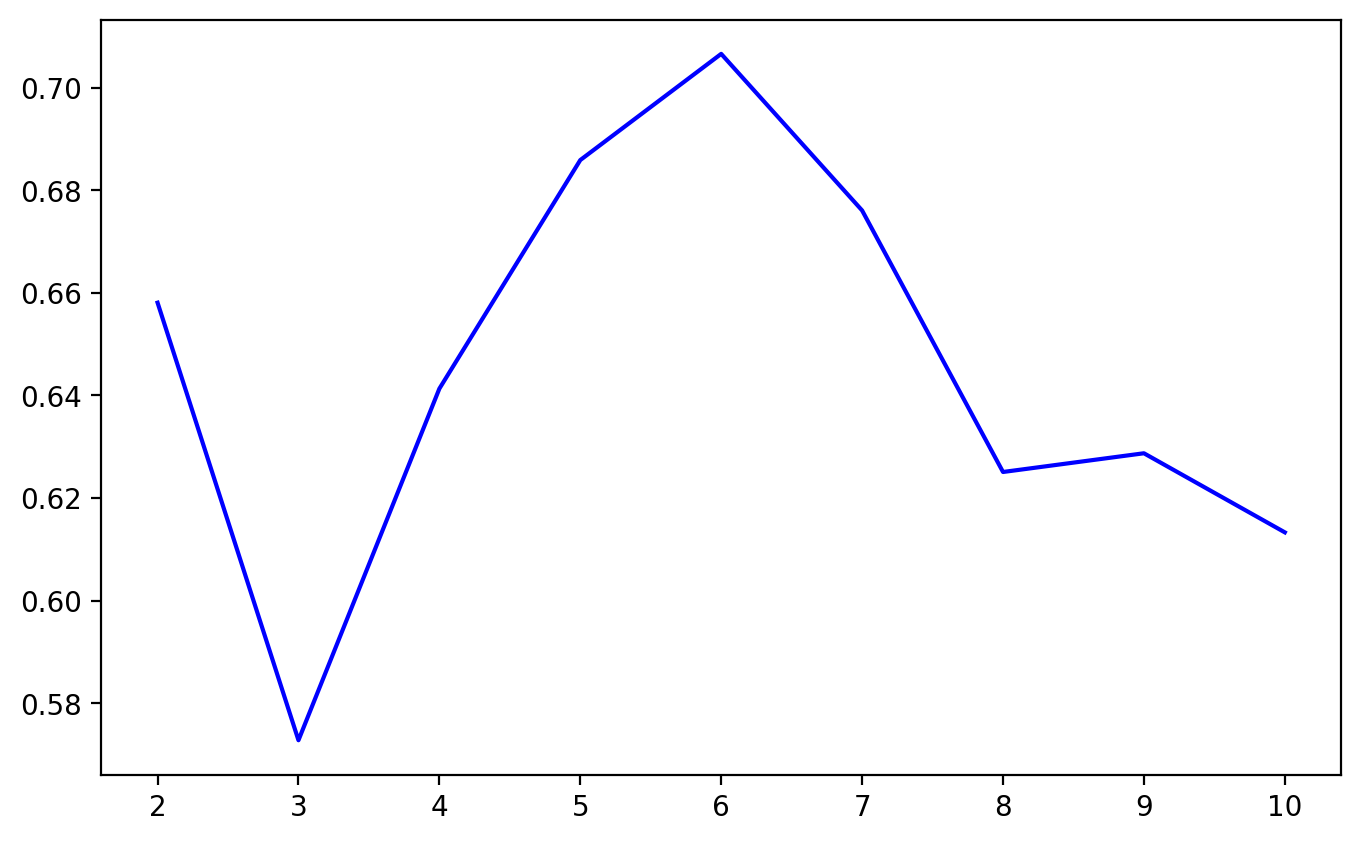

In [55]:
nb_col = 5
key = "1e-06"

sr1 = df_same_DMN[key]
sr2 = df_diff_DMN[key]

plot_power(sr1, sr2, np.array(DMN_same["nb_col"]), np.array(DMN_diff["nb_col"]))

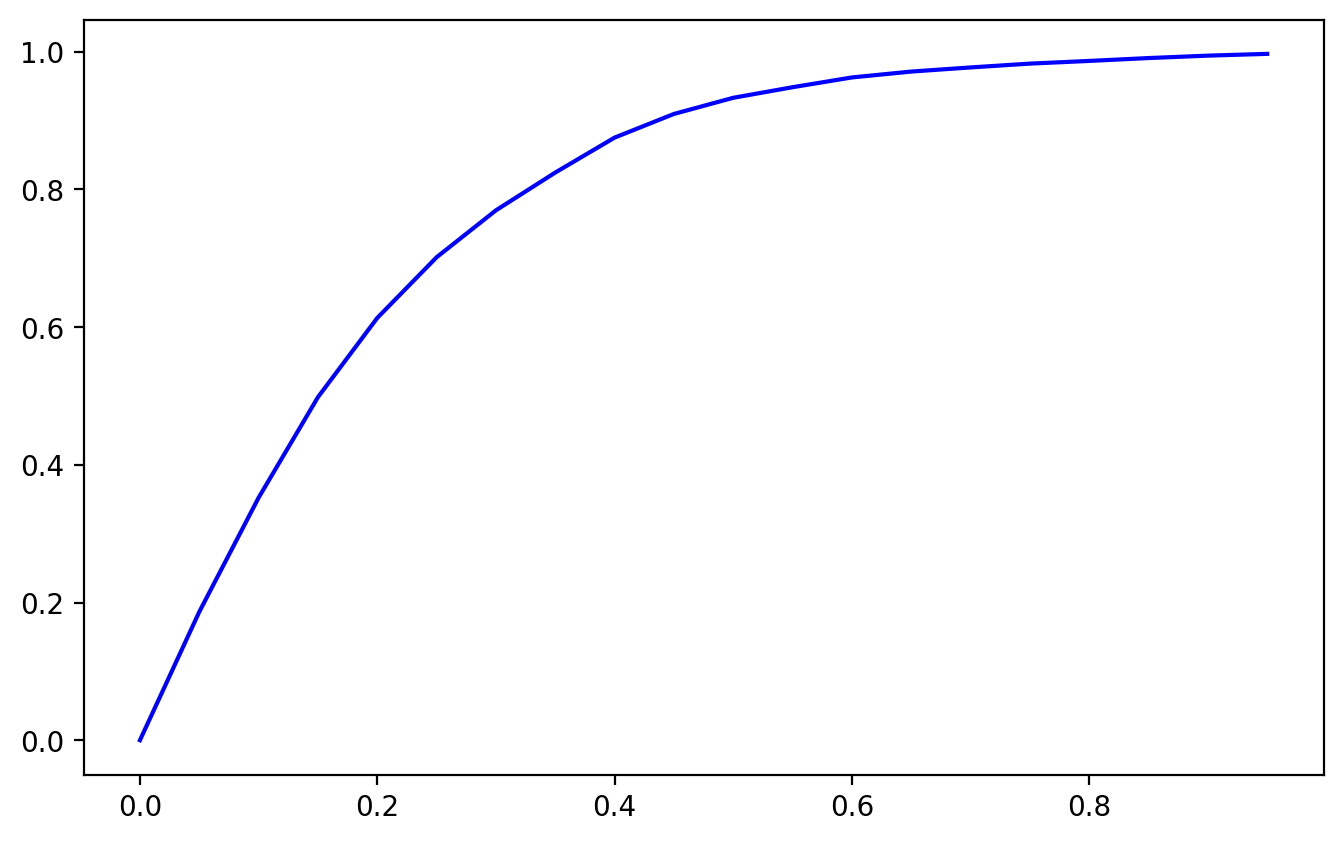

In [56]:
i = 10
sr1 = df_same_DMN["1e-06"]
sr2 = df_diff_DMN["1e-06"]

sel_same = np.array(DMN_same["nb_col"]) == i
sel_diff = np.array(DMN_diff["nb_col"]) == i

stat_same = sr1[sel_same]
stat_diff = sr2[sel_diff]

x, y = ROC_curve(stat_same, stat_diff, step = 0.05)
plt.plot(x, y, "blue")

In [57]:
df_same_DMN["multinomial"] = sr_same

In [58]:
df_diff_DMN["multinomial"] = sr_diff

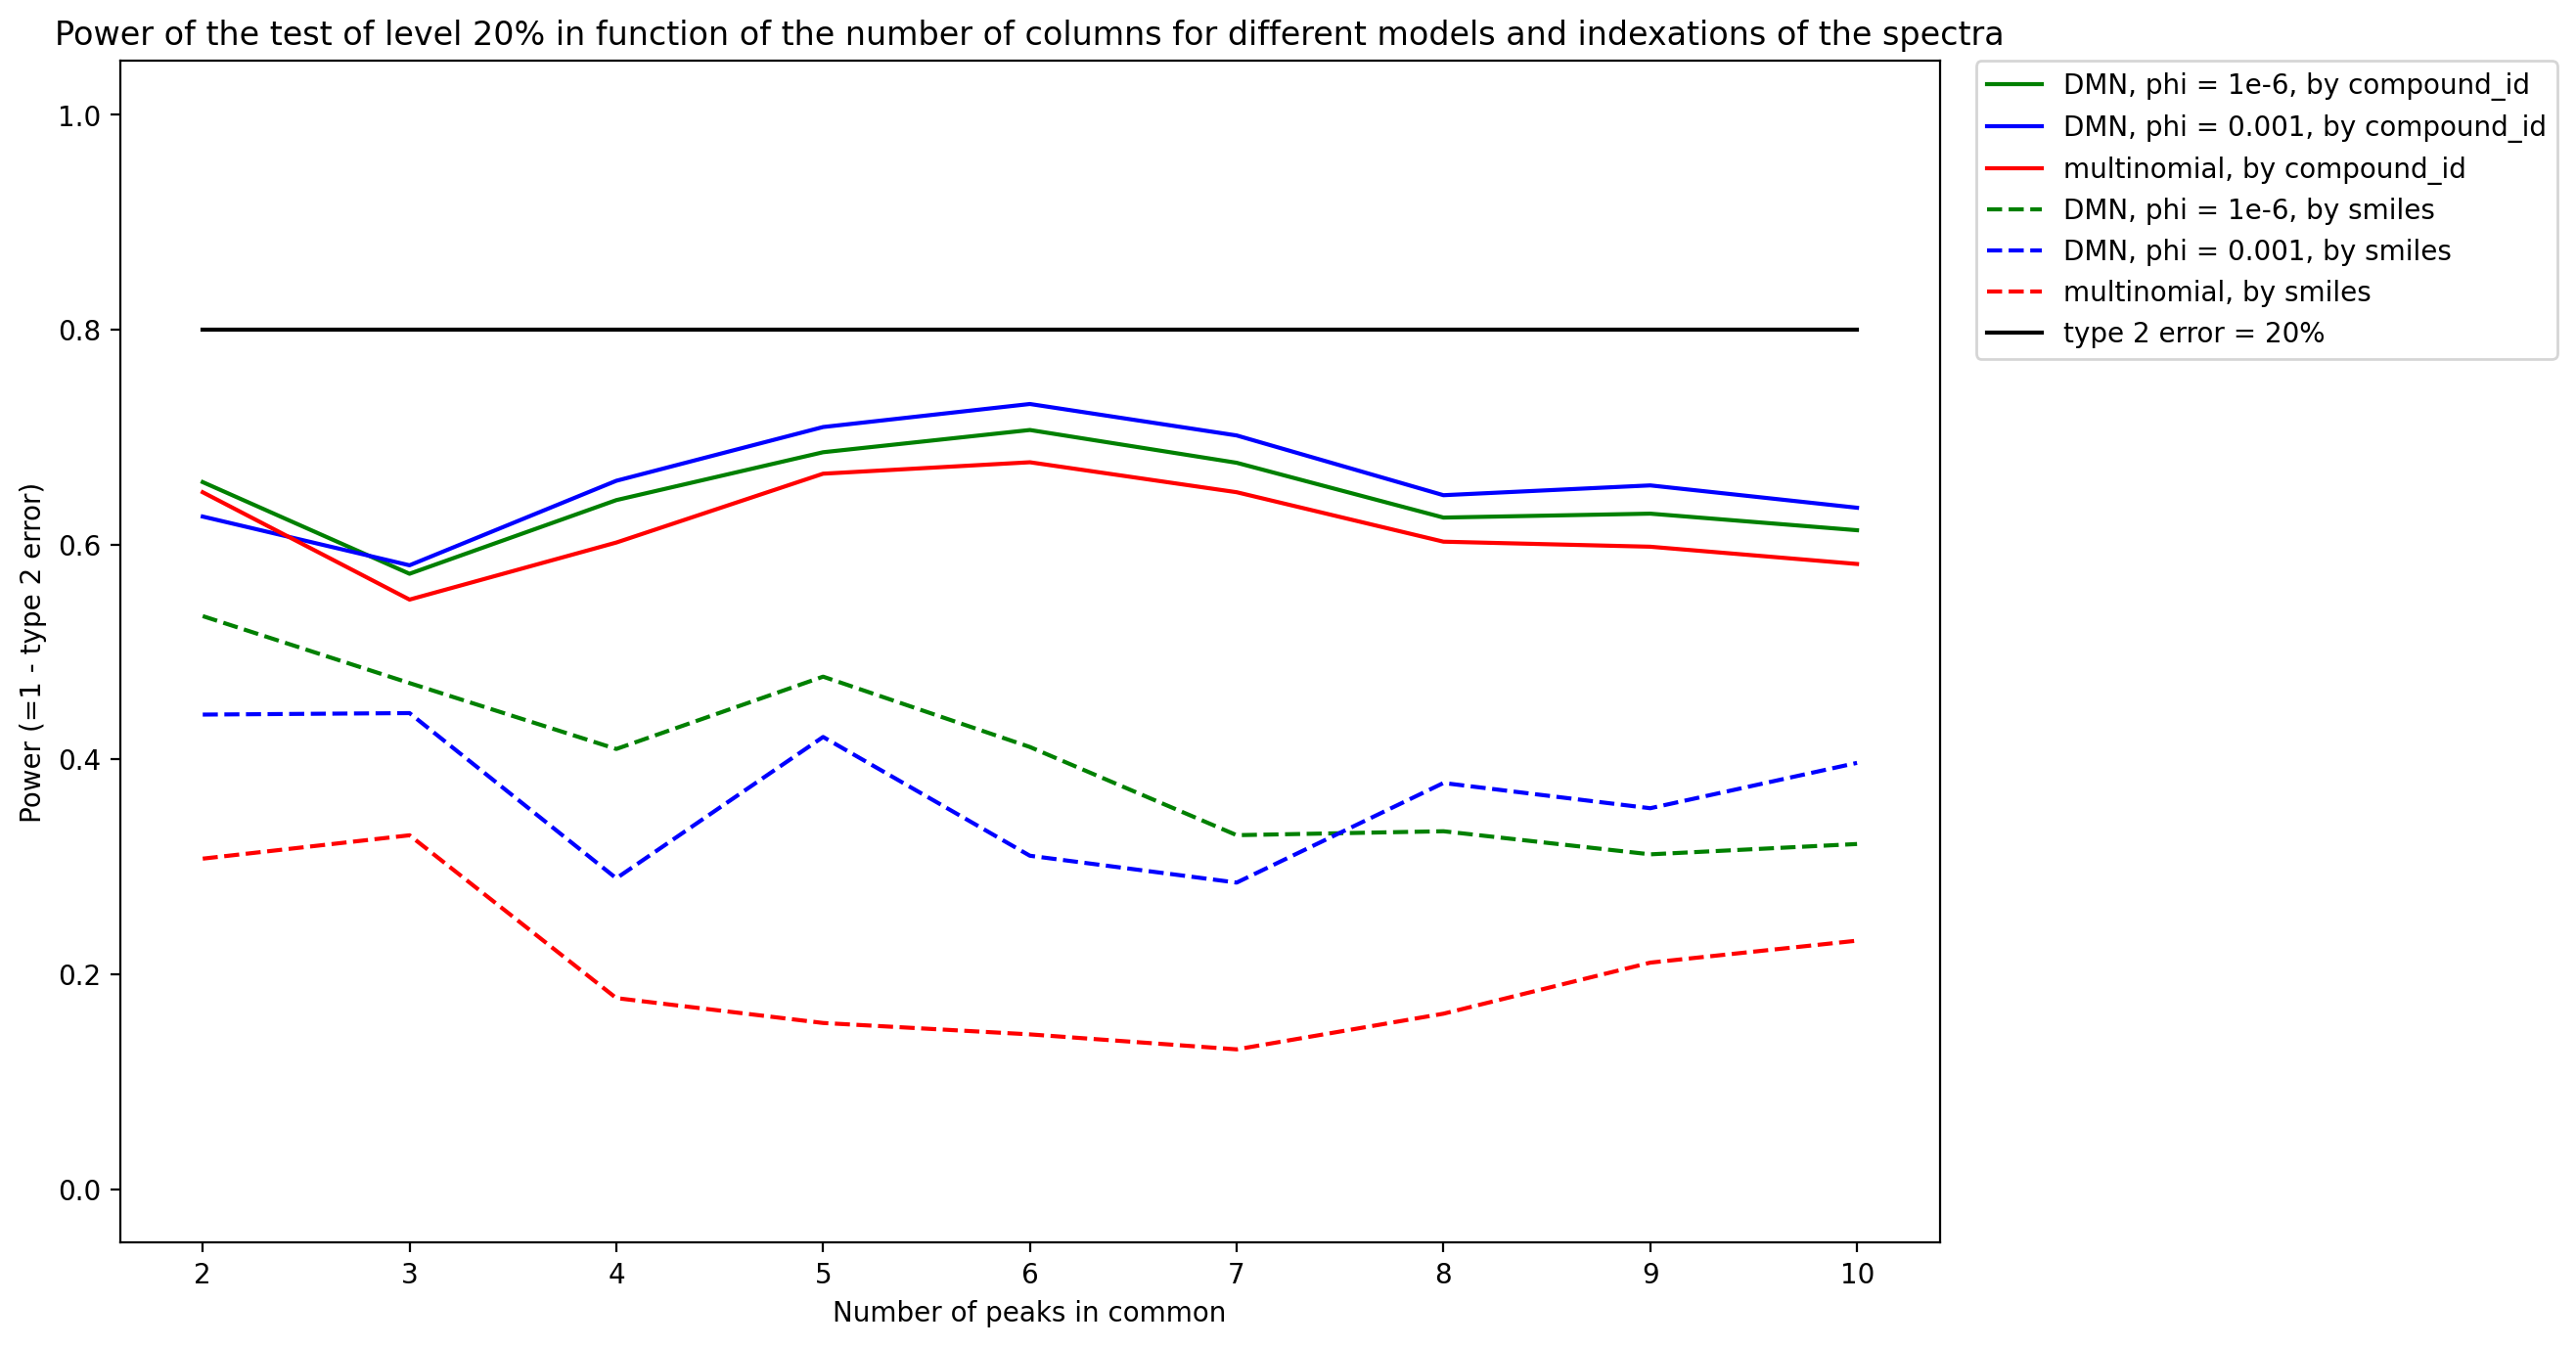

In [59]:
keys = ["1e-06", "0.001", "multinomial"]
color_code = pd.Series(["green", "blue", "red"], index = keys)
label_code = pd.Series(["DMN, phi = 1e-6", "DMN, phi = 0.001", "multinomial"], index = keys)

plt.figure(figsize = (12, 8))

for key in keys:
    stat_same = df_same_DMN[key]
    stat_diff = df_diff_DMN[key]
    
    columns_same = DMN_same["nb_col"]
    columns_diff = DMN_diff["nb_col"]
    
    plot_power(stat_same,
               stat_diff,
               columns_same,
               columns_diff,
               label = label_code[key] + ", by compound_id",
               color = color_code[key]
              )
    
for key in keys:
    stat_same = df_same_smiles[key]
    stat_diff = df_diff_smiles[key]
    
    columns_same = same_smiles_info["nb_col"]
    columns_diff = diff_smiles_info["nb_col"]
    
    plot_power(stat_same,
               stat_diff,
               columns_same,
               columns_diff,
               style = "--",
               label = label_code[key] + ", by smiles",
               color = color_code[key]
              )
    
plt.plot([2, 10], [0, 0], "white")
plt.plot([2, 10], [1, 1], "white")

plt.plot([2, 10], [.8, .8], c = "k", label = "type 2 error = 20%")
    
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel("Number of peaks in common")
plt.ylabel("Power (=1 - type 2 error)")
plt.title("Power of the test of level 20% in function of the number of columns for different models and indexations of the spectra")
plt.show()

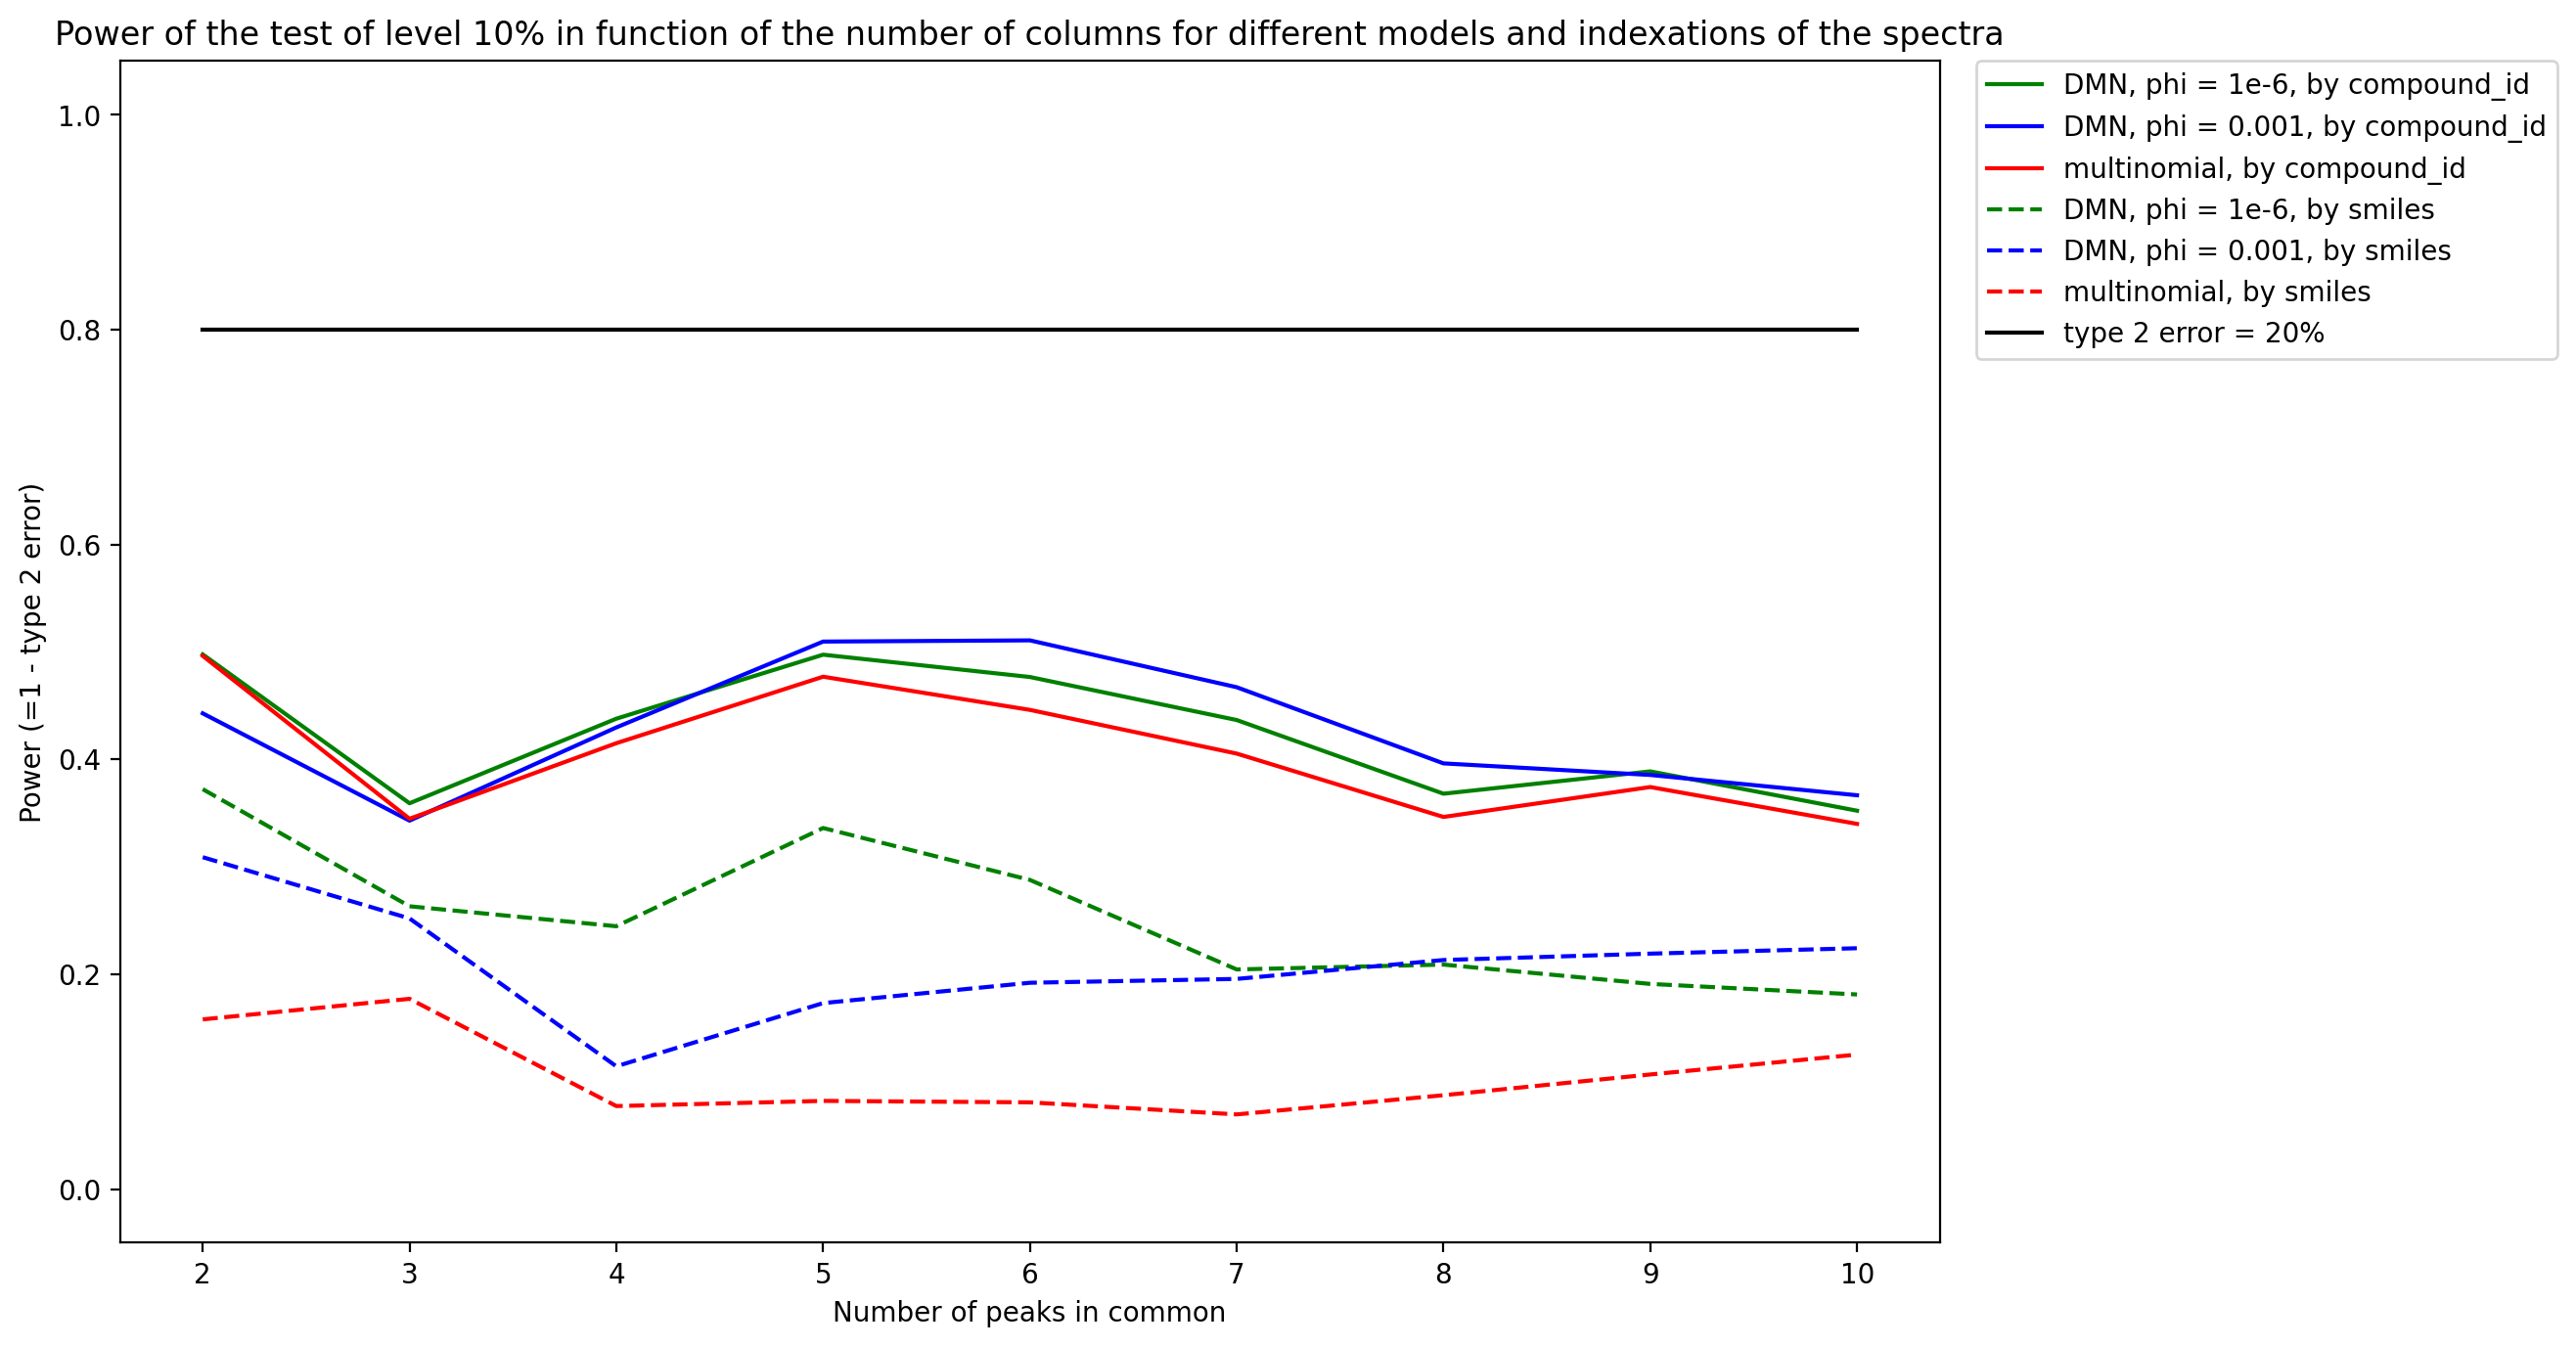

In [60]:
keys = ["1e-06", "0.001", "multinomial"]
color_code = pd.Series(["green", "blue", "red"], index = keys)
label_code = pd.Series(["DMN, phi = 1e-6", "DMN, phi = 0.001", "multinomial"], index = keys)

plt.figure(figsize = (12, 8))

for key in keys:
    stat_same = df_same_DMN[key]
    stat_diff = df_diff_DMN[key]
    
    columns_same = DMN_same["nb_col"]
    columns_diff = DMN_diff["nb_col"]
    
    plot_power(stat_same,
               stat_diff,
               columns_same,
               columns_diff,
               label = label_code[key] + ", by compound_id",
               color = color_code[key],
               alpha = .1
              )
    
for key in keys:
    stat_same = df_same_smiles[key]
    stat_diff = df_diff_smiles[key]
    
    columns_same = same_smiles_info["nb_col"]
    columns_diff = diff_smiles_info["nb_col"]
    
    plot_power(stat_same,
               stat_diff,
               columns_same,
               columns_diff,
               style = "--",
               label = label_code[key] + ", by smiles",
               color = color_code[key],
               alpha = .1
              )
plt.plot([2, 10], [0, 0], "white")
plt.plot([2, 10], [1, 1], "white")
plt.plot([2, 10], [.8, .8], c = "k", label = "type 2 error = 20%")
    
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel("Number of peaks in common")
plt.ylabel("Power (=1 - type 2 error)")
plt.title("Power of the test of level 10% in function of the number of columns for different models and indexations of the spectra")
plt.show()

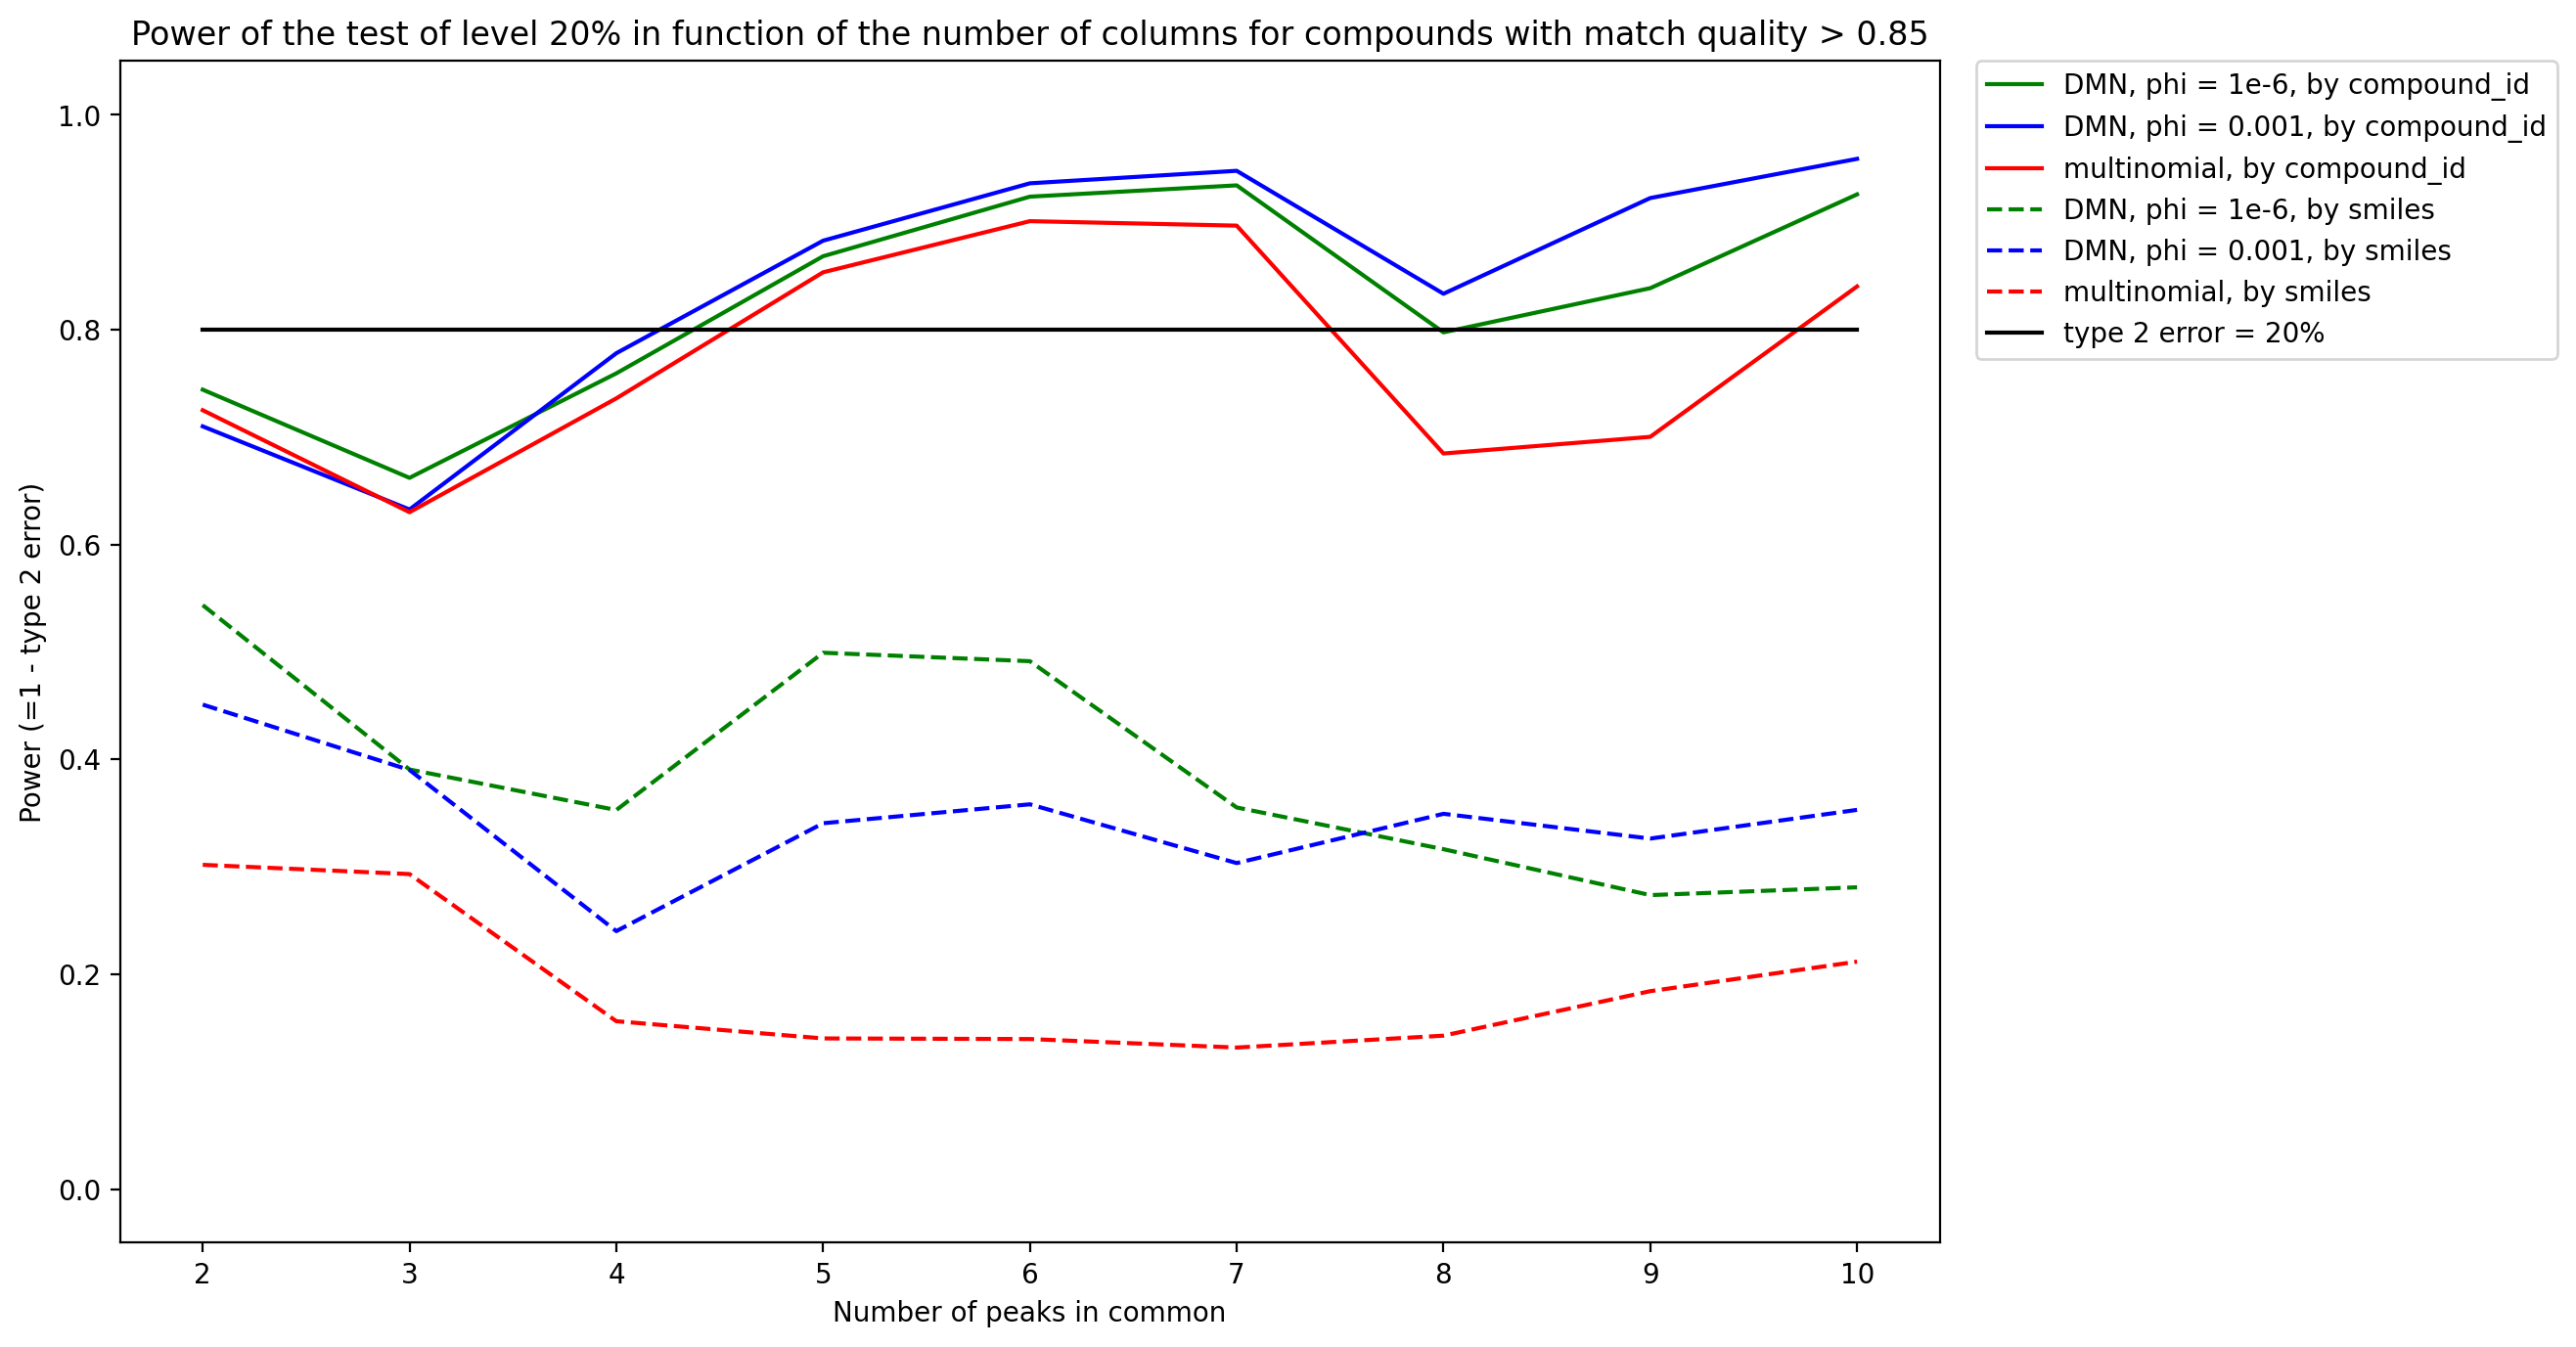

In [61]:
keys = ["1e-06", "0.001", "multinomial"]
color_code = pd.Series(["green", "blue", "red"], index = keys)
label_code = pd.Series(["DMN, phi = 1e-6", "DMN, phi = 0.001", "multinomial"], index = keys)

plt.figure(figsize = (12, 8))

for key in keys:
    stat_same = df_same_DMN[key]
    stat_diff = df_diff_DMN[key]
    
    columns_same = np.array(DMN_same["nb_col"])
    columns_diff = np.array(DMN_diff["nb_col"])
    
    
    plot_power(stat_same,
               stat_diff,
               columns_same * (np.array(DMN_same["mq"]) > .85),
               columns_diff * (np.array([max(x, y) for x, y in DMN_diff["mq"]]) > .85),
               label = label_code[key] + ", by compound_id",
               color = color_code[key]
              )
    
for key in keys:
    stat_same = df_same_smiles[key]
    stat_diff = df_diff_smiles[key]
    
    columns_same = same_smiles_info["nb_col"]
    columns_diff = diff_smiles_info["nb_col"]
    
    plot_power(stat_same,
               stat_diff,
               columns_same * (same_smiles_info["mmq"] > 0.85),
               columns_diff * (diff_smiles_info["mmq"] > 0.85),
               style = "--",
               label = label_code[key] + ", by smiles",
               color = color_code[key]
              )

plt.plot([2, 10], [0, 0], "white")
plt.plot([2, 10], [1, 1], "white")
plt.plot([2, 10], [.8, .8], c = "k", label = "type 2 error = 20%")

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel("Number of peaks in common")
plt.ylabel("Power (=1 - type 2 error)")
plt.title("Power of the test of level 20% in function of the number of columns for compounds with match quality > 0.85")
plt.show()

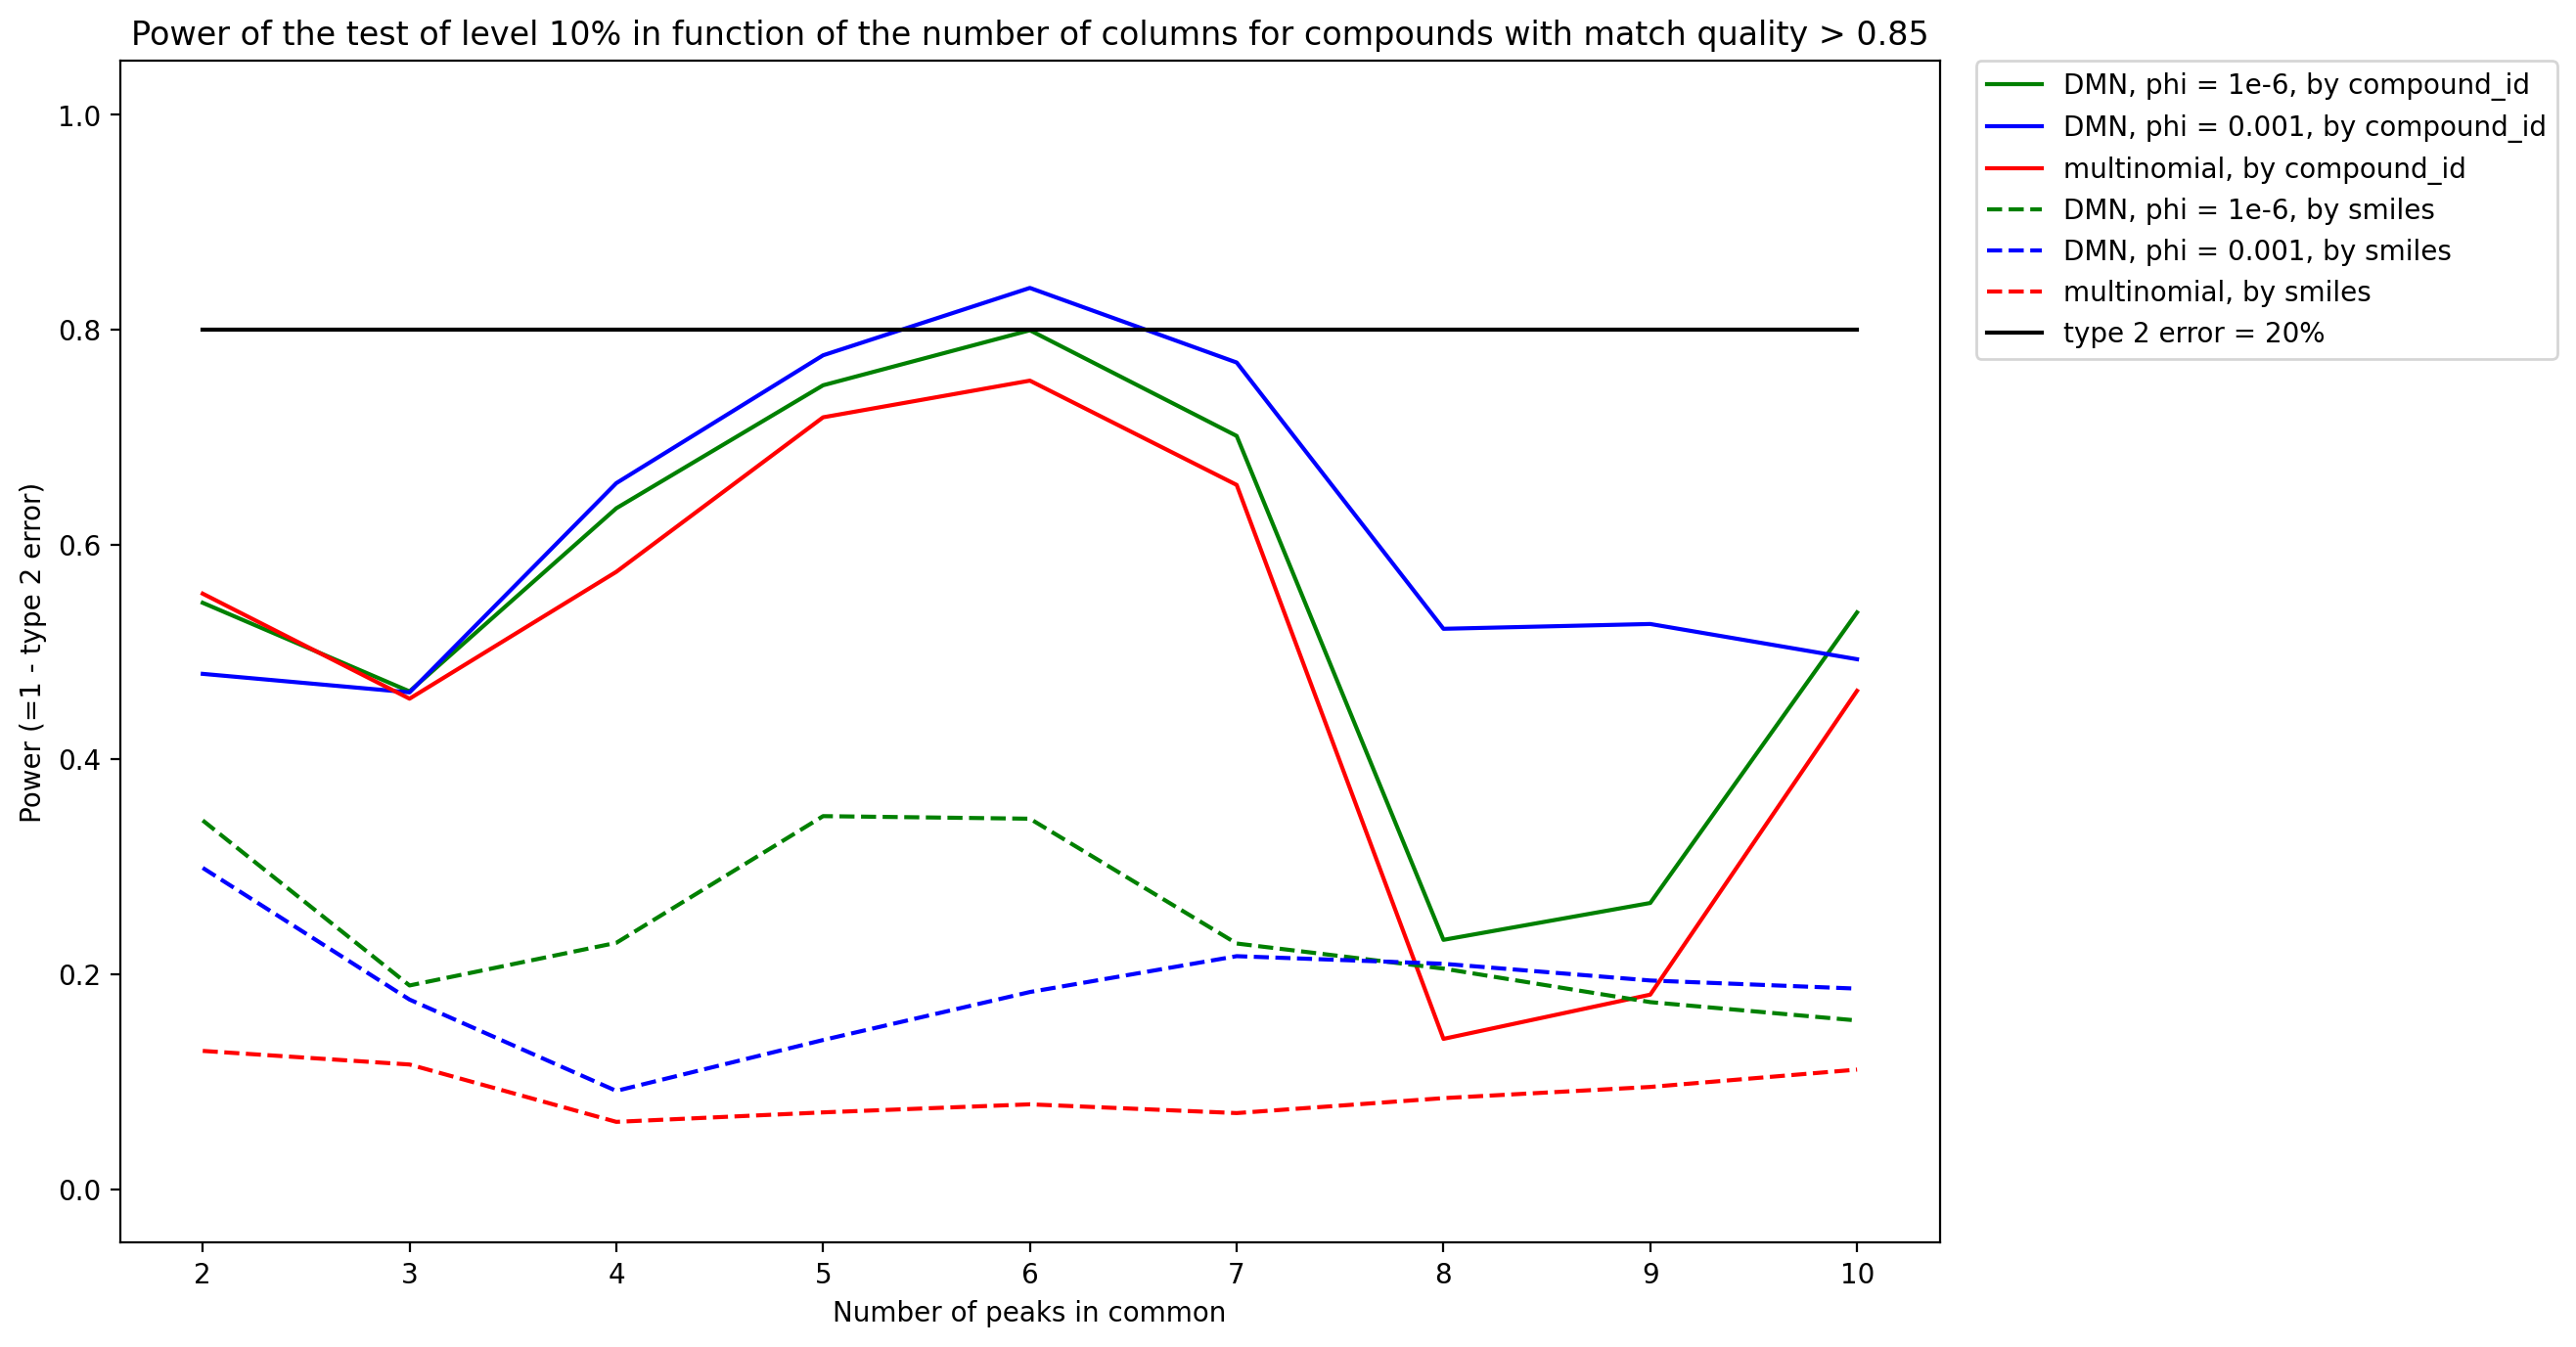

In [62]:
keys = ["1e-06", "0.001", "multinomial"]
color_code = pd.Series(["green", "blue", "red"], index = keys)
label_code = pd.Series(["DMN, phi = 1e-6", "DMN, phi = 0.001", "multinomial"], index = keys)

plt.figure(figsize = (12, 8))

for key in keys:
    stat_same = df_same_DMN[key]
    stat_diff = df_diff_DMN[key]
    
    columns_same = np.array(DMN_same["nb_col"])
    columns_diff = np.array(DMN_diff["nb_col"])
    
    
    plot_power(stat_same,
               stat_diff,
               columns_same * (np.array(DMN_same["mq"]) > .85),
               columns_diff * (np.array([max(x, y) for x, y in DMN_diff["mq"]]) > .85),
               label = label_code[key] + ", by compound_id",
               color = color_code[key],
               alpha = .1
              )
    
for key in keys:
    stat_same = df_same_smiles[key]
    stat_diff = df_diff_smiles[key]
    
    columns_same = same_smiles_info["nb_col"]
    columns_diff = diff_smiles_info["nb_col"]
    
    plot_power(stat_same,
               stat_diff,
               columns_same * (same_smiles_info["mmq"] > 0.85),
               columns_diff * (diff_smiles_info["mmq"] > 0.85),
               style = "--",
               label = label_code[key] + ", by smiles",
               color = color_code[key],
               alpha = .1,
              )

plt.plot([2, 10], [0, 0], "white")
plt.plot([2, 10], [1, 1], "white")
plt.plot([2, 10], [.8, .8], c = "k", label = "type 2 error = 20%")

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel("Number of peaks in common")
plt.ylabel("Power (=1 - type 2 error)")
plt.title("Power of the test of level 10% in function of the number of columns for compounds with match quality > 0.85")
plt.show()

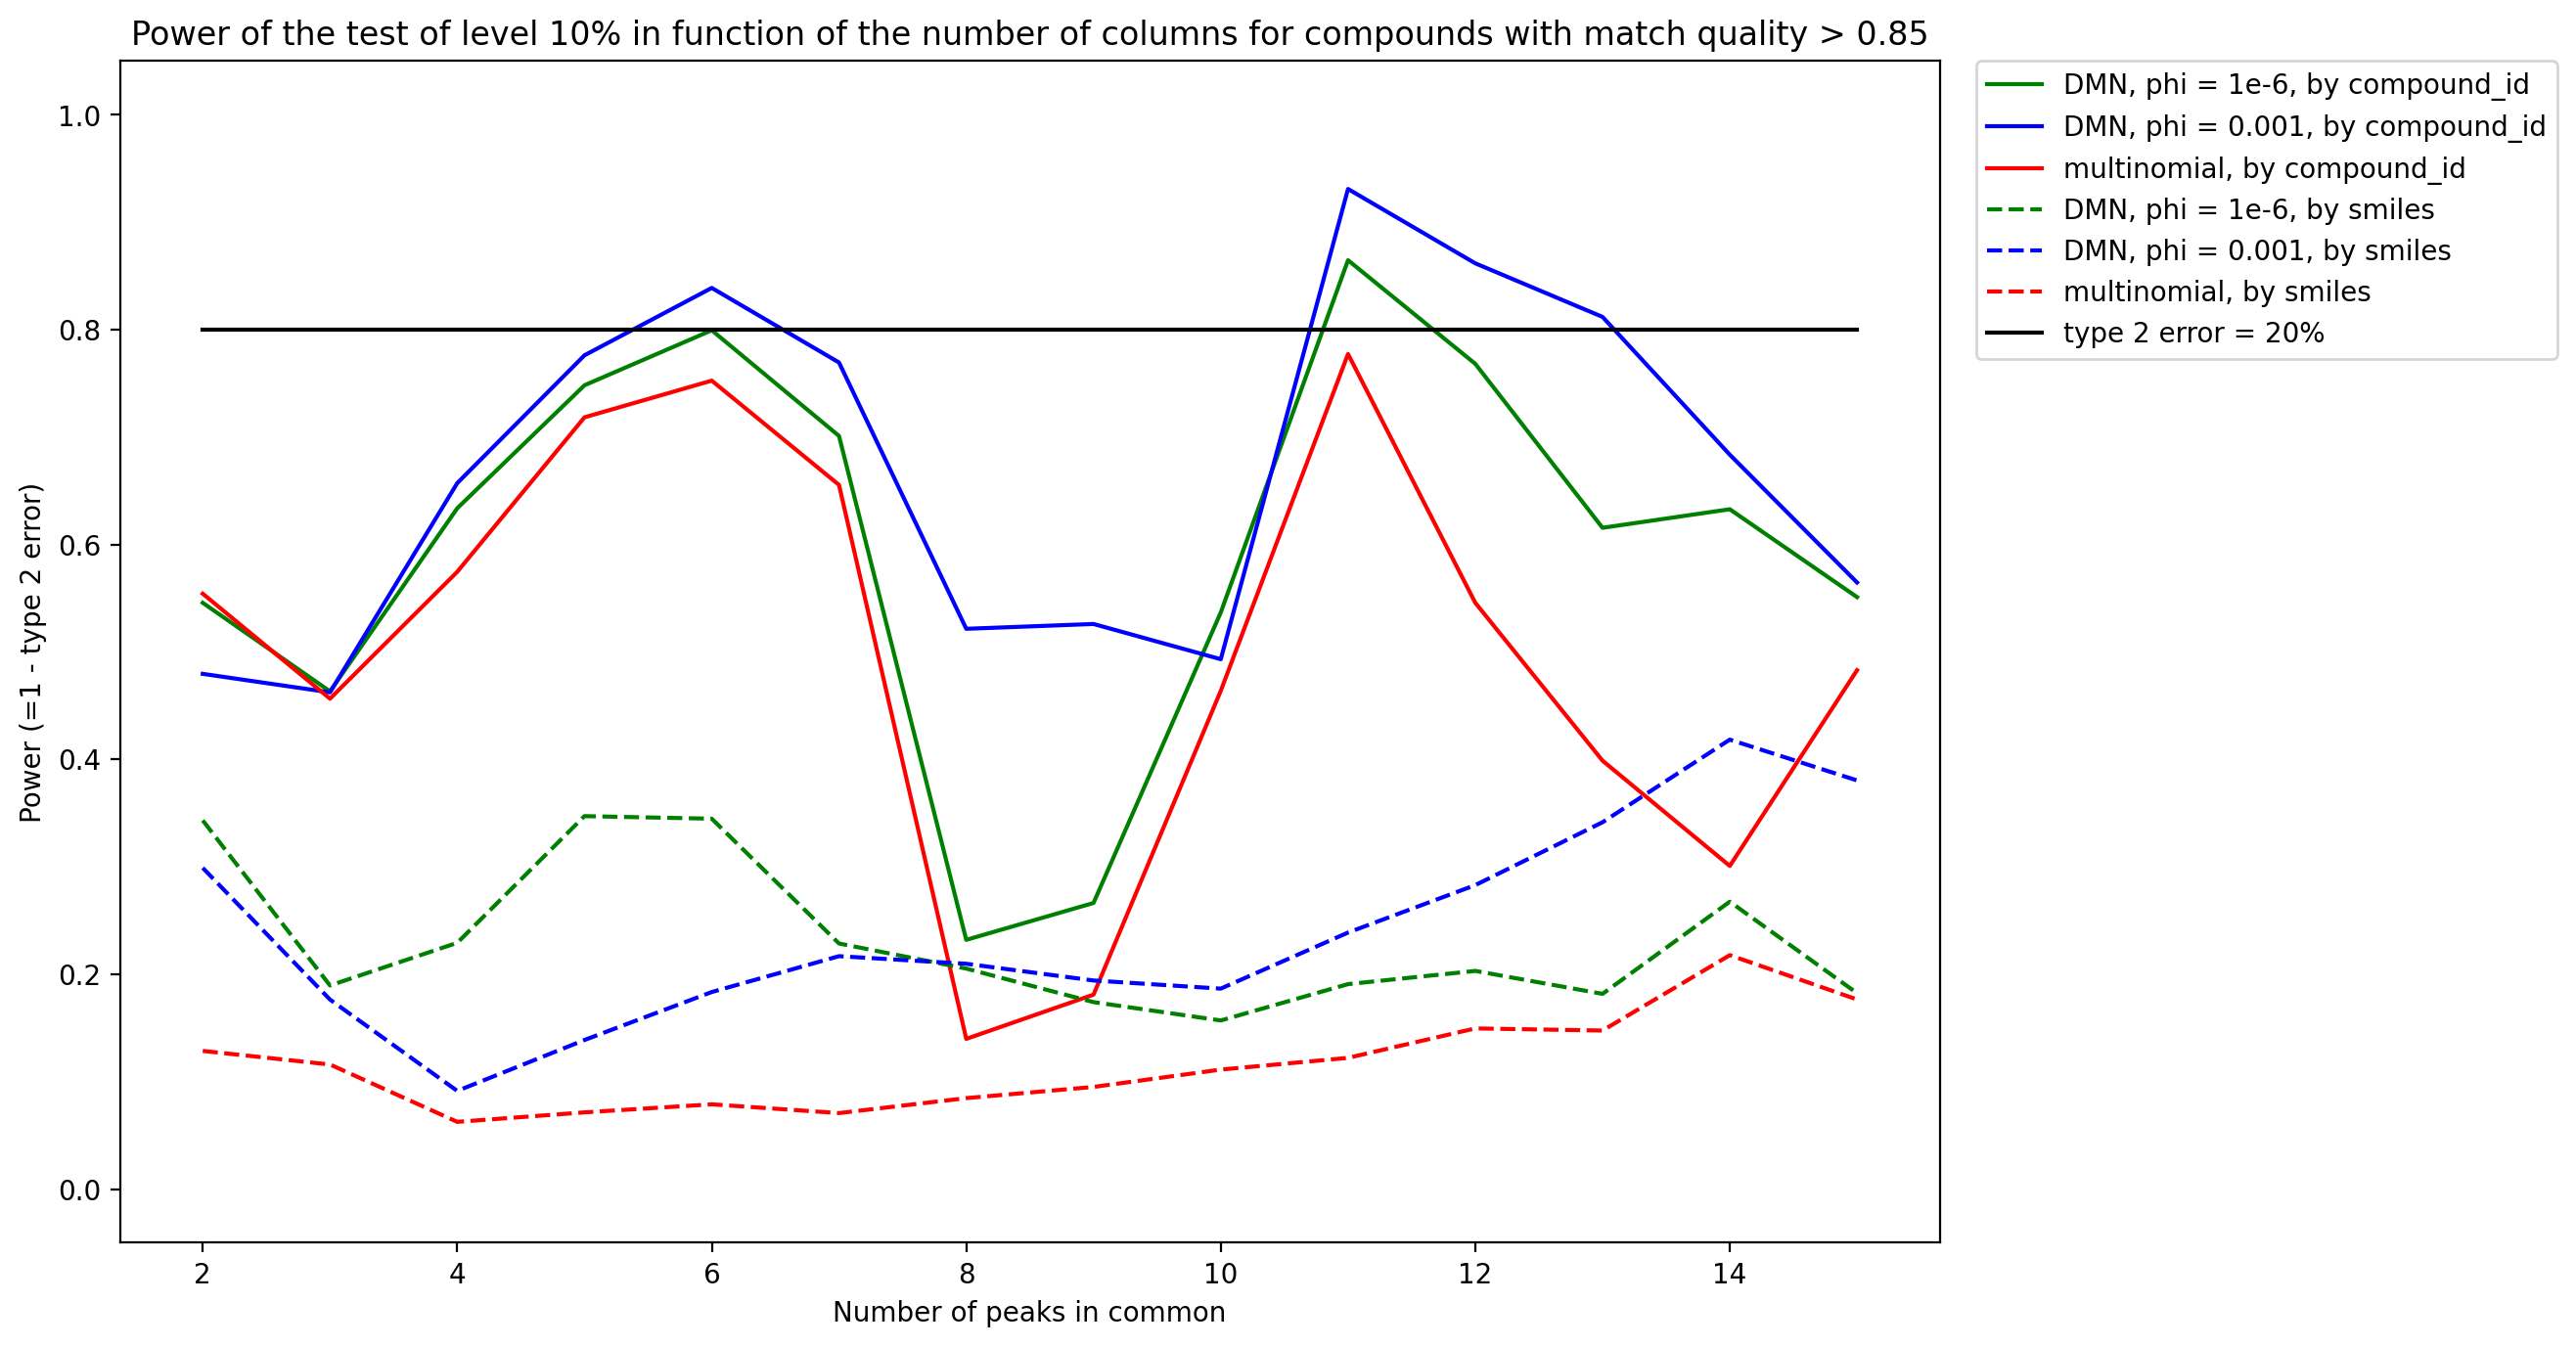

In [63]:
keys = ["1e-06", "0.001", "multinomial"]
color_code = pd.Series(["green", "blue", "red"], index = keys)
label_code = pd.Series(["DMN, phi = 1e-6", "DMN, phi = 0.001", "multinomial"], index = keys)

plt.figure(figsize = (12, 8))

for key in keys:
    stat_same = df_same_DMN[key]
    stat_diff = df_diff_DMN[key]
    
    columns_same = np.array(DMN_same["nb_col"])
    columns_diff = np.array(DMN_diff["nb_col"])
    
    
    plot_power(stat_same,
               stat_diff,
               columns_same * (np.array(DMN_same["mq"]) > .85),
               columns_diff * (np.array([max(x, y) for x, y in DMN_diff["mq"]]) > .85),
               label = label_code[key] + ", by compound_id",
               color = color_code[key],
               alpha = .1,
               max_col = 15
              )
    
for key in keys:
    stat_same = df_same_smiles[key]
    stat_diff = df_diff_smiles[key]
    
    columns_same = same_smiles_info["nb_col"]
    columns_diff = diff_smiles_info["nb_col"]
    
    plot_power(stat_same,
               stat_diff,
               columns_same * (same_smiles_info["mmq"] > 0.85),
               columns_diff * (diff_smiles_info["mmq"] > 0.85),
               style = "--",
               label = label_code[key] + ", by smiles",
               color = color_code[key],
               alpha = .1,
               max_col = 15
              )

plt.plot([2, 15], [0, 0], "white")
plt.plot([2, 15], [1, 1], "white")
plt.plot([2, 15], [.8, .8], c = "k", label = "type 2 error = 20%")

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel("Number of peaks in common")
plt.ylabel("Power (=1 - type 2 error)")
plt.title("Power of the test of level 10% in function of the number of columns for compounds with match quality > 0.85")
plt.show()

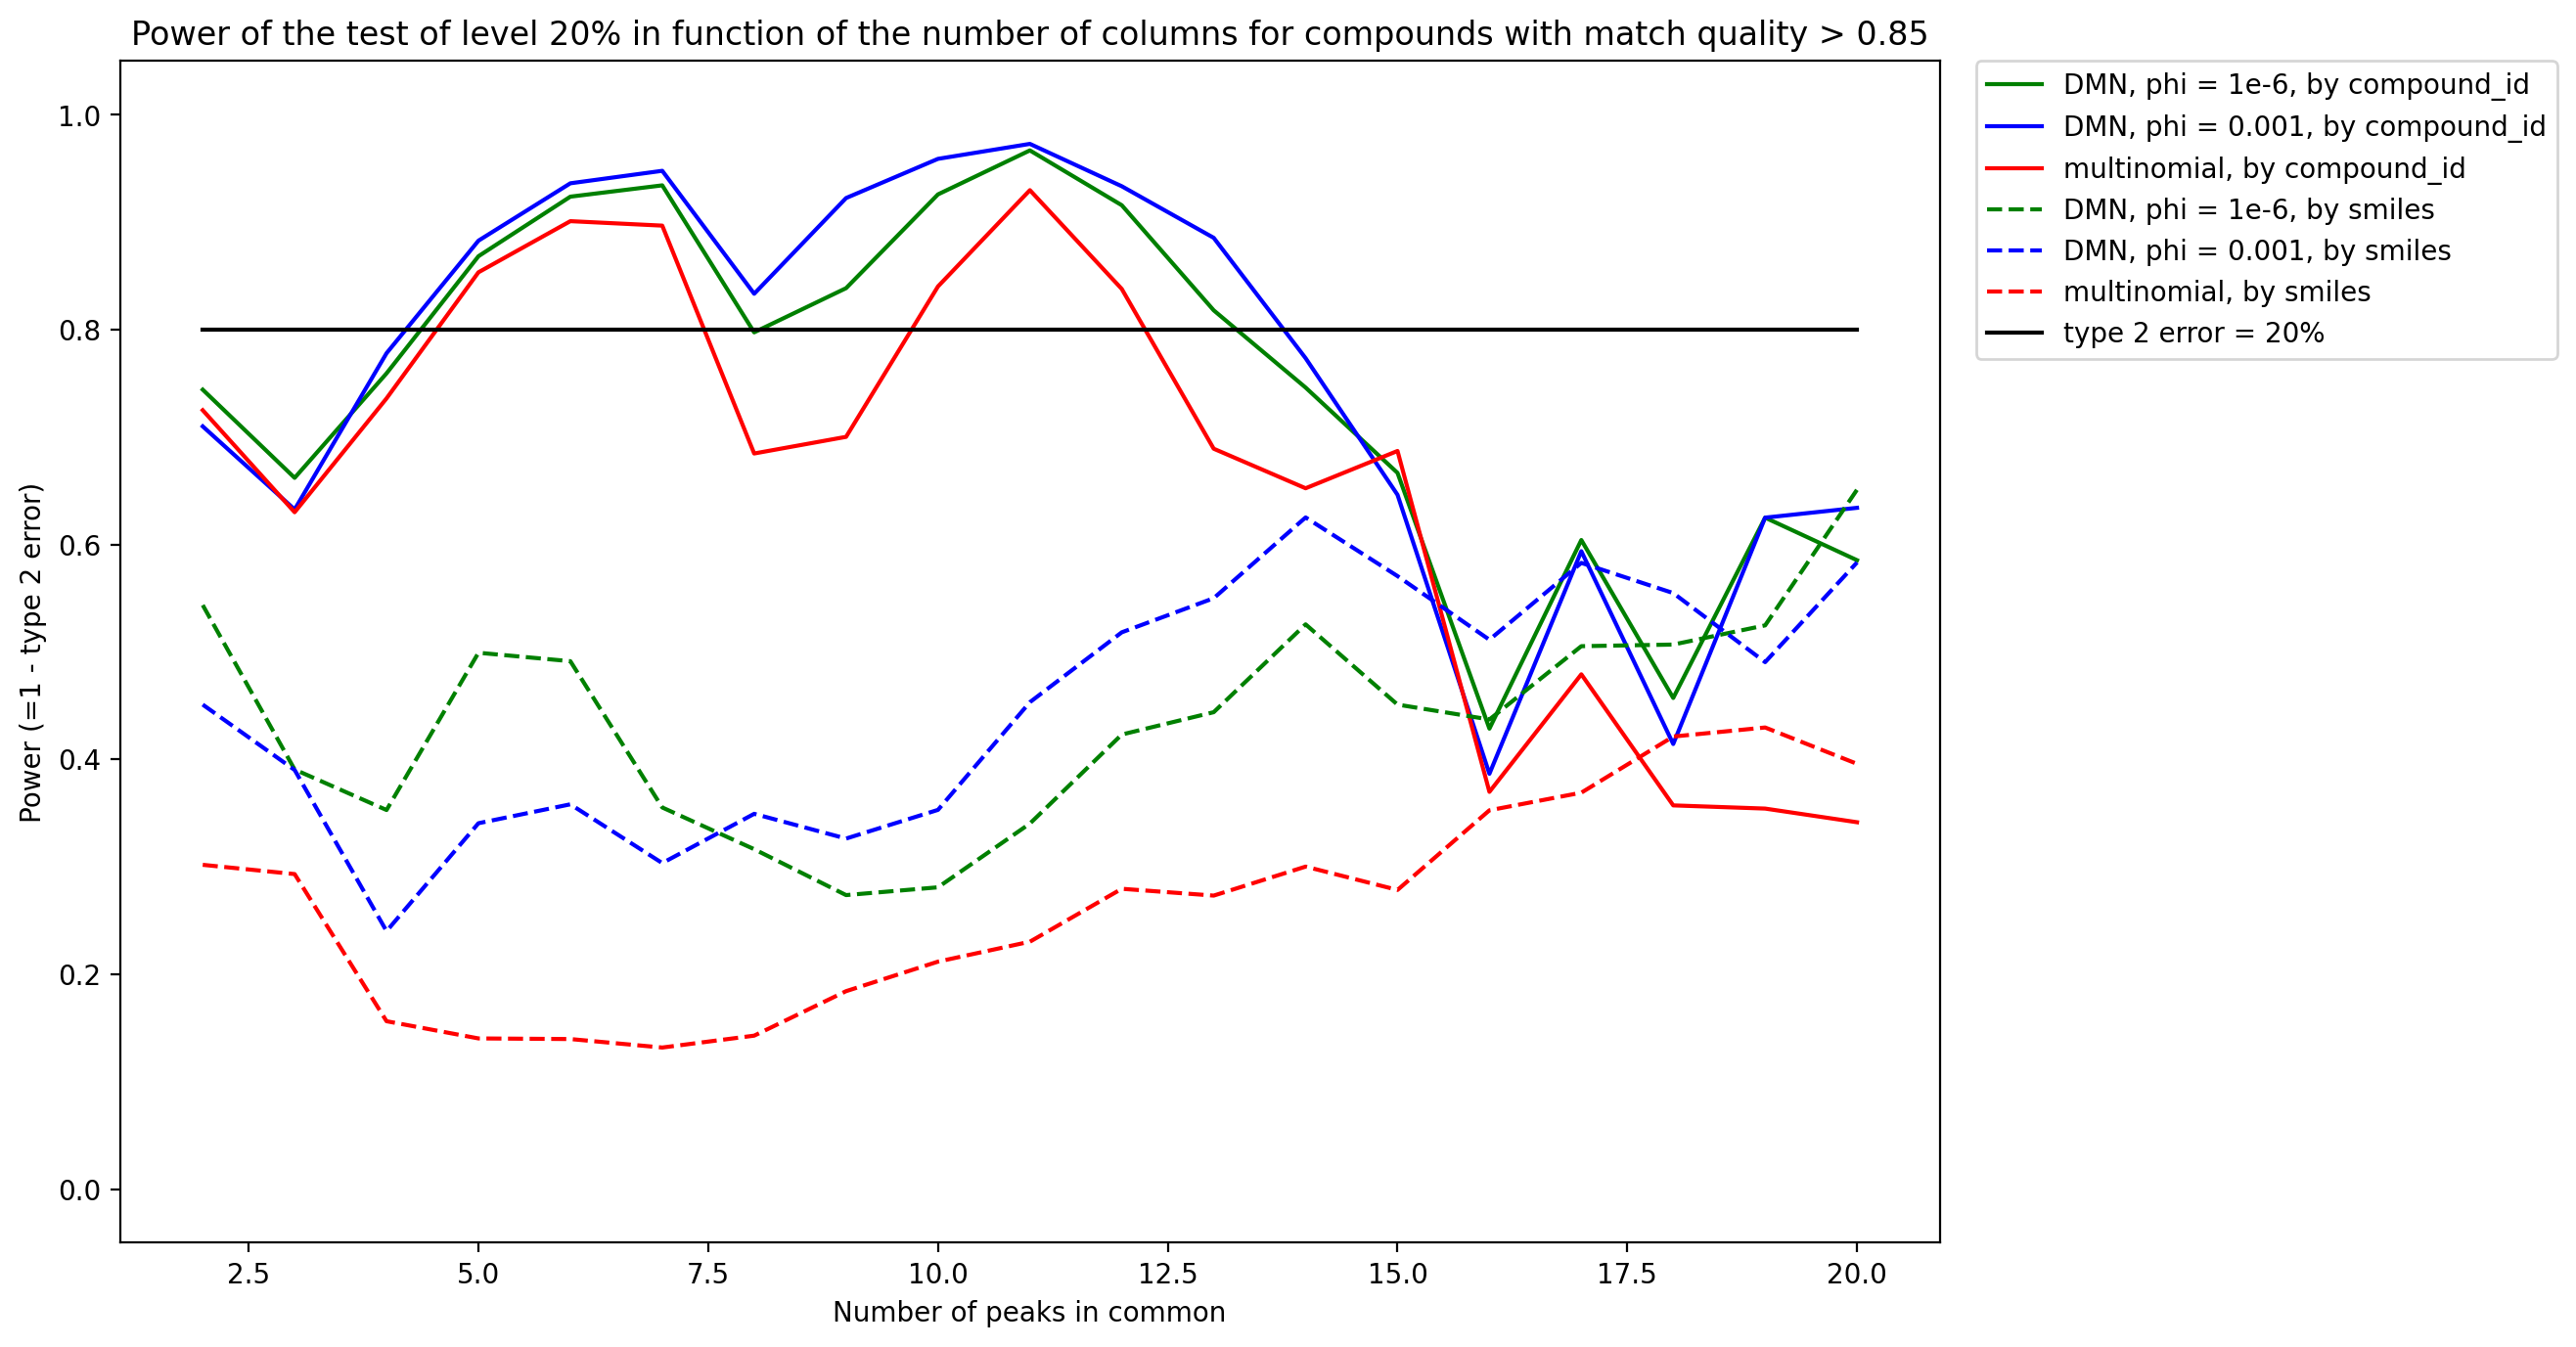

In [64]:
keys = ["1e-06", "0.001", "multinomial"]
color_code = pd.Series(["green", "blue", "red"], index = keys)
label_code = pd.Series(["DMN, phi = 1e-6", "DMN, phi = 0.001", "multinomial"], index = keys)

alpha = .2
max_col = 20

plt.figure(figsize = (12, 8))

for key in keys:
    stat_same = df_same_DMN[key]
    stat_diff = df_diff_DMN[key]
    
    columns_same = np.array(DMN_same["nb_col"])
    columns_diff = np.array(DMN_diff["nb_col"])
    
    
    plot_power(stat_same,
               stat_diff,
               columns_same * (np.array(DMN_same["mq"]) > .85),
               columns_diff * (np.array([max(x, y) for x, y in DMN_diff["mq"]]) > .85),
               label = label_code[key] + ", by compound_id",
               color = color_code[key],
               alpha = alpha,
               max_col = max_col
              )
    
for key in keys:
    stat_same = df_same_smiles[key]
    stat_diff = df_diff_smiles[key]
    
    columns_same = same_smiles_info["nb_col"]
    columns_diff = diff_smiles_info["nb_col"]
    
    plot_power(stat_same,
               stat_diff,
               columns_same * (same_smiles_info["mmq"] > 0.85),
               columns_diff * (diff_smiles_info["mmq"] > 0.85),
               style = "--",
               label = label_code[key] + ", by smiles",
               color = color_code[key],
               alpha = alpha,
               max_col = max_col
              )

plt.plot([2, max_col], [0, 0], "white")
plt.plot([2, max_col], [1, 1], "white")
plt.plot([2, max_col], [.8, .8], c = "k", label = "type 2 error = 20%")

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel("Number of peaks in common")
plt.ylabel("Power (=1 - type 2 error)")
plt.title("Power of the test of level " + str(int(100 * alpha)) + "% in function of the number of columns for compounds with match quality > 0.85")
plt.show()

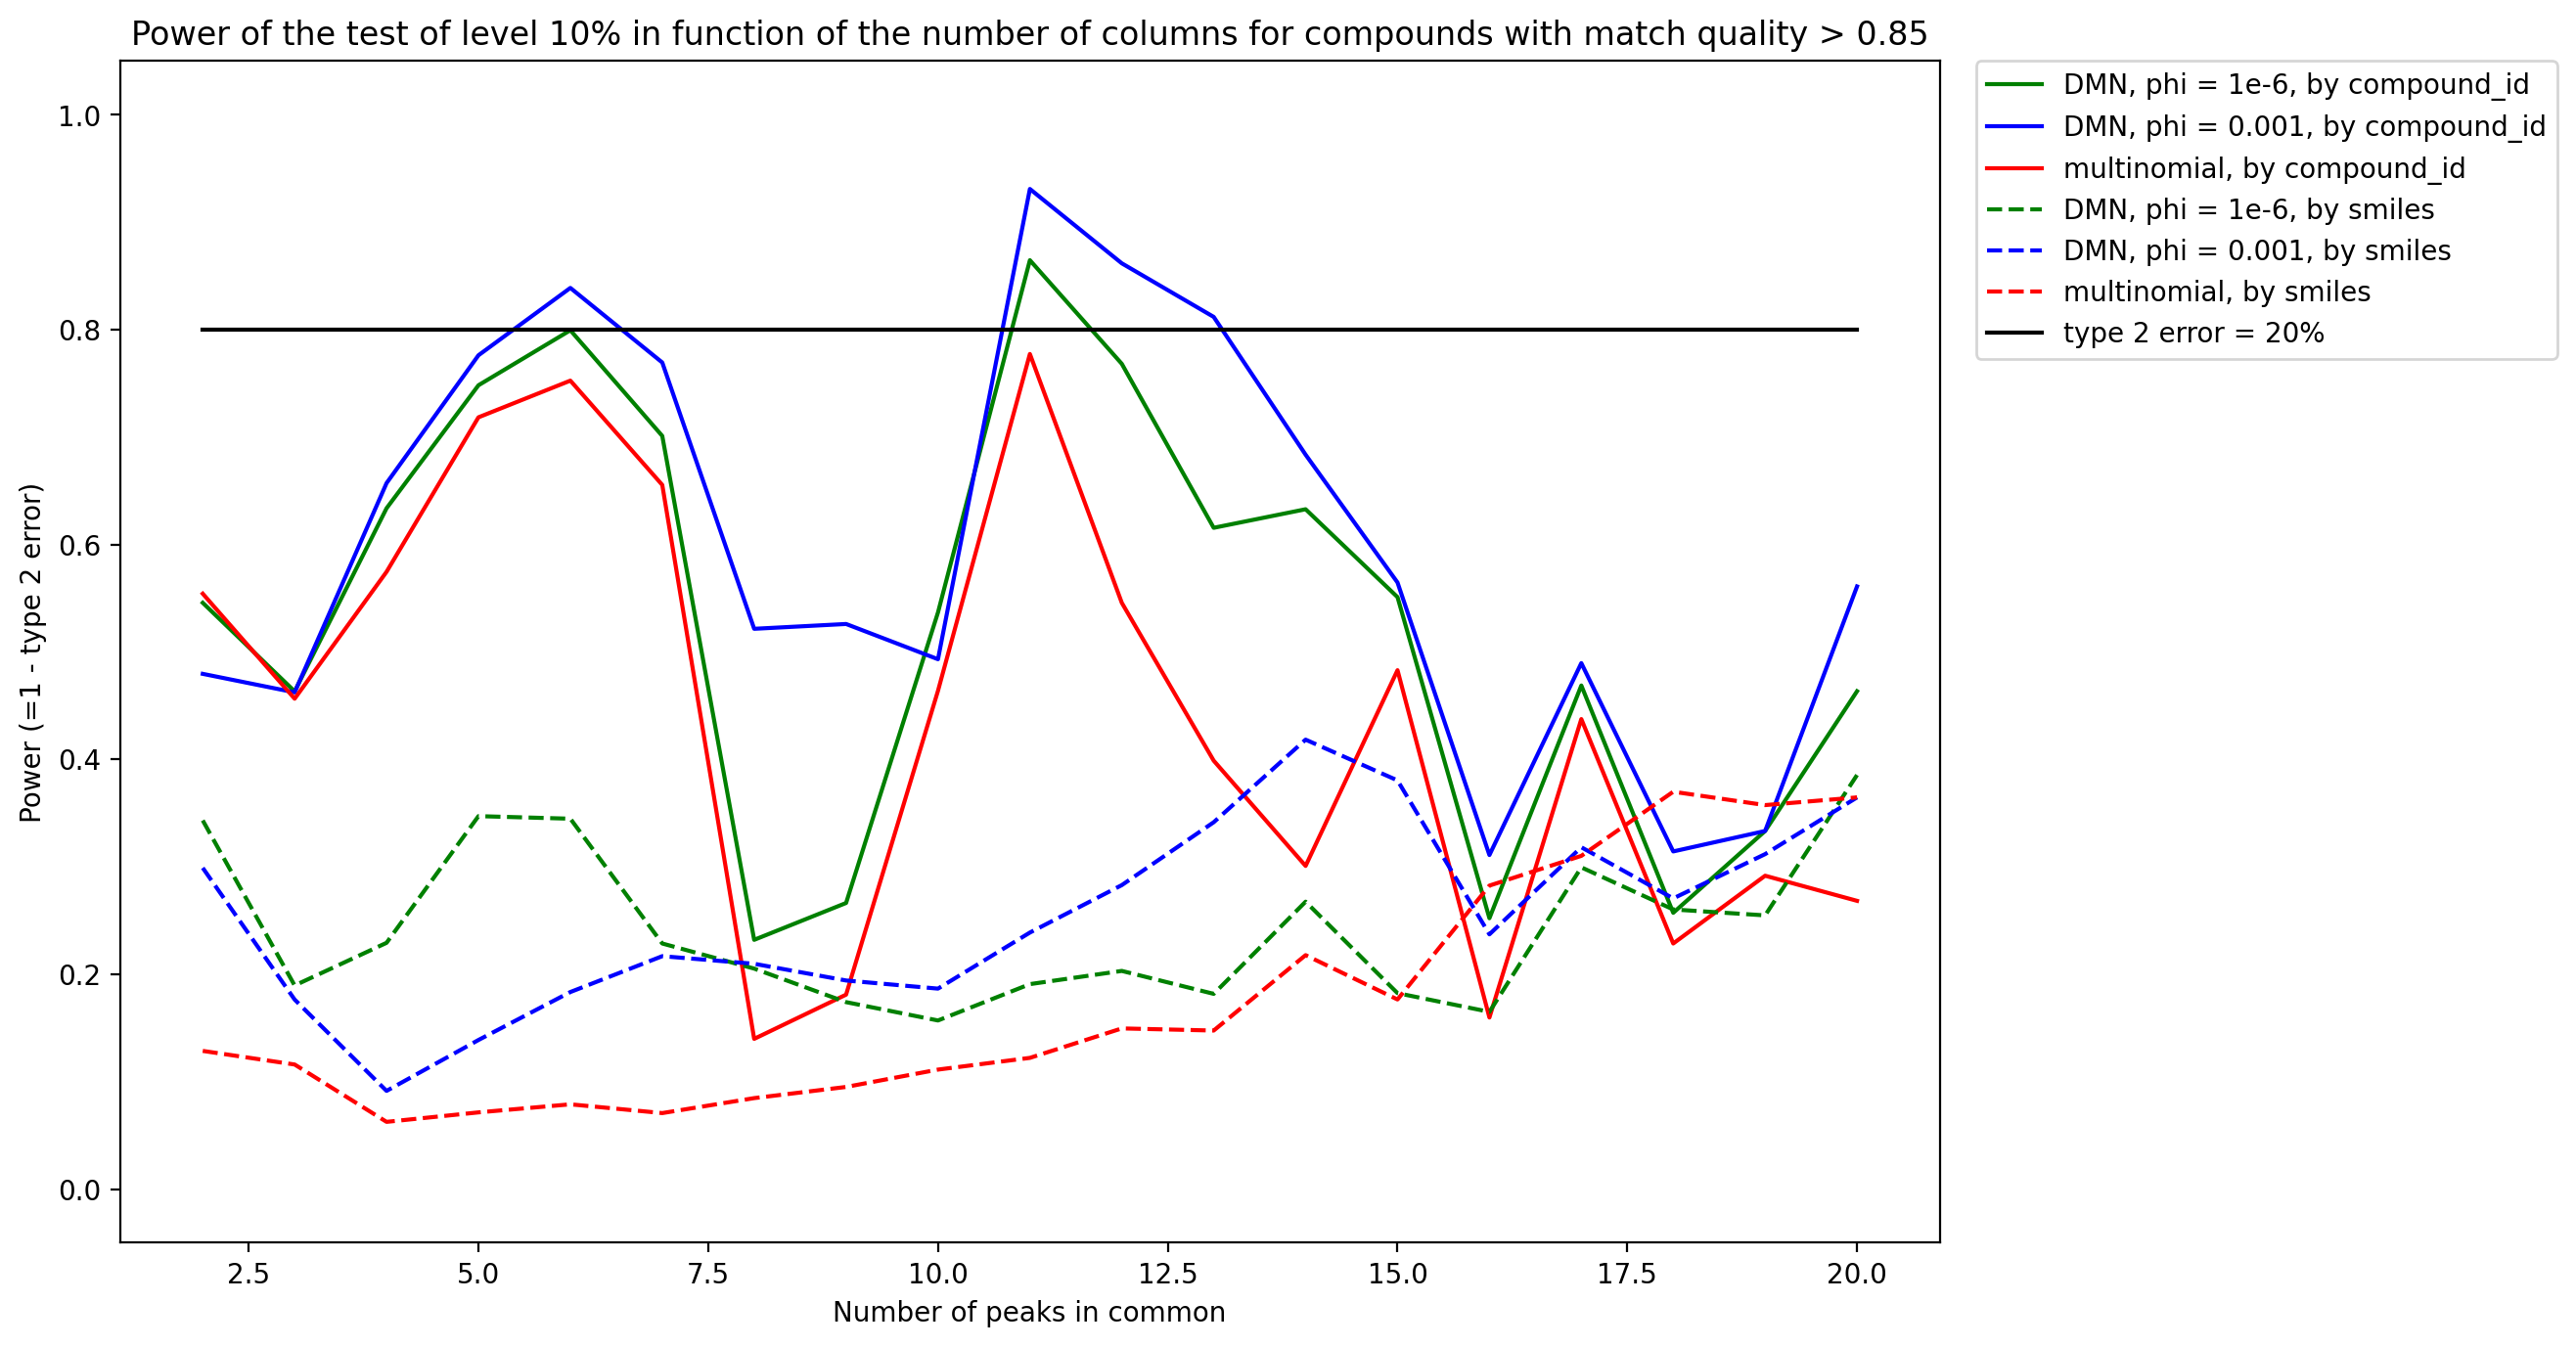

In [65]:
keys = ["1e-06", "0.001", "multinomial"]
color_code = pd.Series(["green", "blue", "red"], index = keys)
label_code = pd.Series(["DMN, phi = 1e-6", "DMN, phi = 0.001", "multinomial"], index = keys)

alpha = .1
max_col = 20

plt.figure(figsize = (12, 8))

for key in keys:
    stat_same = df_same_DMN[key]
    stat_diff = df_diff_DMN[key]
    
    columns_same = np.array(DMN_same["nb_col"])
    columns_diff = np.array(DMN_diff["nb_col"])
    
    
    plot_power(stat_same,
               stat_diff,
               columns_same * (np.array(DMN_same["mq"]) > .85),
               columns_diff * (np.array([max(x, y) for x, y in DMN_diff["mq"]]) > .85),
               label = label_code[key] + ", by compound_id",
               color = color_code[key],
               alpha = alpha,
               max_col = max_col
              )
    
for key in keys:
    stat_same = df_same_smiles[key]
    stat_diff = df_diff_smiles[key]
    
    columns_same = same_smiles_info["nb_col"]
    columns_diff = diff_smiles_info["nb_col"]
    
    plot_power(stat_same,
               stat_diff,
               columns_same * (same_smiles_info["mmq"] > 0.85),
               columns_diff * (diff_smiles_info["mmq"] > 0.85),
               style = "--",
               label = label_code[key] + ", by smiles",
               color = color_code[key],
               alpha = alpha,
               max_col = max_col
              )

plt.plot([2, max_col], [0, 0], "white")
plt.plot([2, max_col], [1, 1], "white")
plt.plot([2, max_col], [.8, .8], c = "k", label = "type 2 error = 20%")

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel("Number of peaks in common")
plt.ylabel("Power (=1 - type 2 error)")
plt.title("Power of the test of level " + str(int(100 * alpha)) + "% in function of the number of columns for compounds with match quality > 0.85")
plt.show()

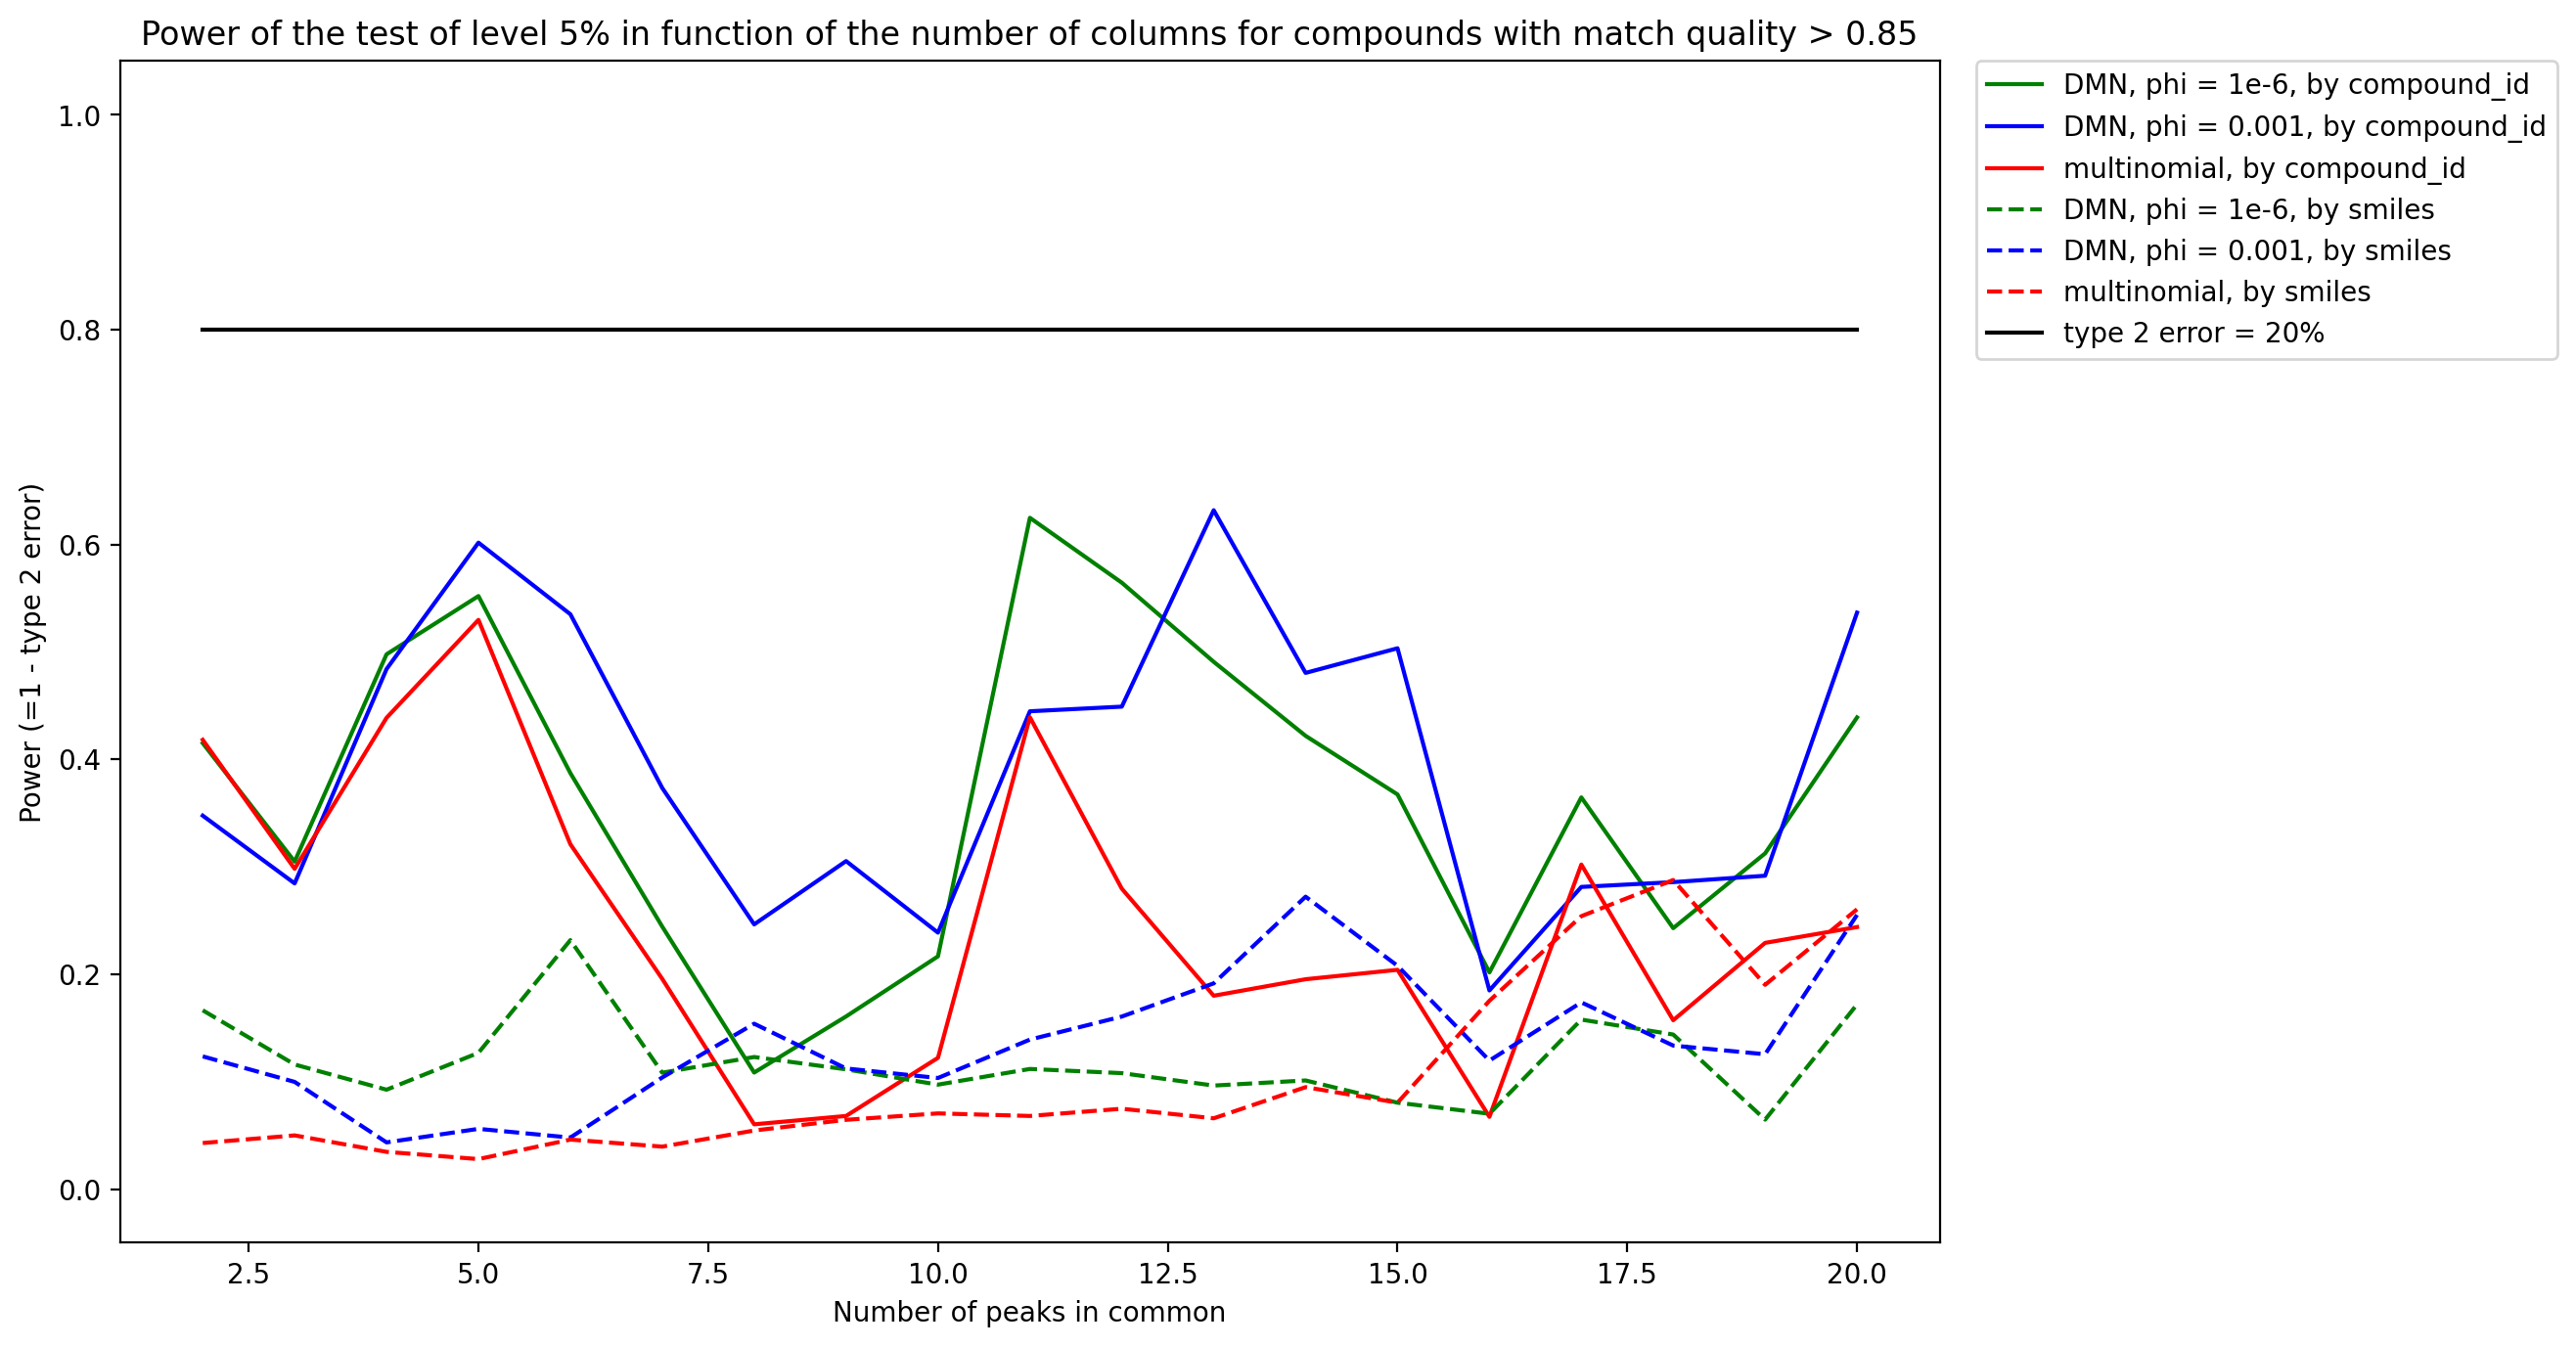

In [66]:
keys = ["1e-06", "0.001", "multinomial"]
color_code = pd.Series(["green", "blue", "red"], index = keys)
label_code = pd.Series(["DMN, phi = 1e-6", "DMN, phi = 0.001", "multinomial"], index = keys)

alpha = .05
max_col = 20

plt.figure(figsize = (12, 8))

for key in keys:
    stat_same = df_same_DMN[key]
    stat_diff = df_diff_DMN[key]
    
    columns_same = np.array(DMN_same["nb_col"])
    columns_diff = np.array(DMN_diff["nb_col"])
    
    
    plot_power(stat_same,
               stat_diff,
               columns_same * (np.array(DMN_same["mq"]) > .85),
               columns_diff * (np.array([max(x, y) for x, y in DMN_diff["mq"]]) > .85),
               label = label_code[key] + ", by compound_id",
               color = color_code[key],
               alpha = alpha,
               max_col = max_col
              )
    
for key in keys:
    stat_same = df_same_smiles[key]
    stat_diff = df_diff_smiles[key]
    
    columns_same = same_smiles_info["nb_col"]
    columns_diff = diff_smiles_info["nb_col"]
    
    plot_power(stat_same,
               stat_diff,
               columns_same * (same_smiles_info["mmq"] > 0.85),
               columns_diff * (diff_smiles_info["mmq"] > 0.85),
               style = "--",
               label = label_code[key] + ", by smiles",
               color = color_code[key],
               alpha = alpha,
               max_col = max_col
              )

plt.plot([2, max_col], [0, 0], "white")
plt.plot([2, max_col], [1, 1], "white")
plt.plot([2, max_col], [.8, .8], c = "k", label = "type 2 error = 20%")

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel("Number of peaks in common")
plt.ylabel("Power (=1 - type 2 error)")
plt.title("Power of the test of level " + str(int(100 * alpha)) + "% in function of the number of columns for compounds with match quality > 0.85")
plt.show()

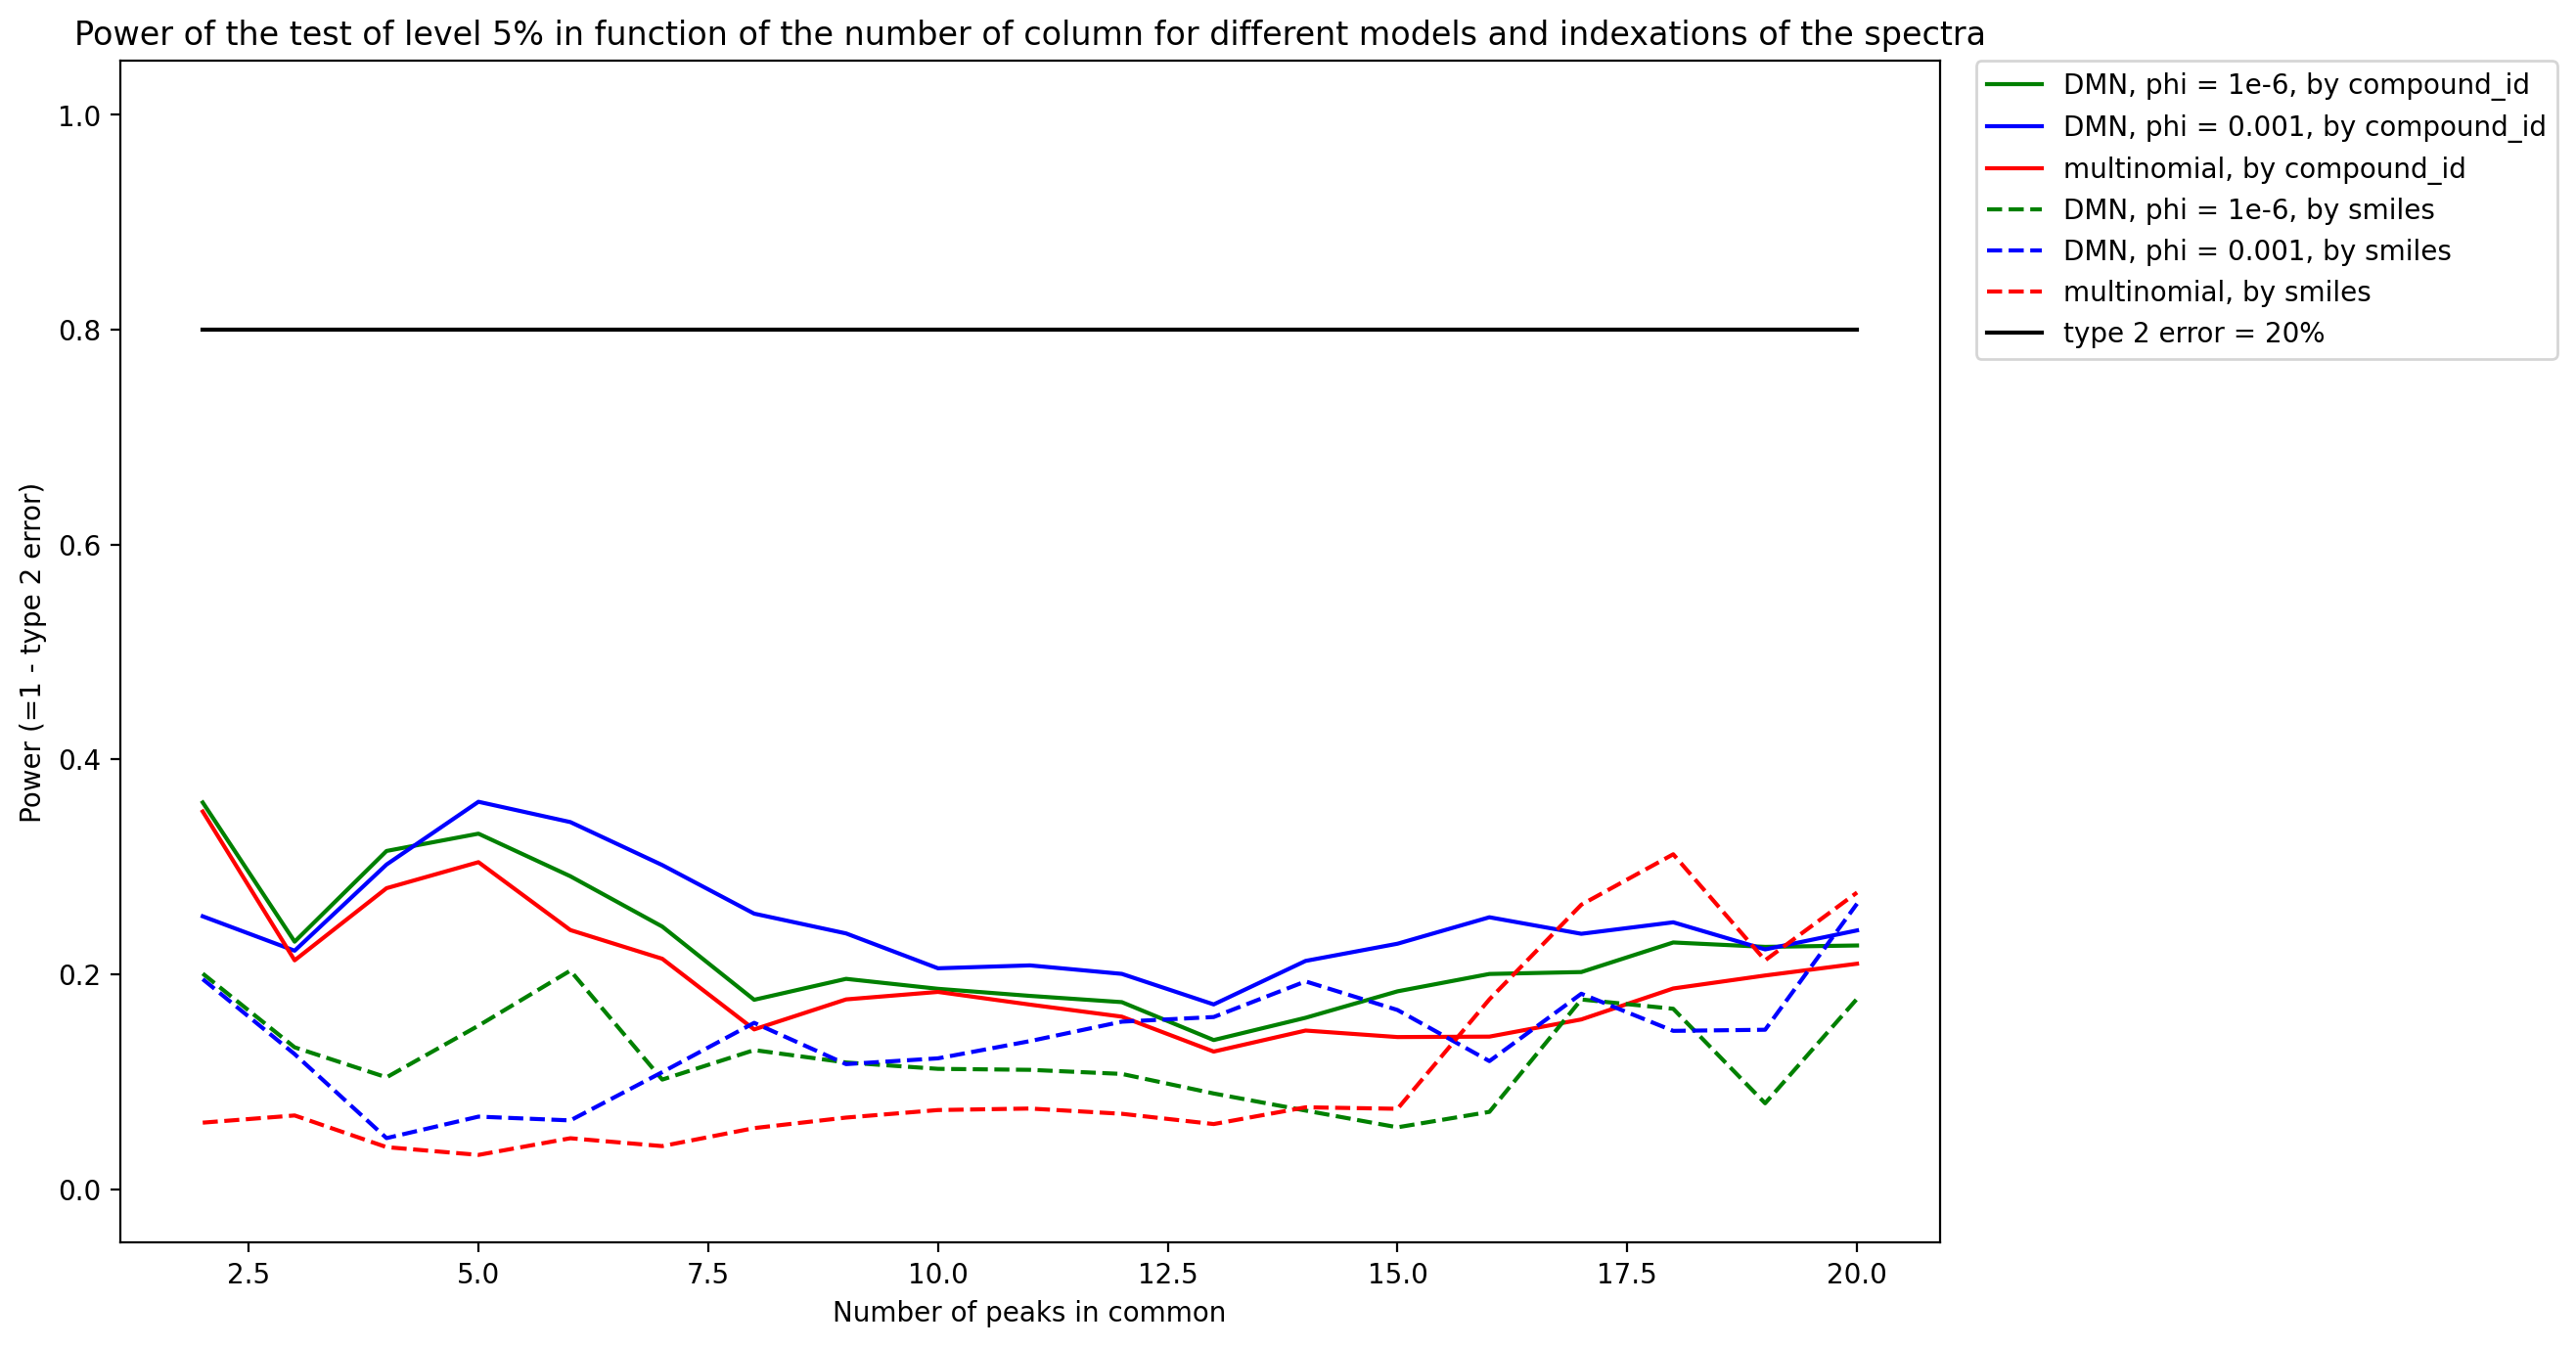

In [67]:
keys = ["1e-06", "0.001", "multinomial"]
color_code = pd.Series(["green", "blue", "red"], index = keys)
label_code = pd.Series(["DMN, phi = 1e-6", "DMN, phi = 0.001", "multinomial"], index = keys)

alpha = .05
max_col = 20

plt.figure(figsize = (12, 8))

for key in keys:
    stat_same = df_same_DMN[key]
    stat_diff = df_diff_DMN[key]
    
    columns_same = np.array(DMN_same["nb_col"])
    columns_diff = np.array(DMN_diff["nb_col"])
    
    
    plot_power(stat_same,
               stat_diff,
               columns_same,
               columns_diff,
               label = label_code[key] + ", by compound_id",
               color = color_code[key],
               alpha = alpha,
               max_col = max_col
              )
    
for key in keys:
    stat_same = df_same_smiles[key]
    stat_diff = df_diff_smiles[key]
    
    columns_same = same_smiles_info["nb_col"]
    columns_diff = diff_smiles_info["nb_col"]
    
    plot_power(stat_same,
               stat_diff,
               columns_same,
               columns_diff,
               style = "--",
               label = label_code[key] + ", by smiles",
               color = color_code[key],
               alpha = alpha,
               max_col = max_col
              )

plt.plot([2, max_col], [0, 0], "white")
plt.plot([2, max_col], [1, 1], "white")
plt.plot([2, max_col], [.8, .8], c = "k", label = "type 2 error = 20%")

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel("Number of peaks in common")
plt.ylabel("Power (=1 - type 2 error)")
plt.title("Power of the test of level " + str(int(100 * alpha)) + "% in function of the number of column for different models and indexations of the spectra")
plt.show()

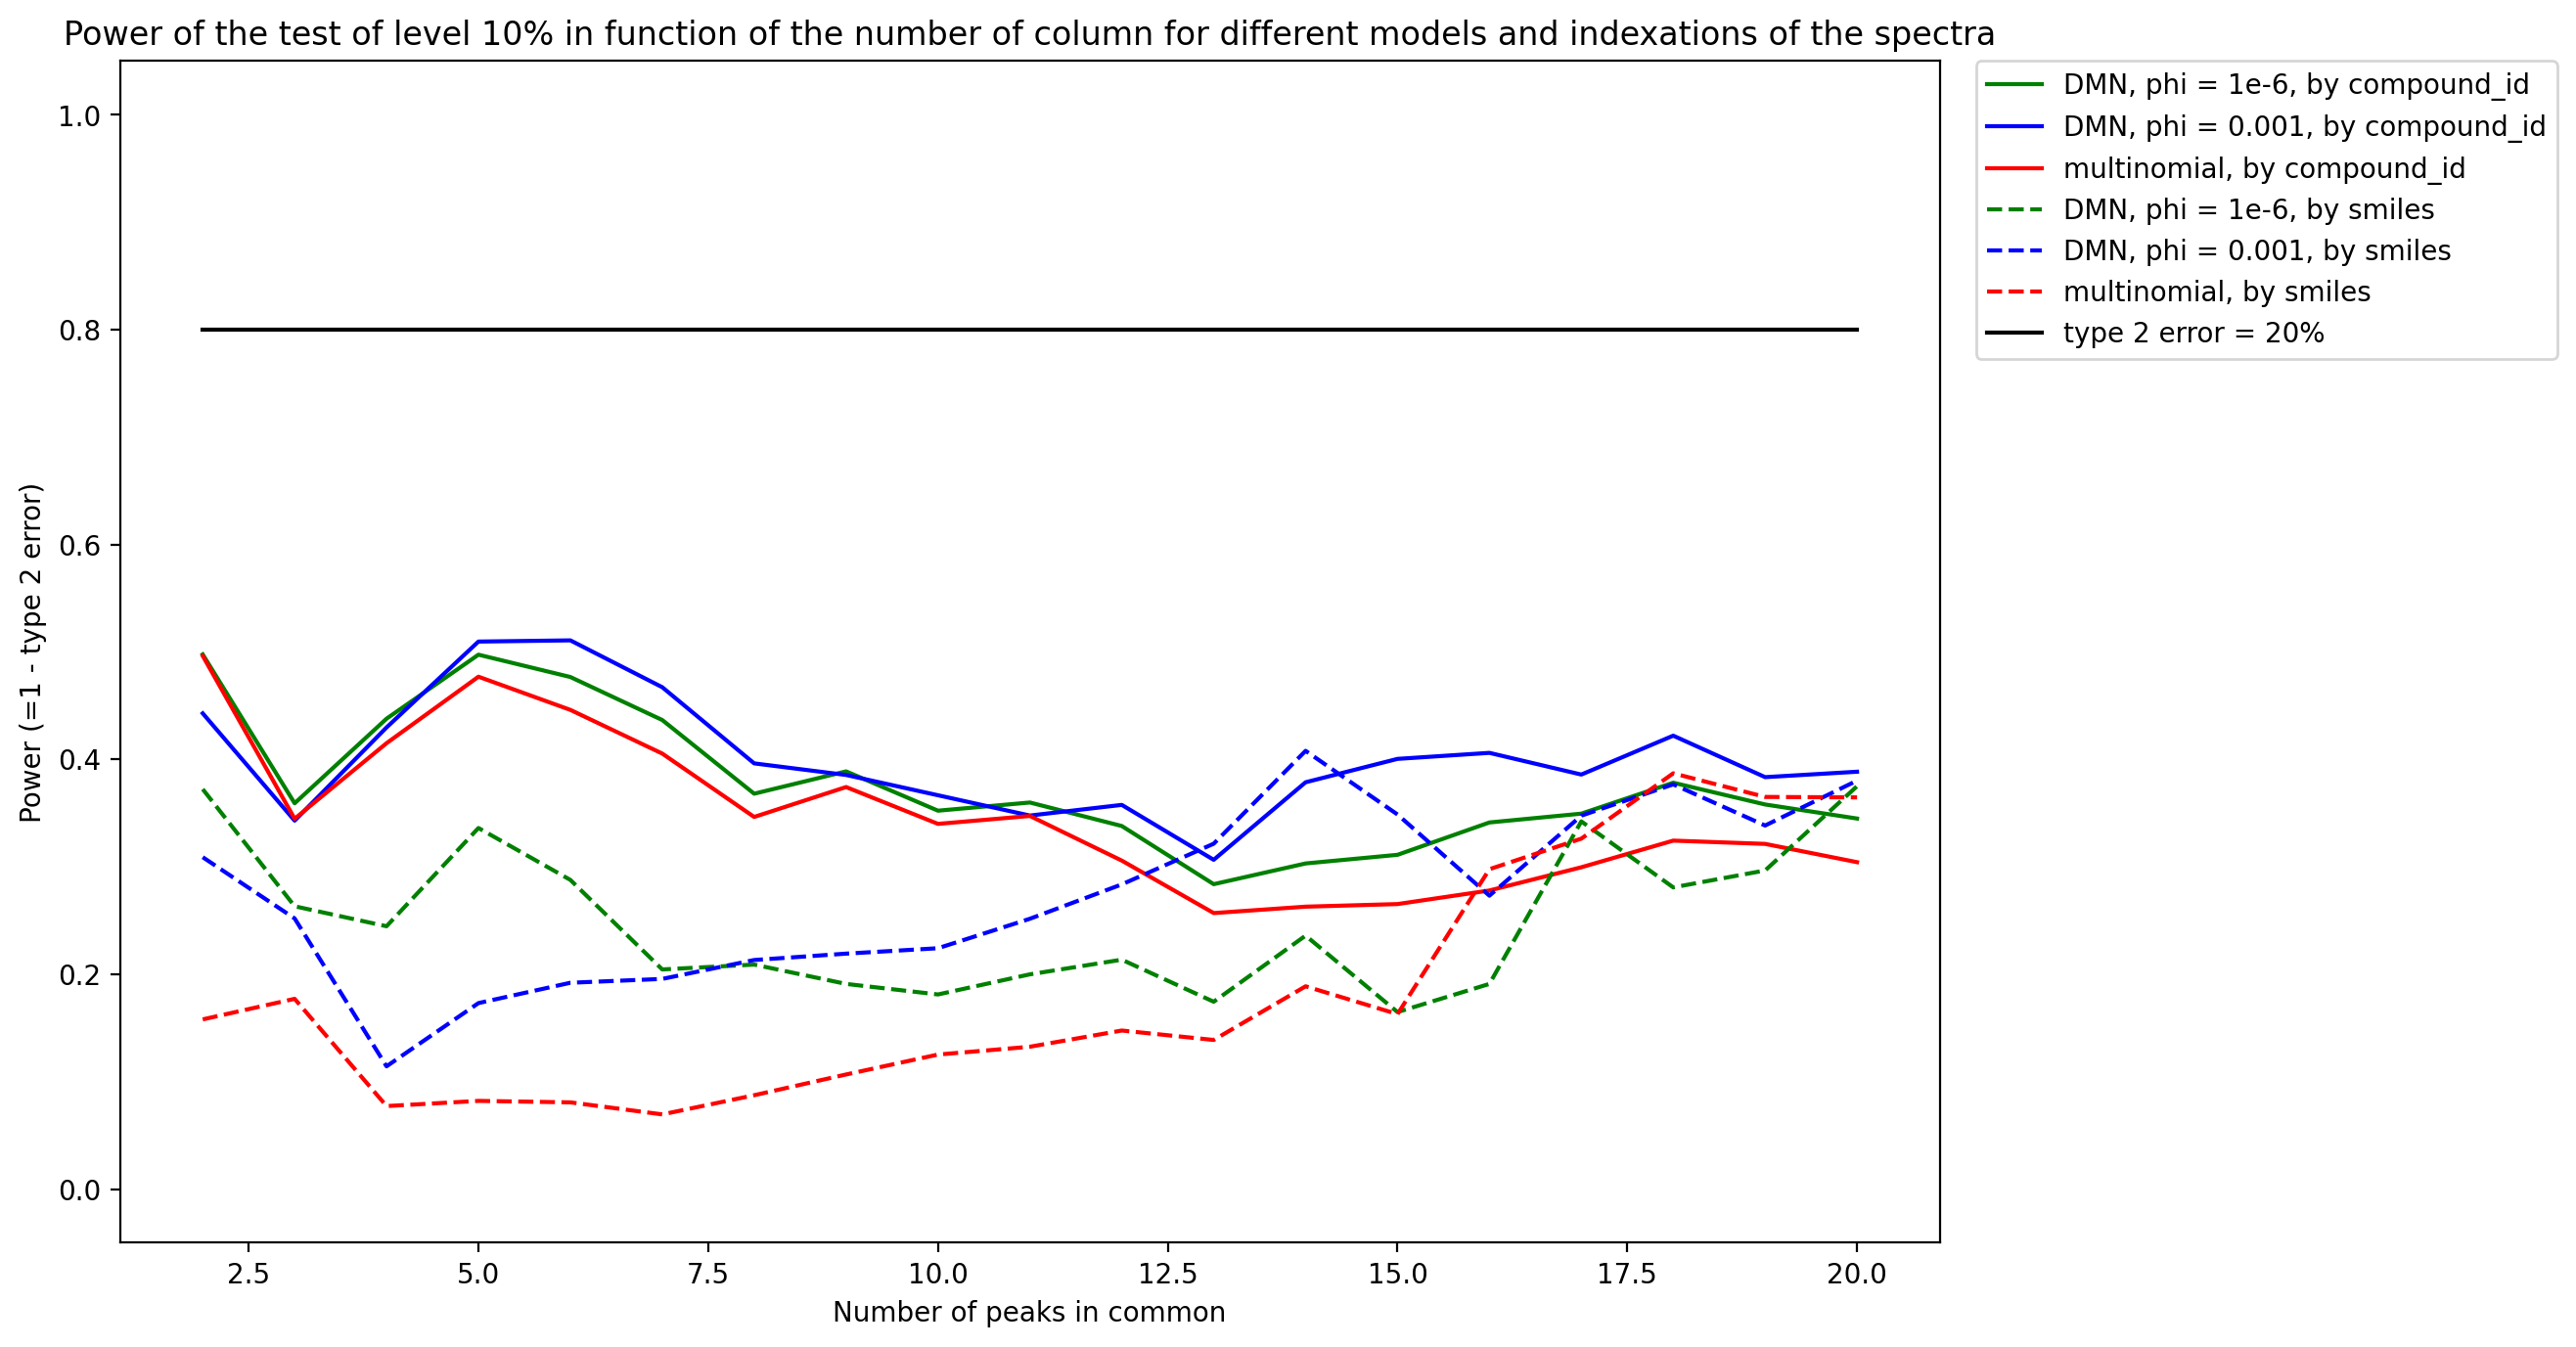

In [68]:
keys = ["1e-06", "0.001", "multinomial"]
color_code = pd.Series(["green", "blue", "red"], index = keys)
label_code = pd.Series(["DMN, phi = 1e-6", "DMN, phi = 0.001", "multinomial"], index = keys)

alpha = .1
max_col = 20

plt.figure(figsize = (12, 8))

for key in keys:
    stat_same = df_same_DMN[key]
    stat_diff = df_diff_DMN[key]
    
    columns_same = np.array(DMN_same["nb_col"])
    columns_diff = np.array(DMN_diff["nb_col"])
    
    
    plot_power(stat_same,
               stat_diff,
               columns_same,
               columns_diff,
               label = label_code[key] + ", by compound_id",
               color = color_code[key],
               alpha = alpha,
               max_col = max_col
              )
    
for key in keys:
    stat_same = df_same_smiles[key]
    stat_diff = df_diff_smiles[key]
    
    columns_same = same_smiles_info["nb_col"]
    columns_diff = diff_smiles_info["nb_col"]
    
    plot_power(stat_same,
               stat_diff,
               columns_same,
               columns_diff,
               style = "--",
               label = label_code[key] + ", by smiles",
               color = color_code[key],
               alpha = alpha,
               max_col = max_col
              )

plt.plot([2, max_col], [0, 0], "white")
plt.plot([2, max_col], [1, 1], "white")
plt.plot([2, max_col], [.8, .8], c = "k", label = "type 2 error = 20%")

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel("Number of peaks in common")
plt.ylabel("Power (=1 - type 2 error)")
plt.title("Power of the test of level " + str(int(100 * alpha)) + "% in function of the number of column for different models and indexations of the spectra")
plt.show()

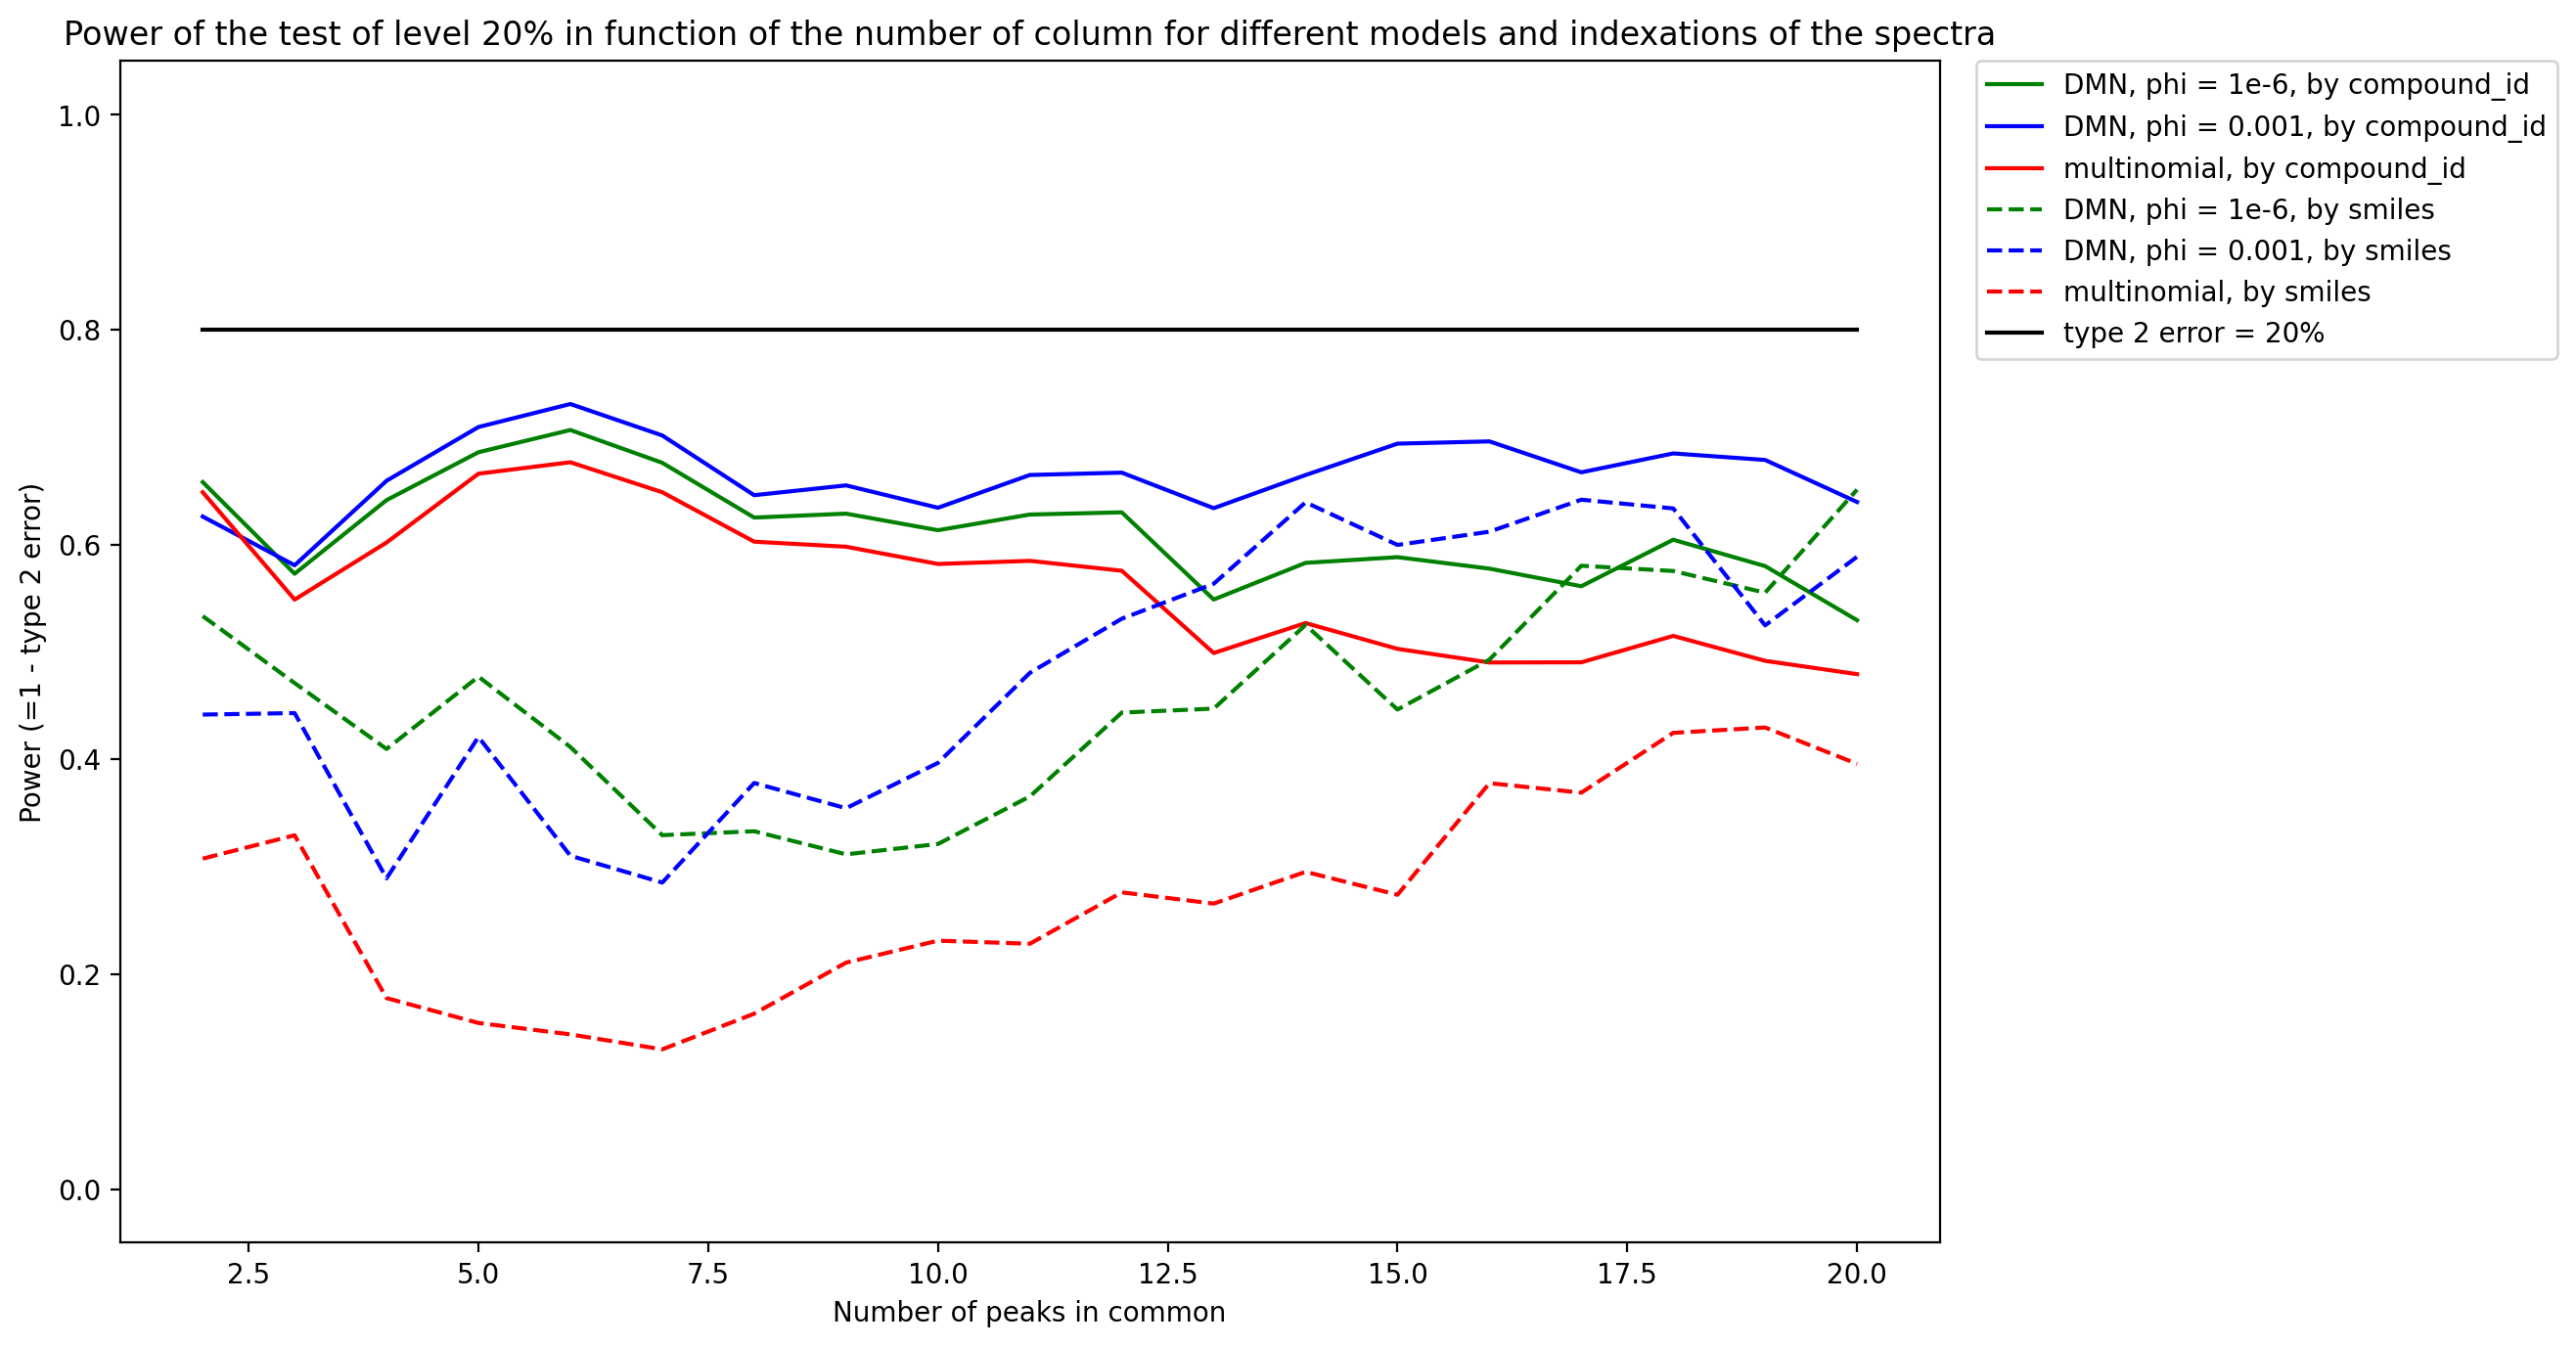

In [69]:
keys = ["1e-06", "0.001", "multinomial"]
color_code = pd.Series(["green", "blue", "red"], index = keys)
label_code = pd.Series(["DMN, phi = 1e-6", "DMN, phi = 0.001", "multinomial"], index = keys)

alpha = .2
max_col = 20

plt.figure(figsize = (12, 8))

for key in keys:
    stat_same = df_same_DMN[key]
    stat_diff = df_diff_DMN[key]
    
    columns_same = np.array(DMN_same["nb_col"])
    columns_diff = np.array(DMN_diff["nb_col"])
    
    
    plot_power(stat_same,
               stat_diff,
               columns_same,
               columns_diff,
               label = label_code[key] + ", by compound_id",
               color = color_code[key],
               alpha = alpha,
               max_col = max_col
              )
    
for key in keys:
    stat_same = df_same_smiles[key]
    stat_diff = df_diff_smiles[key]
    
    columns_same = same_smiles_info["nb_col"]
    columns_diff = diff_smiles_info["nb_col"]
    
    plot_power(stat_same,
               stat_diff,
               columns_same,
               columns_diff,
               style = "--",
               label = label_code[key] + ", by smiles",
               color = color_code[key],
               alpha = alpha,
               max_col = max_col
              )

plt.plot([2, max_col], [0, 0], "white")
plt.plot([2, max_col], [1, 1], "white")
plt.plot([2, max_col], [.8, .8], c = "k", label = "type 2 error = 20%")

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel("Number of peaks in common")
plt.ylabel("Power (=1 - type 2 error)")
plt.title("Power of the test of level " + str(int(100 * alpha)) + "% in function of the number of column for different models and indexations of the spectra")
plt.show()

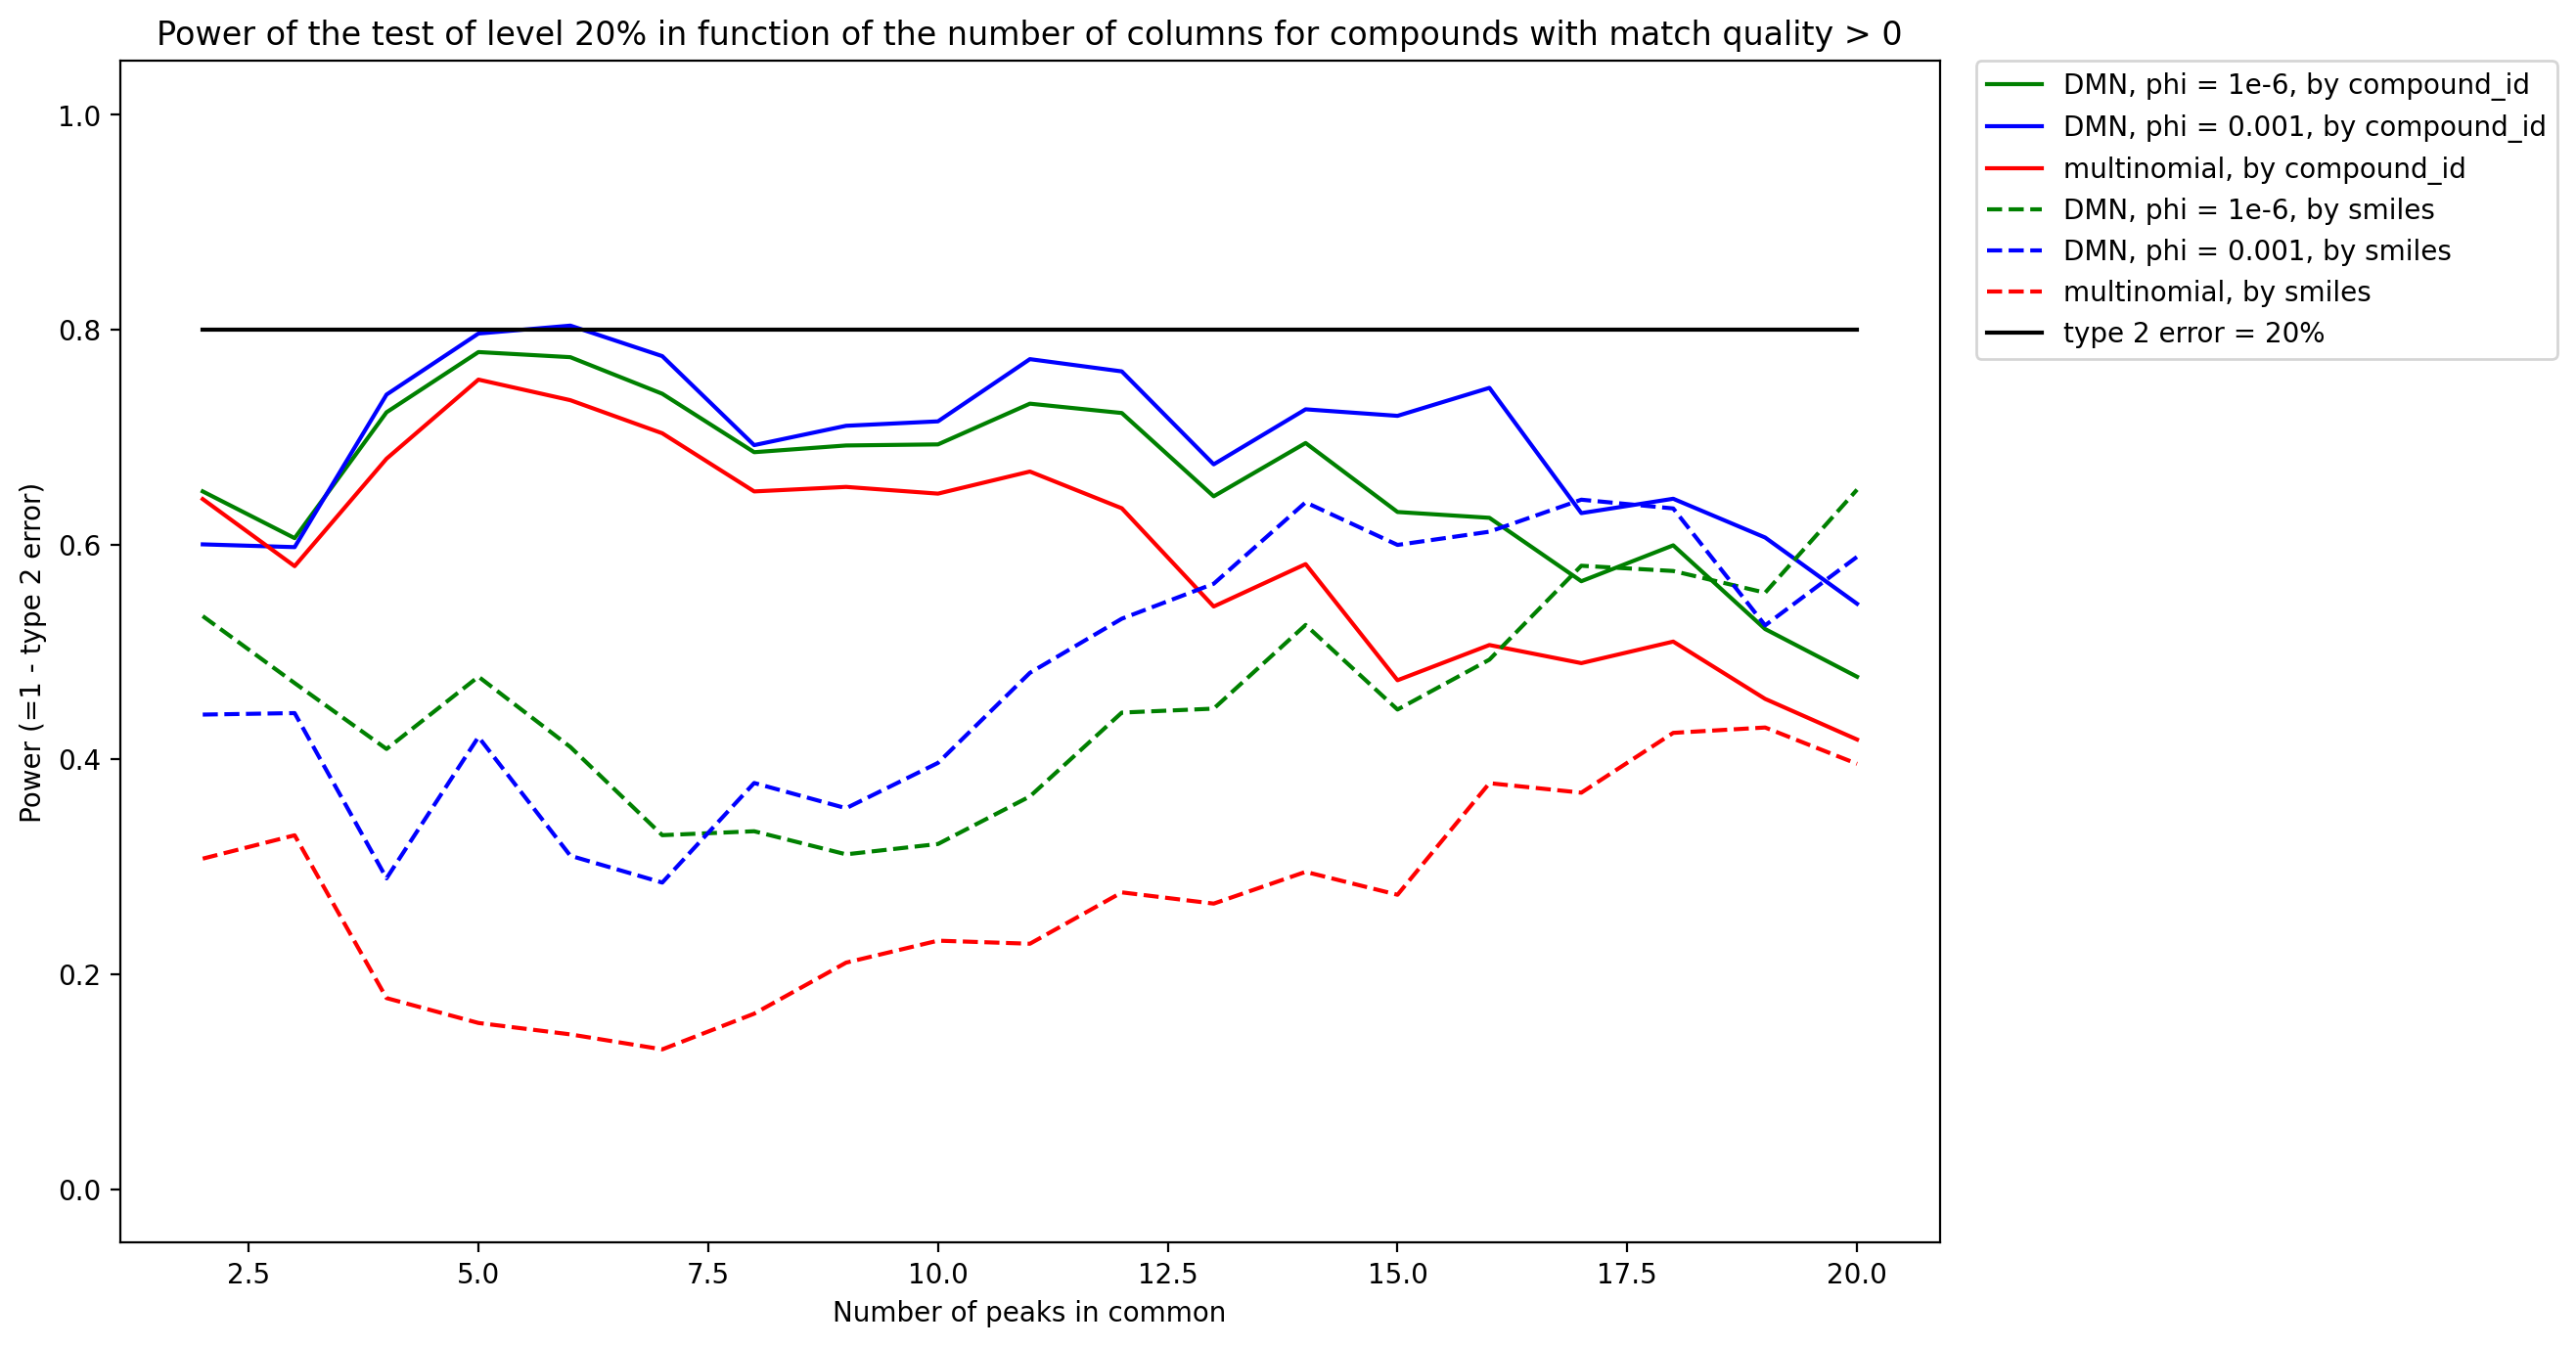

In [70]:
keys = ["1e-06", "0.001", "multinomial"]
color_code = pd.Series(["green", "blue", "red"], index = keys)
label_code = pd.Series(["DMN, phi = 1e-6", "DMN, phi = 0.001", "multinomial"], index = keys)

alpha = .2
max_col = 20

plt.figure(figsize = (12, 8))

for key in keys:
    stat_same = df_same_DMN[key]
    stat_diff = df_diff_DMN[key]
    
    columns_same = np.array(DMN_same["nb_col"])
    columns_diff = np.array(DMN_diff["nb_col"])
    
    
    plot_power(stat_same,
               stat_diff,
               columns_same * (np.array(DMN_same["mq"]) > 1e-2),
               columns_diff * (np.array([max(x, y) for x, y in DMN_diff["mq"]]) > 1e-2),
               label = label_code[key] + ", by compound_id",
               color = color_code[key],
               alpha = alpha,
               max_col = max_col
              )
    
for key in keys:
    stat_same = df_same_smiles[key]
    stat_diff = df_diff_smiles[key]
    
    columns_same = same_smiles_info["nb_col"]
    columns_diff = diff_smiles_info["nb_col"]
    
    plot_power(stat_same,
               stat_diff,
               columns_same * (same_smiles_info["mmq"] > 1e-2),
               columns_diff * (diff_smiles_info["mmq"] > 1e-2),
               style = "--",
               label = label_code[key] + ", by smiles",
               color = color_code[key],
               alpha = alpha,
               max_col = max_col
              )

plt.plot([2, max_col], [0, 0], "white")
plt.plot([2, max_col], [1, 1], "white")
plt.plot([2, max_col], [.8, .8], c = "k", label = "type 2 error = 20%")

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel("Number of peaks in common")
plt.ylabel("Power (=1 - type 2 error)")
plt.title("Power of the test of level " + str(int(100 * alpha)) + "% in function of the number of columns for compounds with match quality > 0")
plt.show()

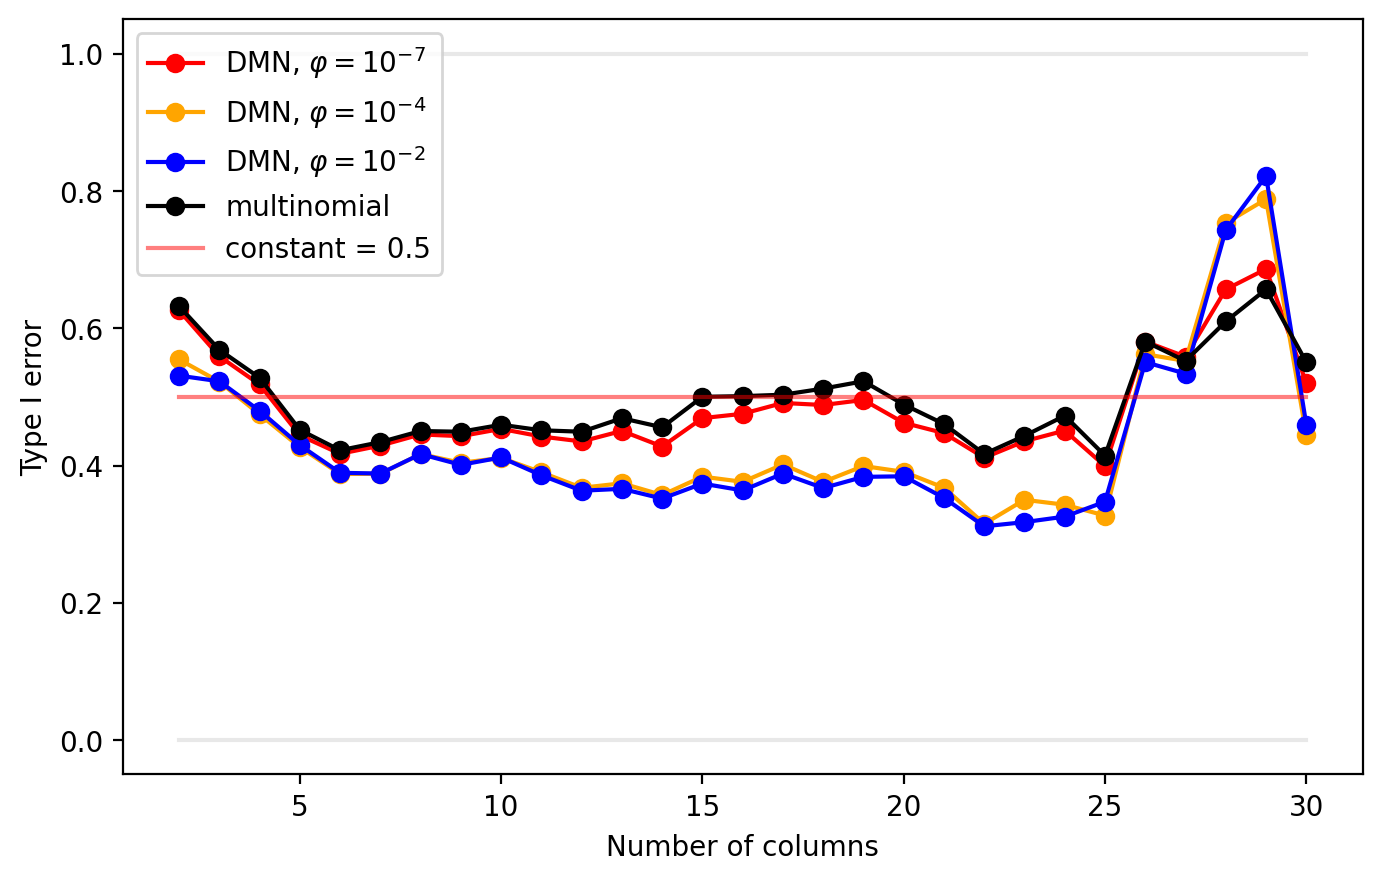

In [71]:
nb_cols = np.arange(2, 31)
beta = 0.1

lst_markers = []

for i in [0, 2, 8]:
    alphas = []
    key = lst_strphi[i]
    for nb_col in nb_cols:
        sel_same = DMN_same["nb_col"] == nb_col
        sel_diff = DMN_diff["nb_col"] == nb_col

        sr1 = df_same_DMN[key][sel_same]
        sr2 = df_diff_DMN[key][sel_diff]

        th = sr2.quantile(beta)
        alpha = sum(sr1 > th) / len(sr1)
        alphas.append(alpha)

    plt.plot(nb_cols, alphas, marker = "o", color = lst_colors[i], label = lst_latexphi[i])


alphas = []
key = ["multinomial"]
for nb_col in nb_cols:
    sel_same = DMN_same["nb_col"] == nb_col
    sel_diff = DMN_diff["nb_col"] == nb_col

    th = df_diff_DMN["multinomial"][sel_diff].quantile(0.1)
    alpha = sum(df_same_DMN["multinomial"][sel_same] > th) / len(df_same_DMN["multinomial"][sel_same])
    alphas.append(alpha)

plt.plot(nb_cols, alphas, marker = "o", color = "k", label = "multinomial")

plt.plot(nb_cols, len(nb_cols) * [0], color = "lightgrey", alpha = 0.5)
plt.plot(nb_cols, len(nb_cols) * [1], color = "lightgrey", alpha = 0.5)
plt.plot(nb_cols, len(nb_cols) * [0.5], color = "red", alpha = 0.5, label = "constant = 0.5")

plt.xlabel("Number of columns")
plt.ylabel("Type I error")

plt.legend()

plt.show()

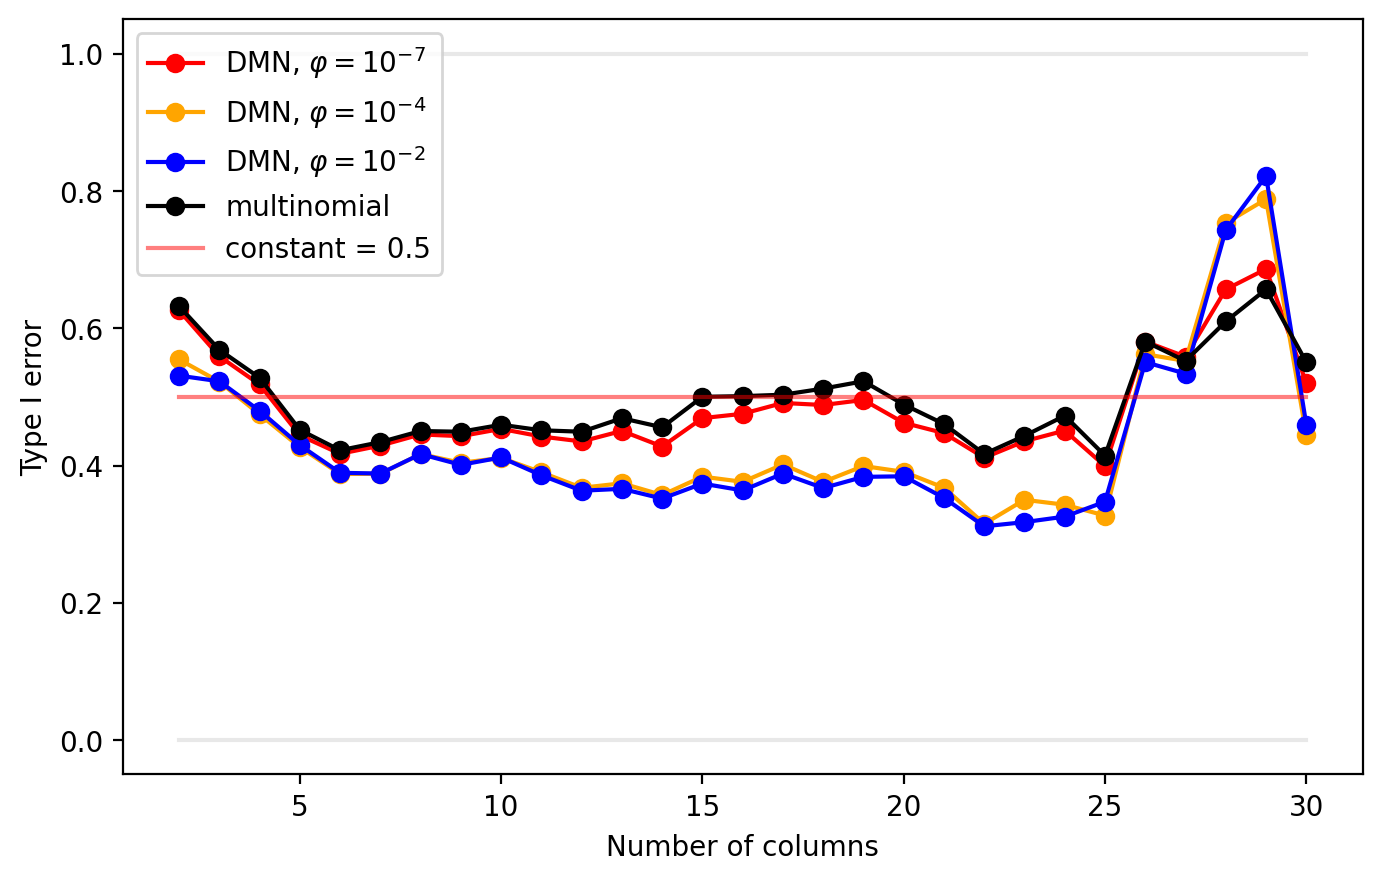

In [72]:
nb_cols = np.arange(2, 31)
beta = 0.1

lst_markers = []

for i in [0, 2, 8]:
    alphas = []
    key = lst_strphi[i]
    for nb_col in nb_cols:
        sel_same = DMN_same["nb_col"] == nb_col
        sel_diff = DMN_diff["nb_col"] == nb_col

        sr1 = df_same_DMN[key][sel_same]
        sr2 = df_diff_DMN[key][sel_diff]

        th = sr2.quantile(beta)
        alpha = sum(sr1 > th) / len(sr1)
        alphas.append(alpha)

    plt.plot(nb_cols, alphas, marker = "o", color = lst_colors[i], label = lst_latexphi[i])


alphas = []
key = ["multinomial"]
for nb_col in nb_cols:
    sel_same = DMN_same["nb_col"] == nb_col
    sel_diff = DMN_diff["nb_col"] == nb_col

    th = df_diff_DMN["multinomial"][sel_diff].quantile(0.1)
    alpha = sum(df_same_DMN["multinomial"][sel_same] > th) / len(df_same_DMN["multinomial"][sel_same])
    alphas.append(alpha)

plt.plot(nb_cols, alphas, marker = "o", color = "k", label = "multinomial")

plt.plot(nb_cols, len(nb_cols) * [0], color = "lightgrey", alpha = 0.5)
plt.plot(nb_cols, len(nb_cols) * [1], color = "lightgrey", alpha = 0.5)
plt.plot(nb_cols, len(nb_cols) * [0.5], color = "red", alpha = 0.5, label = "constant = 0.5")

plt.xlabel("Number of columns")
plt.ylabel("Type I error")

plt.legend()

plt.show()

In [73]:
th = df_diff_DMN["multinomial"][sel_diff].quantile(0.1)

In [74]:
sum(df_same_DMN["multinomial"][sel_same] > th)

109

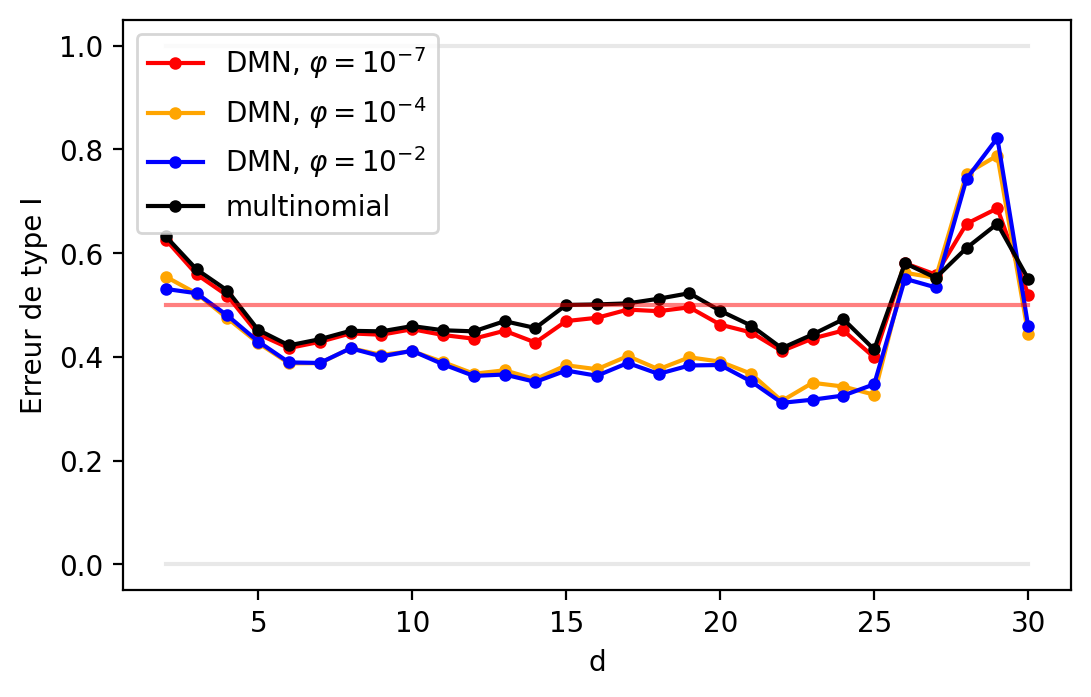

In [103]:
plt.rcParams["figure.figsize"] = (0.18 * 34, 0.18 * 21)

nb_cols = np.arange(2, 31)
beta = 0.1

lst_markers = ["^", 0, "D", 0, 0, 0, 0, 0, "|"]

for i in [0, 2, 8]:
    alphas = []
    key = lst_strphi[i]
    for nb_col in nb_cols:
        sel_same = DMN_same["nb_col"] == nb_col
        sel_diff = DMN_diff["nb_col"] == nb_col

        sr1 = df_same_DMN[key][sel_same]
        sr2 = df_diff_DMN[key][sel_diff]

        th = sr2.quantile(beta)
        alpha = sum(sr1 > th) / len(sr1)
        alphas.append(alpha)

    plt.plot(nb_cols, alphas, marker = "o", markersize = 3.5, color = lst_colors[i], label = lst_latexphi[i])


alphas = []
key = ["multinomial"]
for nb_col in nb_cols:
    sel_same = DMN_same["nb_col"] == nb_col
    sel_diff = DMN_diff["nb_col"] == nb_col

    th = df_diff_DMN["multinomial"][sel_diff].quantile(0.1)
    alpha = sum(df_same_DMN["multinomial"][sel_same] > th) / len(df_same_DMN["multinomial"][sel_same])
    alphas.append(alpha)

plt.plot(nb_cols, alphas, marker = "o", markersize = 3.5, color = "k", label = "multinomial")

plt.plot(nb_cols, len(nb_cols) * [0], color = "lightgrey", alpha = 0.5)
plt.plot(nb_cols, len(nb_cols) * [1], color = "lightgrey", alpha = 0.5)
plt.plot(nb_cols, len(nb_cols) * [0.5], color = "red", alpha = 0.5)

plt.xlabel("d")
plt.ylabel("Erreur de type I")

plt.legend()

plt.show()